In [495]:
"""
Title: Vistra Corp - Take Home Modeling Problem
Client: n/a
Date: 6/14/2024
Author: Myles Thomas
"""


'\nTitle: Vistra Corp - Take Home Modeling Problem\nClient: n/a\nDate: 6/14/2024\nAuthor: Myles Thomas\n'

In [496]:
import os
import holidays
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

def convert_dtypes(df):
    """
    Converts columns in a DataFrame to numeric if possible, otherwise to categorical.
    
    Parameters:
    df (pd DataFrame): The DataFrame to convert.
    
    Returns:
    pd.DataFrame: The DataFrame with converted data types.
    """
    for column in df.columns:
        # Attempt to convert each column to numeric
        df[column] = pd.to_numeric(df[column], errors='ignore')
        # If the column is not numeric and is an object, convert it to categorical
        if df[column].dtype == 'object':
            df[column] = df[column].astype('category')
    return df

def set_datetime_index(df, column_name):
    """
    Sets a DataFrame's index to the datetime column provided.
    
    Parameters:
    df (pd DataFrame): The DataFrame to set the index for.
    column_name (str): The column in the DataFrame that holds the time/period information. 
    
    Returns:
    pd.DataFrame: The DataFrame set index.
    """
    if not pd.api.types.is_datetime64_any_dtype(df[column_name]):
        df[column_name] = pd.to_datetime(df[column_name])
    df.set_index(column_name, inplace=True)
    return df

def add_holiday_flags(df, country='US'):
    """
    Adds binary flags and holiday names to a DataFrame using the DataFrame's index as dates.
    
    Parameters:
    - df (pd.DataFrame): A DataFrame with its index set to datetime representing dates.
    - country (str): The country code to identify the applicable holiday calendar.
      Default is 'US' for United States.

    Returns:
    - pd.DataFrame: The original DataFrame with two new columns:
      'is_holiday' - a binary flag (1 if the date is a holiday, 0 otherwise).
      'holiday_name' - the name of the holiday on that date (None if not a holiday).
    """
    
    # Ensure the index is of datetime type
    df.index = pd.to_datetime(df.index)

    # Initialize holidays for the specified country
    holiday_calendar = holidays.CountryHoliday(country)

    # Add a binary flag for holidays and the holiday name using the DataFrame's index
    df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in holiday_calendar else 0)
    df['holiday_name'] = df.index.to_series().apply(lambda x: holiday_calendar.get(x))

    return df

SCRIPT_DIR = os.getcwd()
PARENT_DIR = os.path.dirname(SCRIPT_DIR)
INPUT_DIR = os.path.join(PARENT_DIR, "00_INPUT/")
INTER_DIR = os.path.join(PARENT_DIR, "01_INTERMEDIATE/")
OUTPUT_DIR = os.path.join(PARENT_DIR, "02_OUTPUT/")

print(f"script directory: {SCRIPT_DIR}")


script directory: c:\Users\Myles\vistra_take_home\03_CODE


In [497]:
pd.options.mode.chained_assignment = None  # None to disable the SettingWithCopyWarning


# Overview

- import and prepare data
- exploratory data analysis (including outlier analysis and removal)
- feature engineering
- training/test split
- model training and testing
- output MAE of test data
- plot predictions vs actuals in test set

## Import and Prepare Data


In [498]:
FILENAME_INPUT_DATA = "Wind_data.xlsx"

# Get all sheet names
excel_file = pd.ExcelFile(os.path.join(INPUT_DIR, FILENAME_INPUT_DATA))
print(excel_file.sheet_names)

train_data_full = pd.read_excel(os.path.join(INPUT_DIR, FILENAME_INPUT_DATA), sheet_name="Train")
test_data_full = pd.read_excel(os.path.join(INPUT_DIR, FILENAME_INPUT_DATA), sheet_name="Predict")

train_data = train_data_full.copy()
test_data = test_data_full.copy()
print(train_data.shape)
print(test_data.shape)

train_data = set_datetime_index(df=train_data, column_name="DATETIME")
test_data = set_datetime_index(df=test_data, column_name="DATETIME")

['Train', 'Predict']
(3635, 114)
(93, 114)


In [499]:
train_data.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2019-08-07 00:00:00  0.652524       10.35        8.99        4.57        9.69   
2019-08-07 01:00:00  0.605852        9.70        8.28        5.78        9.10   
2019-08-07 02:00:00  0.564094        9.04        7.39        6.21        8.98   
2019-08-07 03:00:00  0.532721        8.78        7.49        6.43        8.84   
2019-08-07 04:00:00  0.495608        8.23        6.88        6.81        8.52   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2019-08-07 00:00:00        8.90        2.90        5.74        1.16   
2019-08-07 01:00:00        7.98        2.23        3.46        0.97   
2019-08-07 02:00:00        7.78        1.98        2.62        0.92   
2019-08-07 03:00:00        7.82        1.33        2.43        0.68   
2019-08-07 04:00:00        6.65        1.64        2.45        0.59   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
DATETIME                         ...                                   
2019-08-07 00:00:00        8.81  ...     11.12       6.79       9.31   
2019-08-07 01:00:00        7.75  ...     10.47       6.40       9.50   
2019-08-07 02:00:00        7.55  ...     10.10       6.23       9.46   
2019-08-07 03:00:00        7.53  ...      9.67       6.01       9.45   
2019-08-07 04:00:00        6.40  ...      9.24       5.83       9.30   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
DATETIME                                                                     
2019-08-07 00:00:00      11.63      10.72      10.55      11.41      10.77   
2019-08-07 01:00:00      11.10      11.02       9.91      11.16      10.98   
2019-08-07 02:00:00      10.74      11.19       9.52      11.00      11.10   
2019-08-07 03:00:00      10.65      11.27       9.11      10.93      11.18   
2019-08-07 04:00:00       9.78      10.85       8.64      10.69      10.83   

                     WS_920775  WS_921049  
DATETIME                                   
2019-08-07 00:00:00      10.17       9.24  
2019-08-07 01:00:00      10.16       9.09  
2019-08-07 02:00:00      10.04       9.04  
2019-08-07 03:00:00      10.20       8.89  
2019-08-07 04:00:00       9.88       8.67  

[5 rows x 113 columns]

In [500]:
train_data.tail()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2020-01-07 19:00:00  0.004494        1.56        1.62        2.44        1.81   
2020-01-07 20:00:00  0.006143        1.51        1.55        2.13        1.93   
2020-01-07 21:00:00  0.008399        1.51        1.62        2.42        1.82   
2020-01-07 22:00:00  0.015788        1.53        1.73        2.22        1.83   
2020-01-07 23:00:00  0.011883        1.55        1.70        2.34        1.50   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-07 19:00:00        2.23        2.05        1.81        5.55   
2020-01-07 20:00:00        2.36        1.45        1.14        4.61   
2020-01-07 21:00:00        2.47        1.60        1.02        4.00   
2020-01-07 22:00:00        2.53        1.44        1.15        3.78   
2020-01-07 23:00:00        2.65        1.08        1.06        3.35   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
DATETIME                         ...                                   
2020-01-07 19:00:00        1.77  ...      1.41       1.56       1.04   
2020-01-07 20:00:00        2.06  ...      1.32       1.82       0.88   
2020-01-07 21:00:00        2.48  ...      1.26       2.09       1.28   
2020-01-07 22:00:00        2.71  ...      1.24       1.87       1.37   
2020-01-07 23:00:00        2.91  ...      1.39       1.41       1.20   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
DATETIME                                                                     
2020-01-07 19:00:00       1.48       1.55       1.94       1.72       1.30   
2020-01-07 20:00:00       1.12       1.32       1.87       1.81       1.42   
2020-01-07 21:00:00       0.87       1.37       1.83       2.08       1.44   
2020-01-07 22:00:00       1.05       1.06       1.83       1.61       1.54   
2020-01-07 23:00:00       1.27       0.86       1.81       1.41       1.06   

                     WS_920775  WS_921049  
DATETIME                                   
2020-01-07 19:00:00       1.22       1.60  
2020-01-07 20:00:00       1.05       1.87  
2020-01-07 21:00:00       1.32       2.05  
2020-01-07 22:00:00       1.47       2.05  
2020-01-07 23:00:00       1.17       1.47  

[5 rows x 113 columns]

In [501]:
test_data.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                  
2020-01-09 00:00:00 NaN        1.69        1.88        3.15        0.92   
2020-01-09 01:00:00 NaN        1.60        2.02        3.91        0.44   
2020-01-09 02:00:00 NaN        1.79        2.14        4.20        0.65   
2020-01-09 03:00:00 NaN        2.01        2.32        5.17        0.51   
2020-01-09 04:00:00 NaN        2.12        2.54        4.19        0.77   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-09 00:00:00        2.27        1.14        1.24        2.98   
2020-01-09 01:00:00        2.36        1.15        1.63        2.83   
2020-01-09 02:00:00        2.06        1.28        2.36        3.07   
2020-01-09 03:00:00        2.31        0.83        3.39        3.38   
2020-01-09 04:00:00        4.52        0.97        2.89        3.79   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
DATETIME                         ...                                   
2020-01-09 00:00:00        2.53  ...      1.40       1.27       1.27   
2020-01-09 01:00:00        2.84  ...      1.02       1.11       1.43   
2020-01-09 02:00:00        2.34  ...      1.39       1.42       1.42   
2020-01-09 03:00:00        2.53  ...      1.55       2.01       1.26   
2020-01-09 04:00:00        4.21  ...      1.64       2.40       1.69   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
DATETIME                                                                     
2020-01-09 00:00:00       1.43       1.28       1.91       1.12       1.15   
2020-01-09 01:00:00       2.04       1.60       1.57       1.03       1.28   
2020-01-09 02:00:00       2.91       1.81       1.85       1.10       1.56   
2020-01-09 03:00:00       2.49       2.09       2.09       1.06       2.12   
2020-01-09 04:00:00       1.36       2.08       2.06       1.08       2.33   

                     WS_920775  WS_921049  
DATETIME                                   
2020-01-09 00:00:00       1.35       1.46  
2020-01-09 01:00:00       1.49       1.29  
2020-01-09 02:00:00       1.54       1.56  
2020-01-09 03:00:00       1.66       2.18  
2020-01-09 04:00:00       2.17       2.60  

[5 rows x 113 columns]

In [502]:

test_data.tail()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                  
2020-01-12 16:00:00 NaN        3.12        2.62        4.04        6.08   
2020-01-12 17:00:00 NaN        2.79        2.31        4.25        5.95   
2020-01-12 18:00:00 NaN        2.86        2.44        3.95        6.13   
2020-01-12 19:00:00 NaN        2.81        2.20        4.32        6.07   
2020-01-12 20:00:00 NaN        2.35        1.71        4.12        5.90   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2020-01-12 16:00:00        1.07        2.42        2.00        6.50   
2020-01-12 17:00:00        1.59        3.96        1.73        7.42   
2020-01-12 18:00:00        2.58        2.58        1.56        7.36   
2020-01-12 19:00:00        1.93        2.02        1.61        6.72   
2020-01-12 20:00:00        2.10        1.99        1.70        6.36   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
DATETIME                         ...                                   
2020-01-12 16:00:00        1.18  ...      3.93       5.69       5.19   
2020-01-12 17:00:00        1.73  ...      3.58       4.90       4.59   
2020-01-12 18:00:00        2.40  ...      3.62       4.63       4.14   
2020-01-12 19:00:00        1.64  ...      3.95       6.02       4.20   
2020-01-12 20:00:00        1.74  ...      3.72       5.99       4.03   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
DATETIME                                                                     
2020-01-12 16:00:00       1.80       3.23       3.48       5.16       3.36   
2020-01-12 17:00:00       2.05       2.68       3.04       4.59       2.72   
2020-01-12 18:00:00       2.21       2.41       3.34       4.77       2.54   
2020-01-12 19:00:00       1.37       2.01       3.58       5.06       2.44   
2020-01-12 20:00:00       1.54       1.95       3.23       5.26       2.63   

                     WS_920775  WS_921049  
DATETIME                                   
2020-01-12 16:00:00       5.30       4.55  
2020-01-12 17:00:00       4.63       3.81  
2020-01-12 18:00:00       4.27       3.42  
2020-01-12 19:00:00       4.46       4.33  
2020-01-12 20:00:00       4.35       4.42  

[5 rows x 113 columns]

In [503]:
df = train_data.copy()

df.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
DATETIME                                                                        
2019-08-07 00:00:00  0.652524       10.35        8.99        4.57        9.69   
2019-08-07 01:00:00  0.605852        9.70        8.28        5.78        9.10   
2019-08-07 02:00:00  0.564094        9.04        7.39        6.21        8.98   
2019-08-07 03:00:00  0.532721        8.78        7.49        6.43        8.84   
2019-08-07 04:00:00  0.495608        8.23        6.88        6.81        8.52   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
DATETIME                                                              
2019-08-07 00:00:00        8.90        2.90        5.74        1.16   
2019-08-07 01:00:00        7.98        2.23        3.46        0.97   
2019-08-07 02:00:00        7.78        1.98        2.62        0.92   
2019-08-07 03:00:00        7.82        1.33        2.43        0.68   
2019-08-07 04:00:00        6.65        1.64        2.45        0.59   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
DATETIME                         ...                                   
2019-08-07 00:00:00        8.81  ...     11.12       6.79       9.31   
2019-08-07 01:00:00        7.75  ...     10.47       6.40       9.50   
2019-08-07 02:00:00        7.55  ...     10.10       6.23       9.46   
2019-08-07 03:00:00        7.53  ...      9.67       6.01       9.45   
2019-08-07 04:00:00        6.40  ...      9.24       5.83       9.30   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
DATETIME                                                                     
2019-08-07 00:00:00      11.63      10.72      10.55      11.41      10.77   
2019-08-07 01:00:00      11.10      11.02       9.91      11.16      10.98   
2019-08-07 02:00:00      10.74      11.19       9.52      11.00      11.10   
2019-08-07 03:00:00      10.65      11.27       9.11      10.93      11.18   
2019-08-07 04:00:00       9.78      10.85       8.64      10.69      10.83   

                     WS_920775  WS_921049  
DATETIME                                   
2019-08-07 00:00:00      10.17       9.24  
2019-08-07 01:00:00      10.16       9.09  
2019-08-07 02:00:00      10.04       9.04  
2019-08-07 03:00:00      10.20       8.89  
2019-08-07 04:00:00       9.88       8.67  

[5 rows x 113 columns]

It appears that we are dealing with hourly data. Let's check to see if there are any gaps, and if so, to fill them LATER on in the modeling process.
- Method to fill: Forward filling
    - Rationale: Forward filling Doesn't use future information
    - Backward fill can potentially introduce data leakage
- Reason for not filling now: Could introduce bias in the feature engineering phase due to duplicate values
    - Will have to fill before using ML for time series forecasting but we can do that later on in the process


# Outlier Analysis and removal

Let's take a look at the extreme values, namely the observations that are too large.

This could occur due to something that we cannot predict/account for.

In [504]:
response_var = 'CF'

<Axes: ylabel='Frequency'>

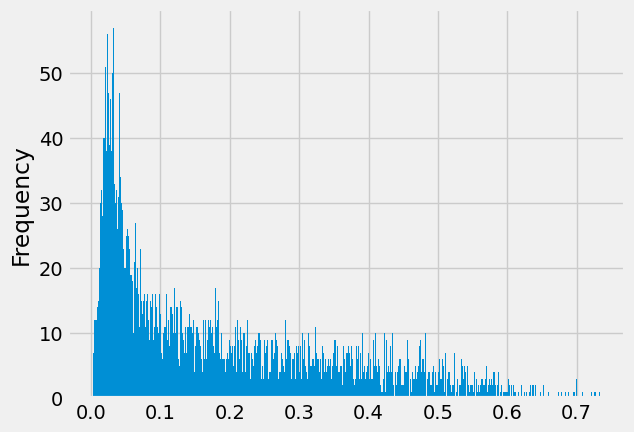

In [505]:
df[response_var].plot(kind='hist', bins=500)

In [506]:
# Remove outliers that we see by eye
threshold_upper_bound_outliers = 0.6
df = df.query(f'{response_var} < {threshold_upper_bound_outliers}').copy()

<Axes: ylabel='Frequency'>

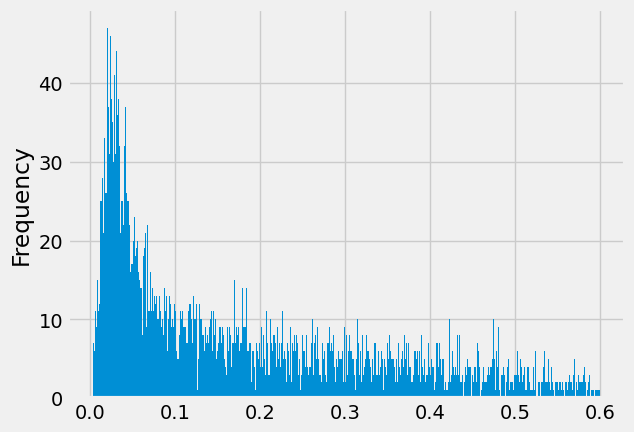

In [507]:
df[response_var].plot(kind='hist', bins=500)

## Exploratory Data Analysis

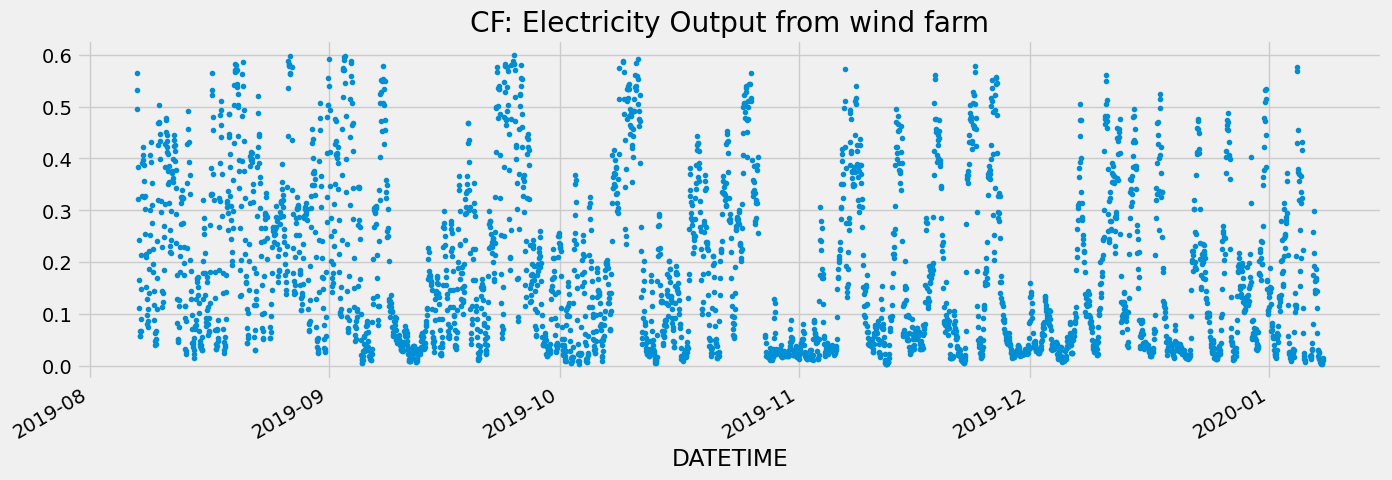

In [508]:
df[response_var].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='CF: Electricity Output from wind farm')
plt.show()

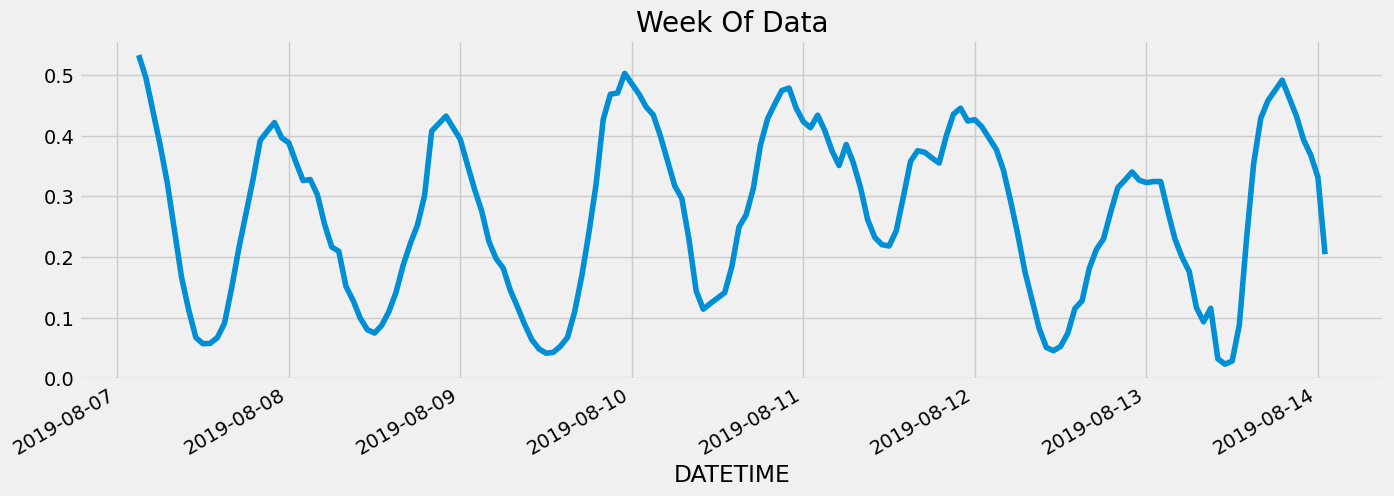

In [509]:
# Looking at just 1 week of data to try and understand trends
date_str_begin = df.index.min()
date_str_end = df.index.min() + pd.Timedelta(days=7)
df[response_var].loc[(df.index > date_str_begin) & (df.index < date_str_end)] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

The trends appears to be daily ie. every 24 hours

In [510]:
corr = df.corr()
corr

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
CF          1.000000    0.711077    0.695369    0.174919    0.411604   
WS_1133733  0.711077    1.000000    0.984737    0.086254    0.677423   
WS_1156770  0.695369    0.984737    1.000000    0.091515    0.638137   
WS_1156968  0.174919    0.086254    0.091515    1.000000    0.073077   
WS_1182195  0.411604    0.677423    0.638137    0.073077    1.000000   
...              ...         ...         ...         ...         ...   
WS_883699   0.690824    0.982288    0.949656    0.113018    0.728270   
WS_914573   0.566145    0.796621    0.757994    0.095943    0.932438   
WS_918665   0.808715    0.555286    0.543213    0.165273    0.460682   
WS_920775   0.751277    0.539882    0.522999    0.164307    0.508034   
WS_921049   0.722812    0.514501    0.489100    0.188398    0.510978   

            WS_1193865  WS_1321569  WS_1324653  WS_1358699  WS_1366338  ...  \
CF            0.587085    0.219195    0.422379   -0.164703    0.589703  ...   
WS_1133733    0.465392    0.323341    0.249579   -0.006225    0.459183  ...   
WS_1156770    0.488398    0.331792    0.269647   -0.002214    0.486568  ...   
WS_1156968    0.250216    0.059057    0.315130    0.132692    0.256449  ...   
WS_1182195    0.098417    0.320750    0.152082    0.305187    0.083786  ...   
...                ...         ...         ...         ...         ...  ...   
WS_883699     0.435602    0.348324    0.247898    0.079191    0.421992  ...   
WS_914573     0.218784    0.313079    0.213740    0.134241    0.212353  ...   
WS_918665     0.351854    0.236745    0.396822   -0.030960    0.353347  ...   
WS_920775     0.299848    0.316925    0.360863    0.119110    0.286560  ...   
WS_921049     0.273182    0.320377    0.350482    0.081501    0.254637  ...   

            WS_78208  WS_811655  WS_839753  WS_875373  WS_883683  WS_883699  \
CF          0.709218   0.470966   0.771994   0.667705   0.820454   0.690824   
WS_1133733  0.976760   0.369912   0.590929   0.509633   0.568842   0.982288   
WS_1156770  0.934020   0.339807   0.577101   0.524420   0.564410   0.949656   
WS_1156968  0.086502   0.192418   0.147567   0.166546   0.150628   0.113018   
WS_1182195  0.735293   0.514079   0.509010   0.131981   0.424276   0.728270   
...              ...        ...        ...        ...        ...        ...   
WS_883699   0.983694   0.432397   0.605575   0.470705   0.558266   1.000000   
WS_914573   0.839300   0.462603   0.558534   0.278696   0.509682   0.822635   
WS_918665   0.581208   0.706026   0.925974   0.424043   0.983914   0.554048   
WS_920775   0.578834   0.810329   0.981327   0.350252   0.928588   0.559706   
WS_921049   0.566504   0.891916   0.902766   0.329070   0.875877   0.542154   

            WS_914573  WS_918665  WS_920775  WS_921049  
CF           0.566145   0.808715   0.751277   0.722812  
WS_1133733   0.796621   0.555286   0.539882   0.514501  
WS_1156770   0.757994   0.543213   0.522999   0.489100  
WS_1156968   0.095943   0.165273   0.164307   0.188398  
WS_1182195   0.932438   0.460682   0.508034   0.510978  
...               ...        ...        ...        ...  
WS_883699    0.822635   0.554048   0.559706   0.542154  
WS_914573    1.000000   0.531532   0.542929   0.539734  
WS_918665    0.531532   1.000000   0.947606   0.932041  
WS_920775    0.542929   0.947606   1.000000   0.938570  
WS_921049    0.539734   0.932041   0.938570   1.000000  

[113 rows x 113 columns]

In [511]:
corr_pairs = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).stack().reset_index()
corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']

n = 50

top_n_corr = corr_pairs.assign(AbsCorrelation=corr_pairs['Correlation'].abs()).sort_values('AbsCorrelation', ascending=False).head(n)

top_n_corr = top_n_corr.drop('AbsCorrelation', axis=1)

print(top_n_corr)

       Variable1   Variable2  Correlation
5814    WS_75932    WS_77682     1.000000
4088  WS_2508545    WS_75936     0.999997
5105    WS_73494    WS_74022     0.999945
3176  WS_2118117  WS_2479342     0.999922
5624    WS_74884   WS_921049     0.999902
4961    WS_72733   WS_746023     0.999881
5752    WS_75812    WS_77740     0.999877
5710    WS_75287    WS_76888     0.999856
1575  WS_1513782  WS_1513805     0.999854
5342    WS_74158    WS_74719     0.999809
5197    WS_73822   WS_918665     0.999754
4970    WS_72733    WS_75933     0.999707
2051  WS_1625374  WS_1681085     0.999659
5902    WS_75935    WS_77363     0.999645
1254  WS_1369320    WS_76434     0.999598
4966    WS_72733    WS_75287     0.999469
5516   WS_746023    WS_75933     0.999458
2967  WS_1960535    WS_74719     0.999368
4512   WS_629020    WS_74124     0.999357
5175    WS_73822    WS_76275     0.999231
3265  WS_2217107   WS_631992     0.999119
6175    WS_77682    WS_77683     0.999087
5815    WS_75932    WS_77683     0

There appears to be some very highly correlated variables among these Wind Speed measurements from different locations.

## Feature Engineering

One technique that I like to use, that I find works better than removing correlated features, is to combine the nuance of all of these correlated features by feeding them in a decision tree.

Typically, this will uncover relationships in the data that we may not have discovered by another more traditional dimension reduction method.

First iteration of the baseline model: No tuning

In [512]:
list_wind_predictors = [x for x in df.columns if x != response_var]
len(list_wind_predictors)

112

In [513]:
assert len(list_wind_predictors) + 1 == df.shape[1]

In [514]:
list_wind_predictors[0]

'WS_1133733'

In [515]:
list_wind_predictors[len(list_wind_predictors) - 1]

'WS_921049'

In [516]:
# Feature Engineering: Add correlated variables to a decision tree that predicts the output
df.sort_index(inplace=True)
X = df.drop(response_var, axis=1)  # All columns except 'y'
y = df[response_var]

# from sktime.split import temporal_train_test_split
# y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

split_point = int(len(df) * 0.8)
cutoff_date_str = df.index[split_point]
print(f"cutoff date: {cutoff_date_str}")
train = df.loc[df.index < cutoff_date_str]
test = df.loc[df.index >= cutoff_date_str]

X_train = train[list_wind_predictors]
y_train = train[[response_var]]
X_test = test[list_wind_predictors]
y_test = test[[response_var]]


cutoff date: 2019-12-08 07:00:00


In [517]:
max(X_train.index)

Timestamp('2019-12-08 06:00:00')

In [518]:
min(X_test.index)

Timestamp('2019-12-08 07:00:00')

Note: To ensure that we do not introduce any data leakage, I have split the time series based on a cutoff date.

Later on, when cross-validating, I will have to setup a pipeline so that this model gets trained in an expanding fashion as well.

In [519]:
decision_tree = DecisionTreeRegressor(
    random_state=42
)

decision_tree.fit(X_train, y_train)

decision_tree

DecisionTreeRegressor(random_state=42)

In [520]:
y_test_pred = decision_tree.predict(X_test)

# test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

Test MAE: 0.05511270784682424


In [521]:
y_pred_test_df = pd.Series(y_test_pred, index=y_test.index)

In [522]:
from sktime.utils.plotting import plot_series

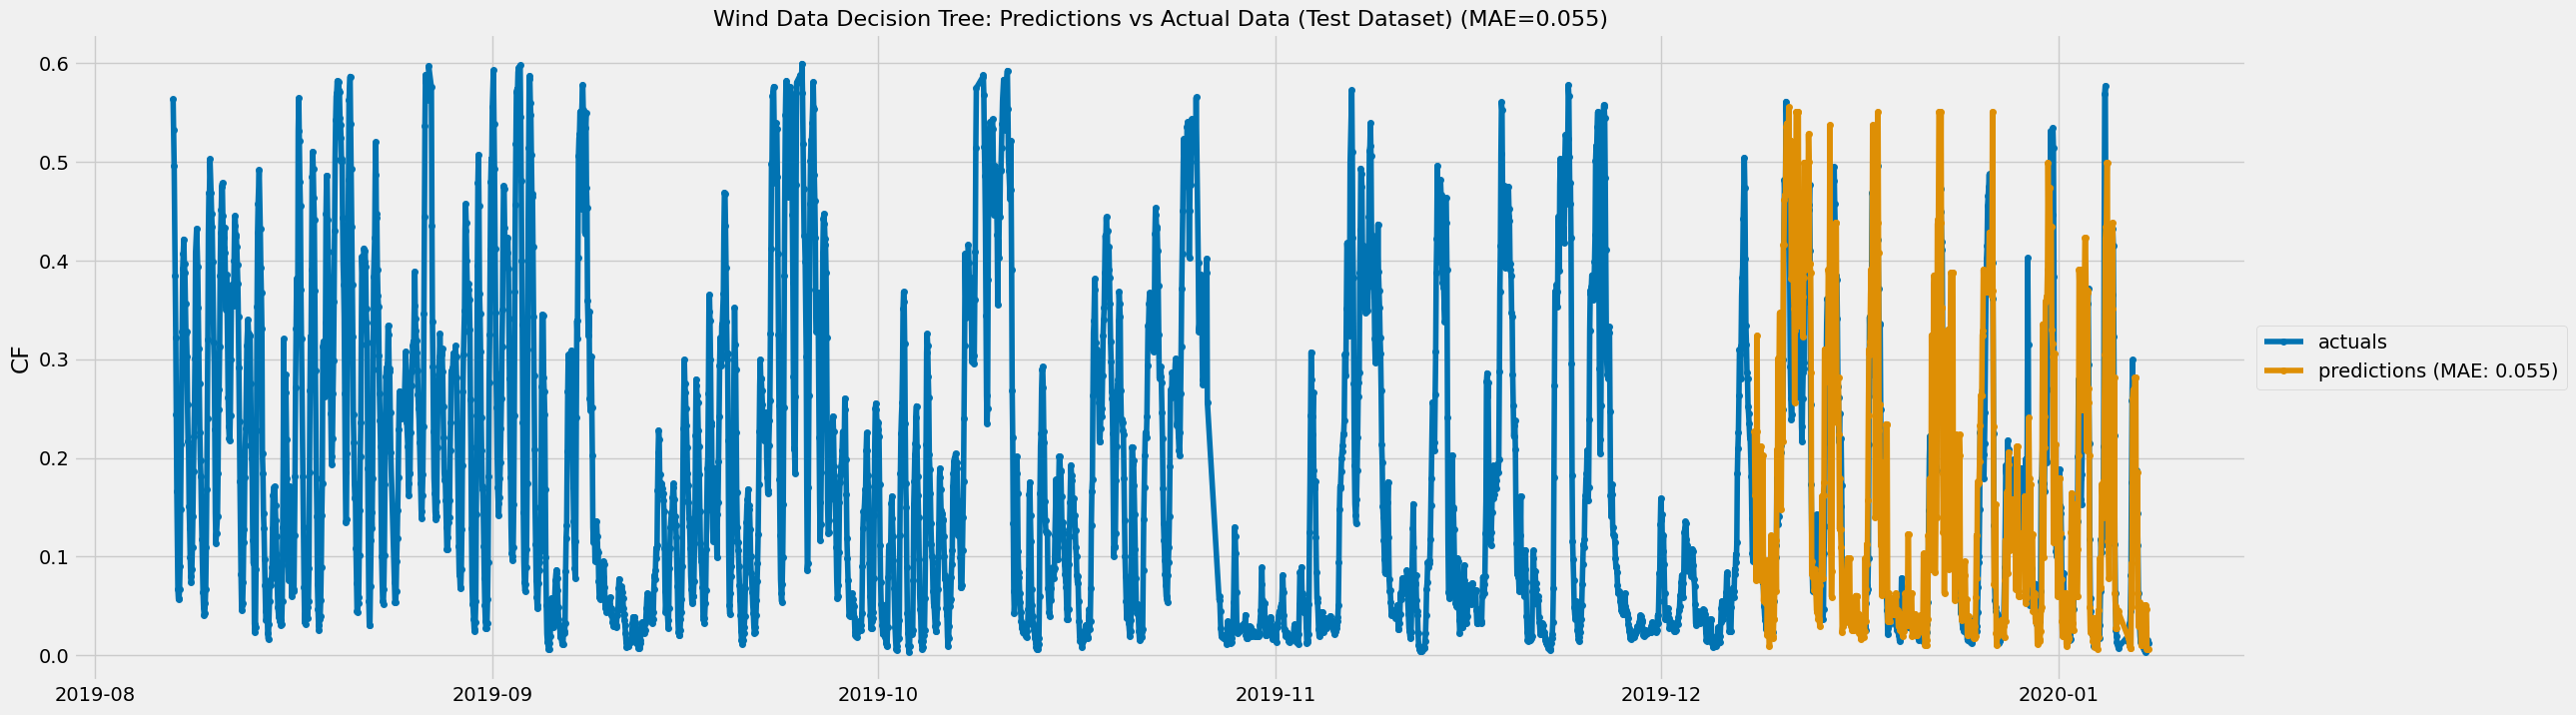

In [523]:
fig, ax = plot_series(
    y,
    y_pred_test_df,
    labels=['actuals', f'predictions (MAE: {test_mae:.3f})', ]
)
fig.set_size_inches(25, 8)  # Change the figure size to 25 inches wide by 8 inches tall

ax.set_title(f'Wind Data Decision Tree: Predictions vs Actual Data (Test Dataset) (MAE={test_mae:.3f})', fontsize=16) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  
plt.show()

Let's see if we can improve the performance via hyperparameter tuning with grid search:

In [524]:
dtree = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None,'sqrt', 'log2'] # removed 'auto'
}

grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1, 
    error_score='raise'
)

try:
    grid_search.fit(X_train, y_train)
except ValueError as e:
    print(f"Error during grid search: {e}")

best_dtree = grid_search.best_estimator_

y_pred_test = best_dtree.predict(X_test)
test_error = mean_absolute_error(y_test, y_pred_test)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test MAE: {test_error}") # using mse with this model since it is more sensitive to large outliers

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20}
Test MAE: 0.047428228151917336


In [525]:
y_test_pred = y_pred_test
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test MAE: {test_mae}")

Test MAE: 0.047428228151917336


In [526]:
y_pred_test_df = pd.Series(y_test_pred, index=y_test.index)
y_pred_test_df.head()

2019-12-08 07:00:00    0.197957
2019-12-08 08:00:00    0.197957
2019-12-08 09:00:00    0.197957
2019-12-08 10:00:00    0.126156
2019-12-08 11:00:00    0.104125
dtype: float64

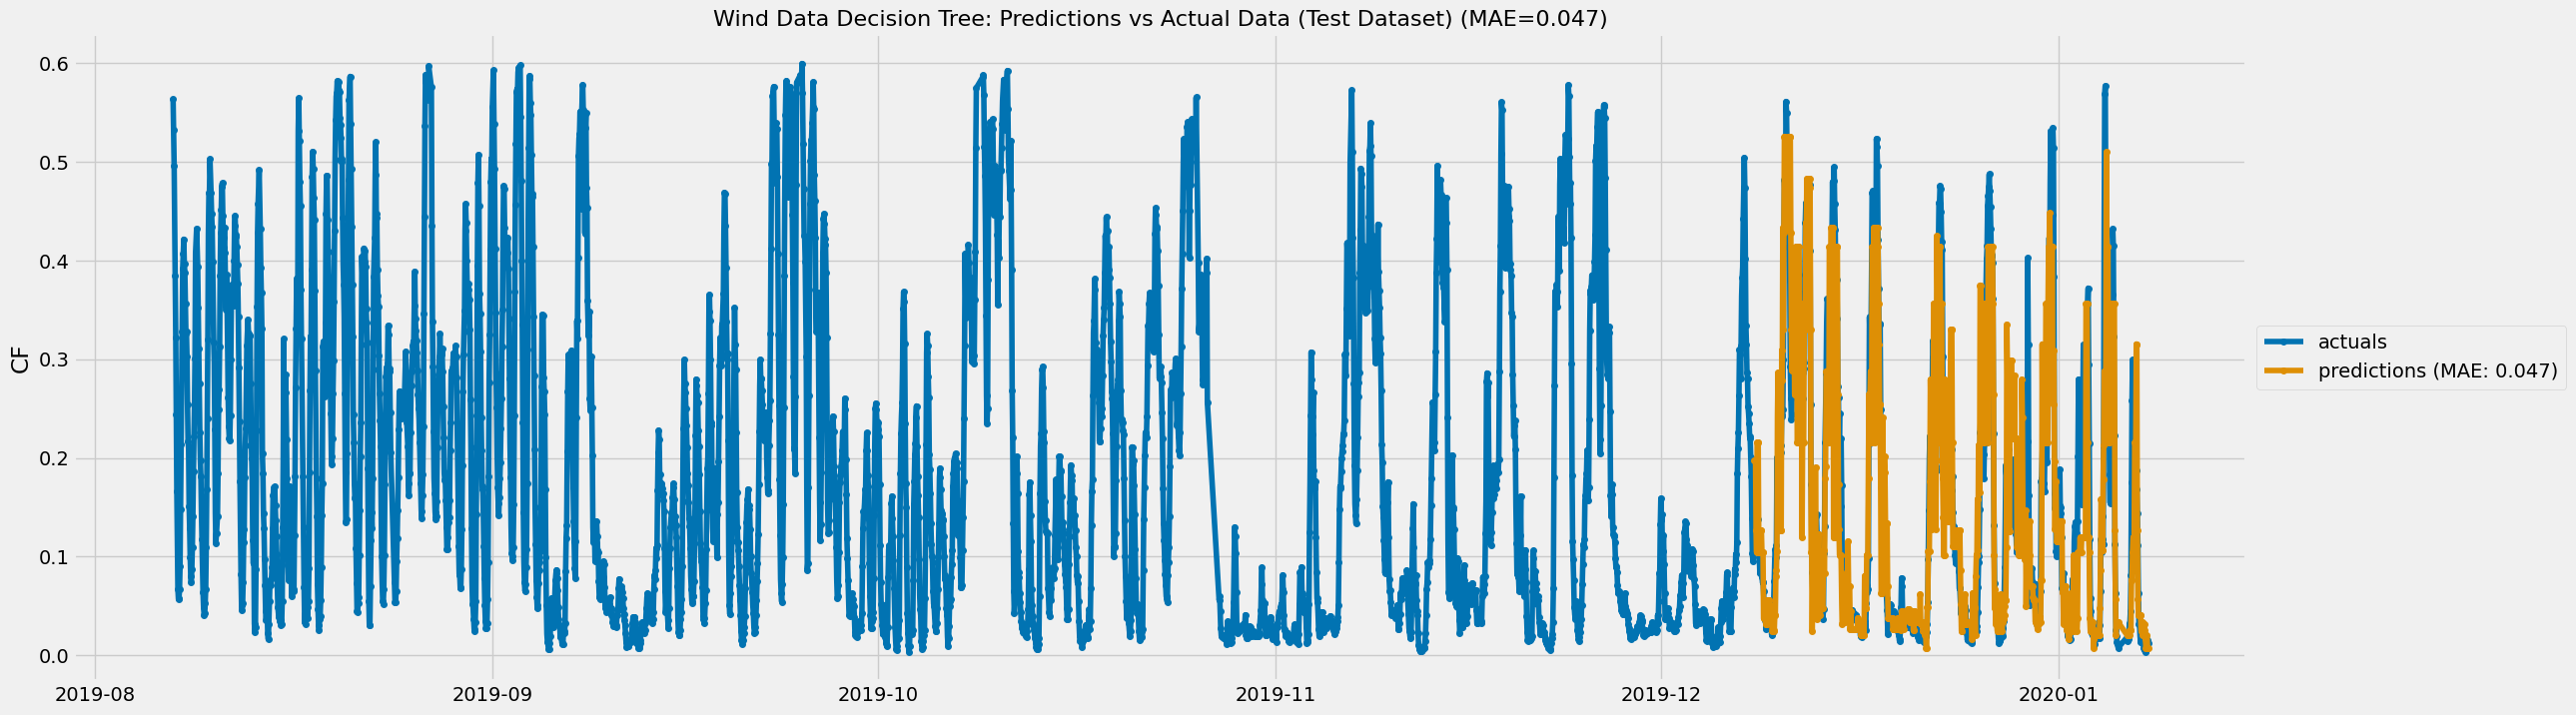

In [527]:
fig, ax = plot_series(
    y,
    y_pred_test_df,
    labels=['actuals', f'predictions (MAE: {test_mae:.3f})', ]
)
fig.set_size_inches(25, 8)  # Change the figure size to 25 inches wide by 8 inches tall

ax.set_title(f'Wind Data Decision Tree: Predictions vs Actual Data (Test Dataset) (MAE={test_mae:.3f})', fontsize=16) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  
plt.show()

And on the cross validation:

fold: 0
size of train set: (208, 113)
size of test set: (168, 113)
fold: 1
size of train set: (376, 113)
size of test set: (168, 113)
fold: 2
size of train set: (544, 113)
size of test set: (168, 113)
fold: 3
size of train set: (712, 113)
size of test set: (168, 113)
fold: 4
size of train set: (880, 113)
size of test set: (168, 113)
fold: 5
size of train set: (1048, 113)
size of test set: (168, 113)
fold: 6
size of train set: (1216, 113)
size of test set: (168, 113)
fold: 7
size of train set: (1384, 113)
size of test set: (168, 113)
fold: 8
size of train set: (1552, 113)
size of test set: (168, 113)
fold: 9
size of train set: (1720, 113)
size of test set: (168, 113)
fold: 10
size of train set: (1888, 113)
size of test set: (168, 113)
fold: 11
size of train set: (2056, 113)
size of test set: (168, 113)
fold: 12
size of train set: (2224, 113)
size of test set: (168, 113)
fold: 13
size of train set: (2392, 113)
size of test set: (168, 113)
fold: 14
size of train set: (2560, 113)
size of t

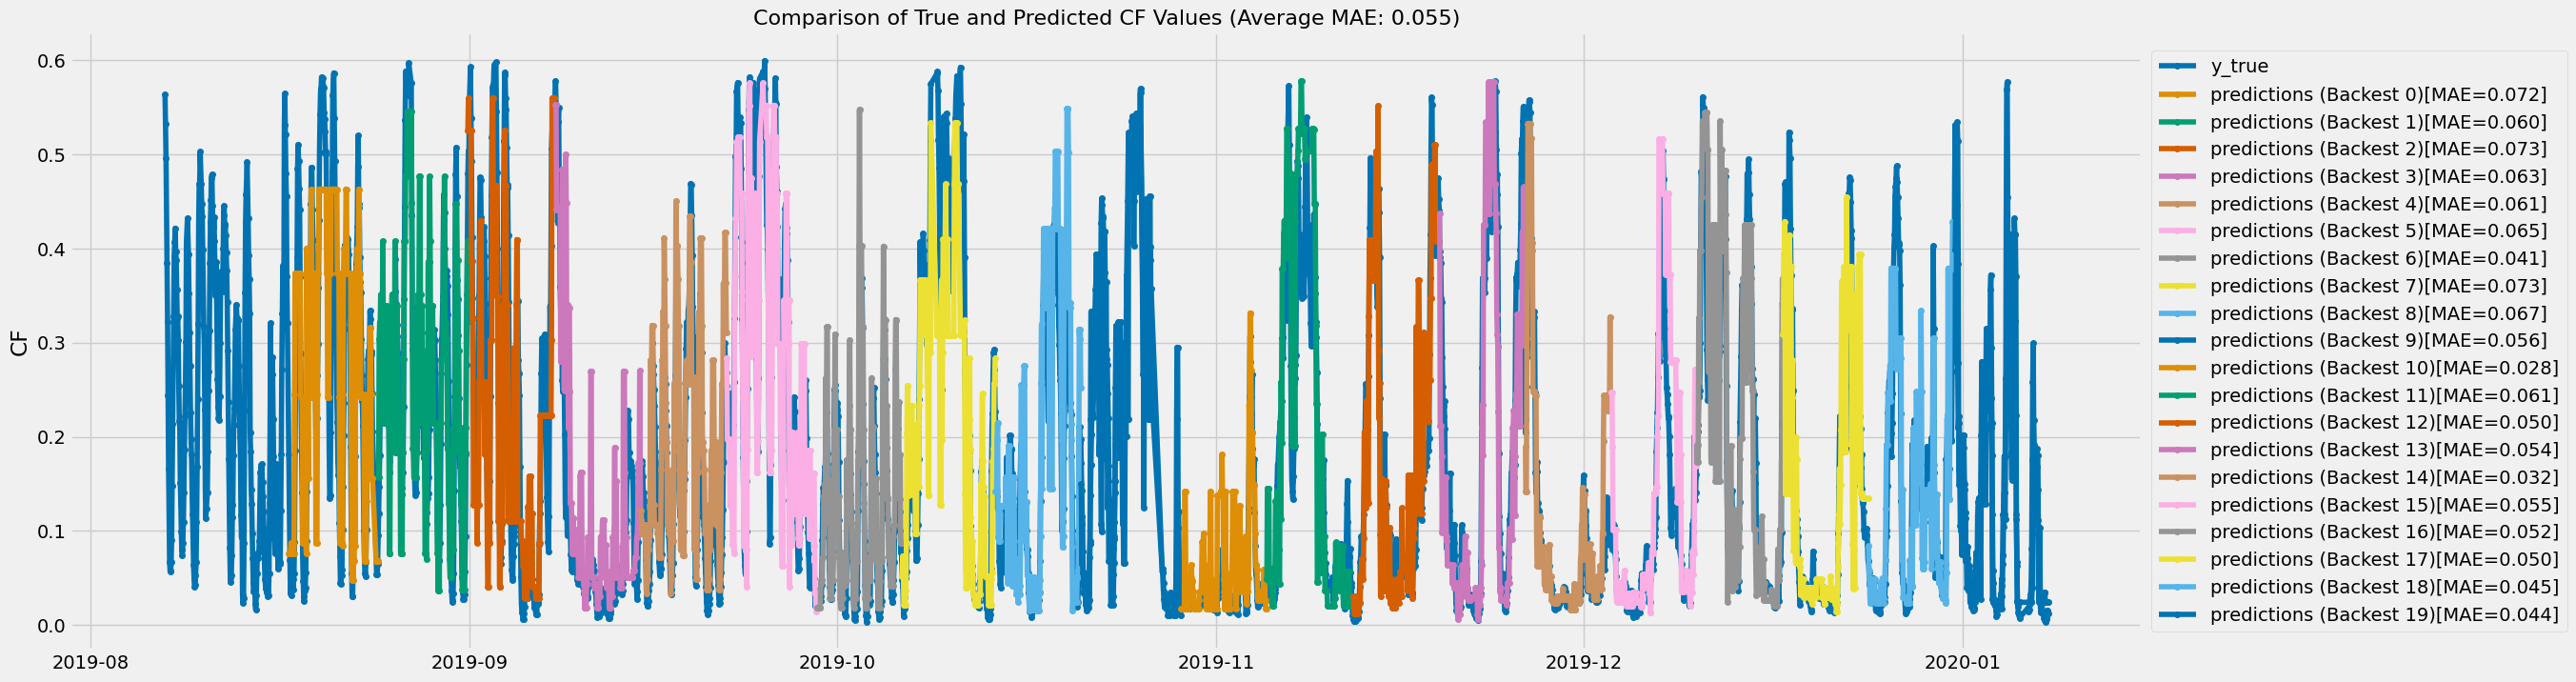

In [528]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

fig_size = 25
n_splits = 20

tss = TimeSeriesSplit(n_splits=n_splits, test_size=24*7, gap=24)
df = df.sort_index()

fold = 0
fold_results_dict = {}
for train_idx, val_idx in tss.split(df): # note: tss is a generator
    print(f"fold: {fold}")
    train = df.iloc[train_idx] # train_idx: list of indices
    test = df.iloc[val_idx] # val_idx: list of indices
    print(f"size of train set: {train.shape}")
    print(f"size of test set: {test.shape}")
    
    # Train model for wind variable predictions
    # decision_tree = DecisionTreeRegressor(
    #     random_state=42
    # )
    decision_tree = best_dtree
    X_train = train[list_wind_predictors]
    y_train = train[[response_var]]
    X_test = test[list_wind_predictors]
    y_test = test[[response_var]]
    
    decision_tree.fit(X_train, y_train)
#    y_train_pred_wind = decision_tree.predict(X_train)
    y_test_pred_wind = decision_tree.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred_wind)
    
    y_pred = y_test_pred_wind

    
    fold_results_dict[fold] = {
#        'predictions_via_wind_data': pd.Series(y_test_pred_wind, index=X_test.index),
        'predictions': pd.Series(y_pred, index=X_test.index),
#        'mae_wind_tree': test_mae,
        # 'decision_tree_wind_tree': decision_tree,
#        'xgb_regressor_cf': reg,
        'mae_score': test_mae,
        
    }
    fold += 1


fig, ax = plot_series(
    y,
    fold_results_dict[0]['predictions'],
    fold_results_dict[1]['predictions'],
    fold_results_dict[2]['predictions'],
    fold_results_dict[3]['predictions'],
    fold_results_dict[4]['predictions'],
    fold_results_dict[5]['predictions'],
    fold_results_dict[6]['predictions'],
    fold_results_dict[7]['predictions'],
    fold_results_dict[8]['predictions'],
    fold_results_dict[9]['predictions'],
    fold_results_dict[10]['predictions'],
    fold_results_dict[11]['predictions'],
    fold_results_dict[12]['predictions'],
    fold_results_dict[13]['predictions'],
    fold_results_dict[14]['predictions'],
    fold_results_dict[15]['predictions'],
    fold_results_dict[16]['predictions'],
    fold_results_dict[17]['predictions'],
    fold_results_dict[18]['predictions'],
    fold_results_dict[19]['predictions'],
    
    labels=["y_true"] + ["predictions (Backest " + str(x) + ")" + f"[MAE={fold_results_dict[x]['mae_score']:.3f}]" for x in range(0, (20))]# ["predictions (Backest " + str(x) + ")" for x in range(1 + 5)]
    
)

list_cv_mae_scores = []
for key, value in fold_results_dict.items():
    # print(key, value)
    list_cv_mae_scores.append(fold_results_dict[key]['mae_score'])
print("Average MAE (From the Cross Validation Folds):", np.mean(list_cv_mae_scores))

fig.set_size_inches(25, 8)  # Change the figure size to 15 inches wide by 8 inches tall

ax.set_title(f'Comparison of True and Predicted CF Values (Average MAE: {np.mean(list_cv_mae_scores):.3f})', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  # Adjust the legend position
plt.show()  # Display the plot

Results for Wind Data Decision Tree:

- Test MAE: 0.047
- CV MAE (mean): 0.055

This optimized decision tree is doing a solid job of mapping the different measurements of wind to the hourly electricity output from a wind farm.

Here is the decision tree visualized, which is very helpful for model explainability/communicating with non-technical audiences due to its binary nature:

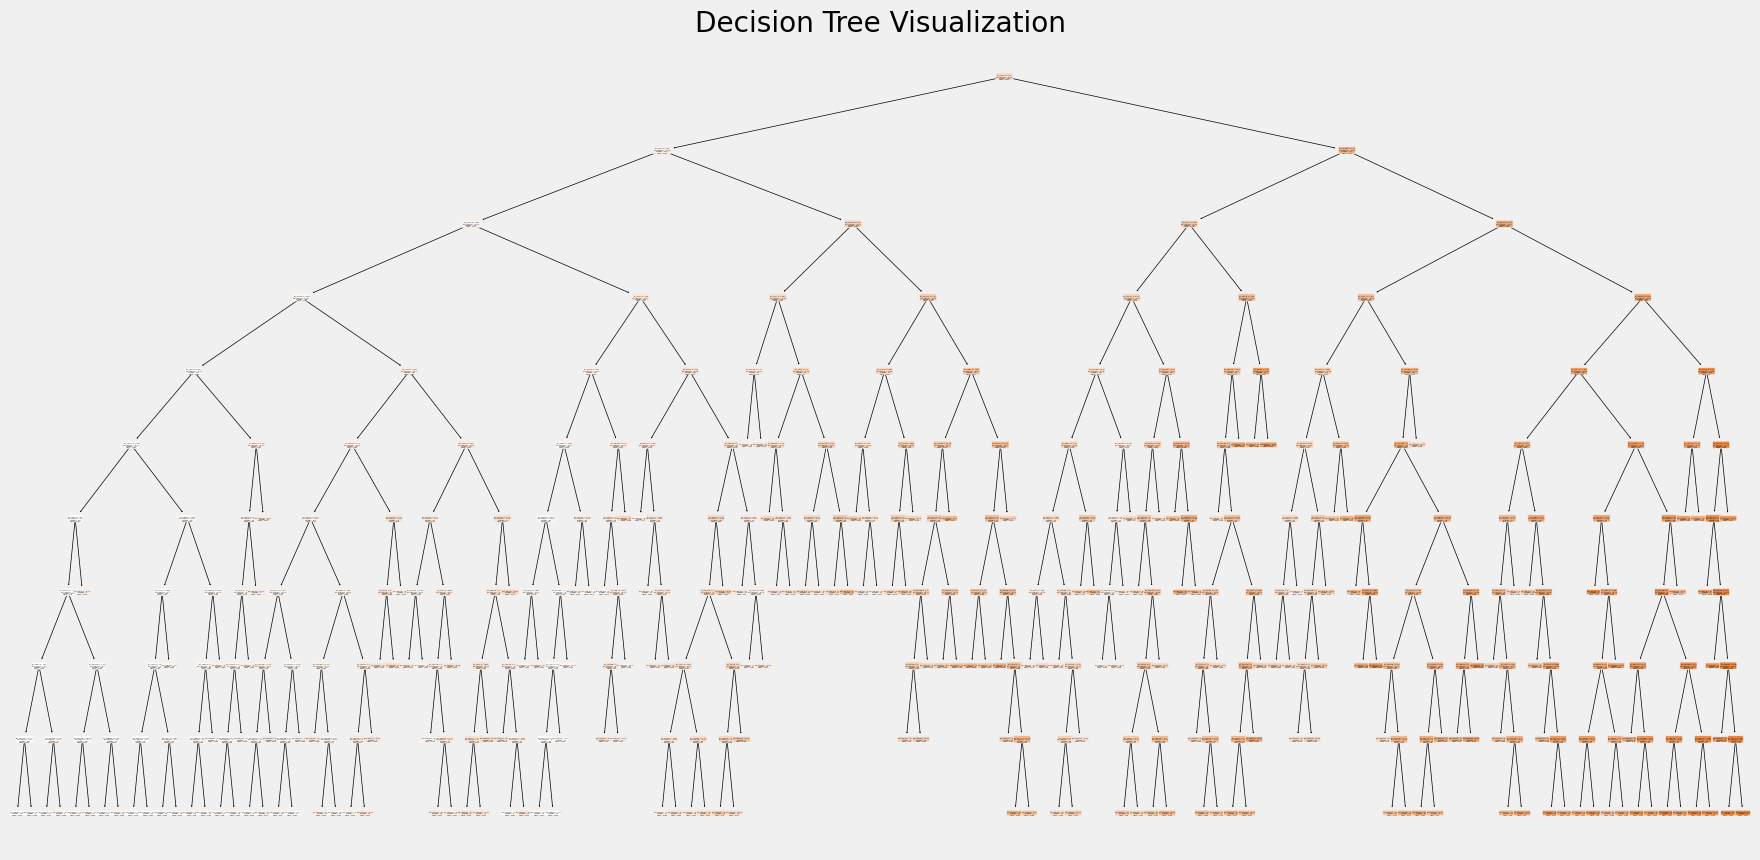

In [529]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))  # Set the figure size (width, height) in inches
plot_tree(best_dtree, filled=True, feature_names=list(X.columns), rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


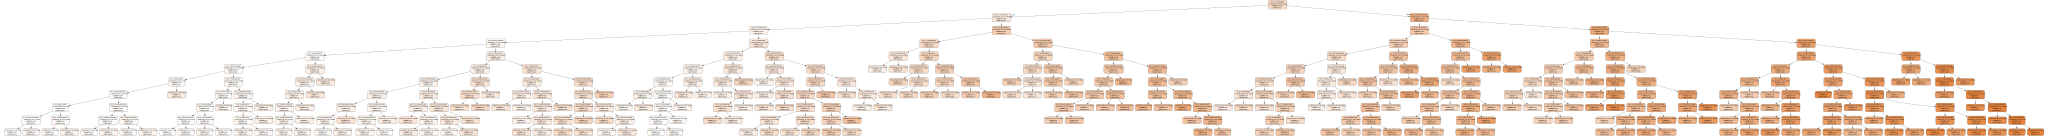

In [530]:
from sklearn.tree import export_graphviz
import graphviz

# Export as dot file
dot_data = export_graphviz(best_dtree, out_file=None, 
                           feature_names=X.columns,
                           filled=True, rounded=True,  
                           special_characters=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph


## More Feature Engineering and EDA

Looking at features that can be derived from dates:

In [531]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    # Ensure the index is of datetime type
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    # df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek # 0=Monday, 6=Sunday
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    # Add holidays
    df = add_holiday_flags(df, country='US')
    return df

In [532]:
# df = df[response_var].to_frame()

df = create_features(df)

df.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
2019-08-07 02:00:00  0.564094        9.04        7.39        6.21        8.98   
2019-08-07 03:00:00  0.532721        8.78        7.49        6.43        8.84   
2019-08-07 04:00:00  0.495608        8.23        6.88        6.81        8.52   
2019-08-07 06:00:00  0.384439        6.97        5.65        7.22        7.39   
2019-08-07 07:00:00  0.322181        6.36        5.15        7.24        6.63   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
2019-08-07 02:00:00        7.78        1.98        2.62        0.92   
2019-08-07 03:00:00        7.82        1.33        2.43        0.68   
2019-08-07 04:00:00        6.65        1.64        2.45        0.59   
2019-08-07 06:00:00        6.06        1.76        1.87        0.45   
2019-08-07 07:00:00        5.49        1.56        1.61        0.41   

                     WS_1366338  ...  hour  dayofweek  quarter  month  year  \
2019-08-07 02:00:00        7.55  ...     2          2        3      8  2019   
2019-08-07 03:00:00        7.53  ...     3          2        3      8  2019   
2019-08-07 04:00:00        6.40  ...     4          2        3      8  2019   
2019-08-07 06:00:00        6.30  ...     6          2        3      8  2019   
2019-08-07 07:00:00        5.75  ...     7          2        3      8  2019   

                     dayofyear  dayofmonth  weekofyear  is_holiday  \
2019-08-07 02:00:00        219           7          32           0   
2019-08-07 03:00:00        219           7          32           0   
2019-08-07 04:00:00        219           7          32           0   
2019-08-07 06:00:00        219           7          32           0   
2019-08-07 07:00:00        219           7          32           0   

                     holiday_name  
2019-08-07 02:00:00          None  
2019-08-07 03:00:00          None  
2019-08-07 04:00:00          None  
2019-08-07 06:00:00          None  
2019-08-07 07:00:00          None  

[5 rows x 123 columns]

In [533]:
list_date_predictors = [x for x in df.columns if x not in list_wind_predictors + [response_var] + ['prediction_wind_decision_tree']]

list_date_predictors

['hour',
 'dayofweek',
 'quarter',
 'month',
 'year',
 'dayofyear',
 'dayofmonth',
 'weekofyear',
 'is_holiday',
 'holiday_name']

## Visualize our Feature / Target Relationship

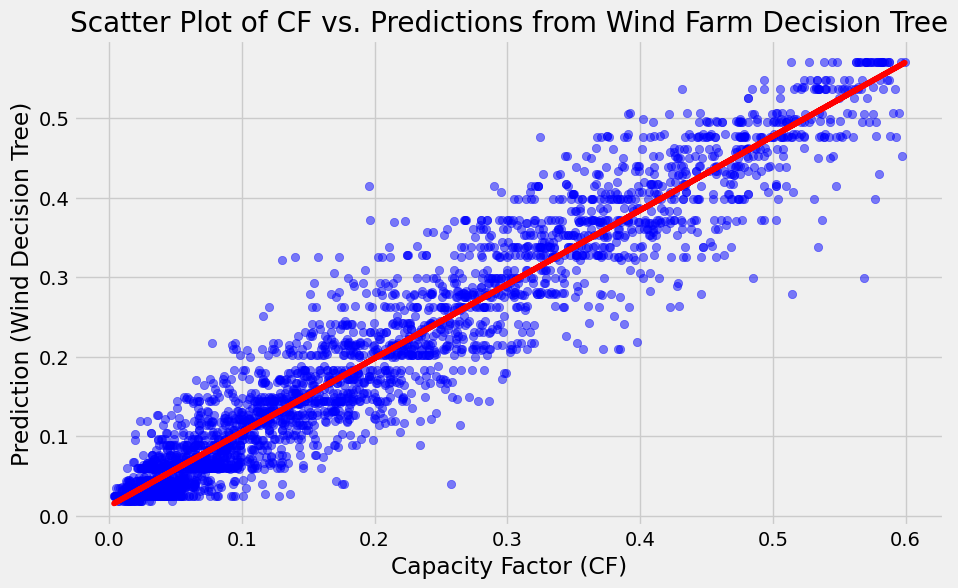

In [534]:
y_pred_all = best_dtree.predict(X)
# y_pred_all_df = pd.Series(y_pred_all, index=y.index)
# y_pred_all_df
df['prediction_wind_decision_tree'] = pd.Series(y_pred_all, index=y.index)

plt.figure(figsize=(10, 6))
plt.scatter(df['CF'], df['prediction_wind_decision_tree'], color='blue', alpha=0.5)
m, b = np.polyfit(df['CF'], df['prediction_wind_decision_tree'], 1)
plt.plot(df['CF'], m*df['CF'] + b, color='red')  # Add the line equation
plt.title('Scatter Plot of CF vs. Predictions from Wind Farm Decision Tree')
plt.xlabel('Capacity Factor (CF)')
plt.ylabel('Prediction (Wind Decision Tree)')
plt.grid(True)
plt.show()

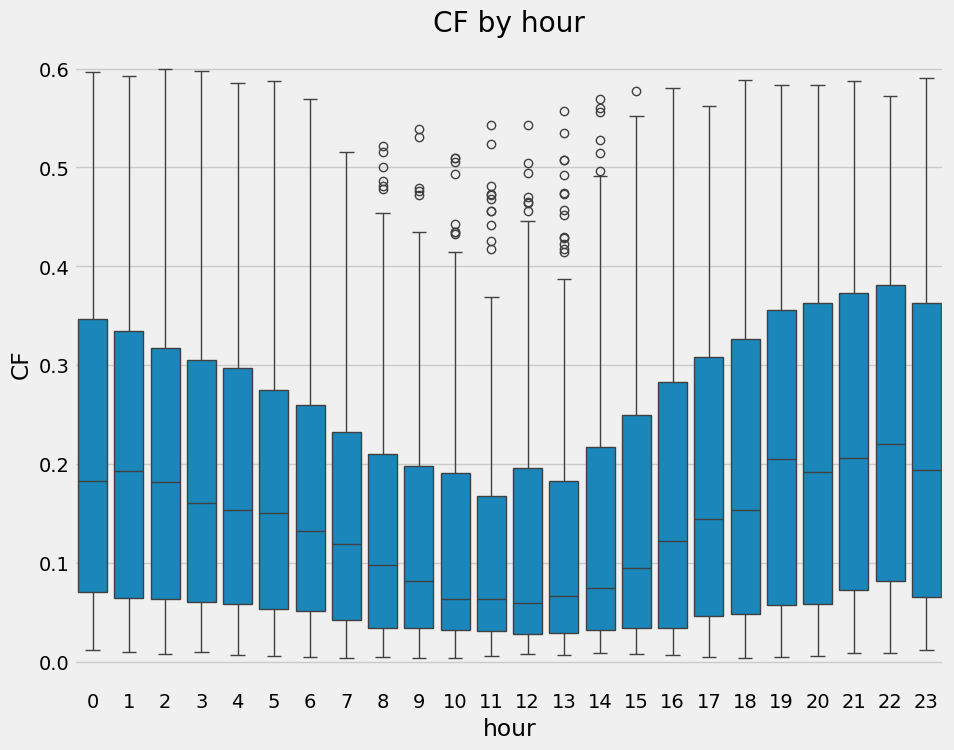

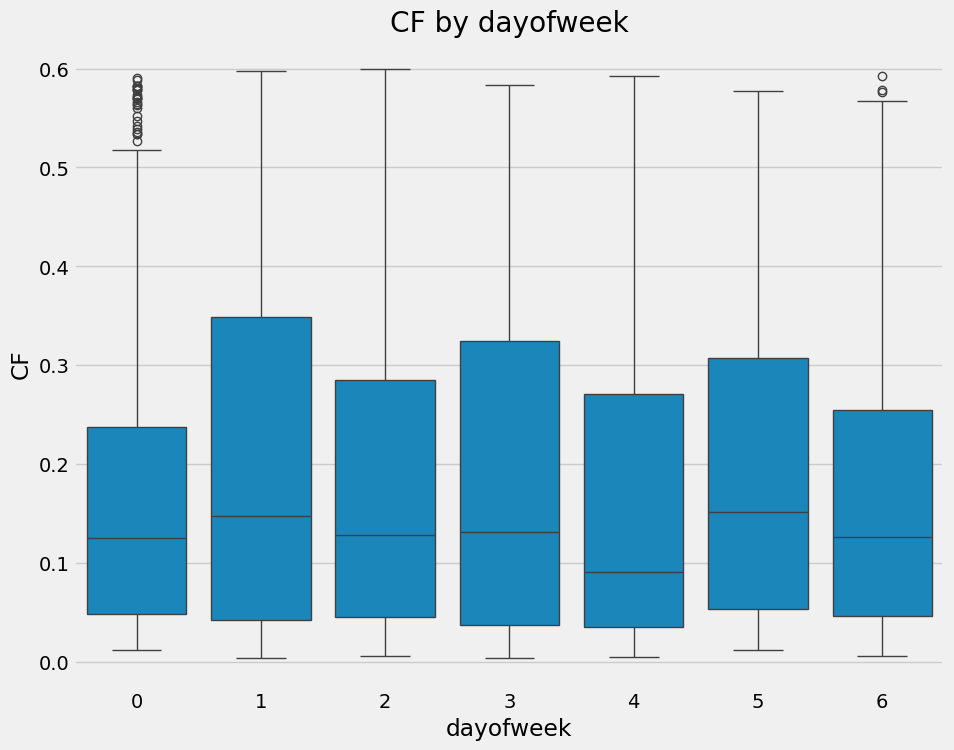

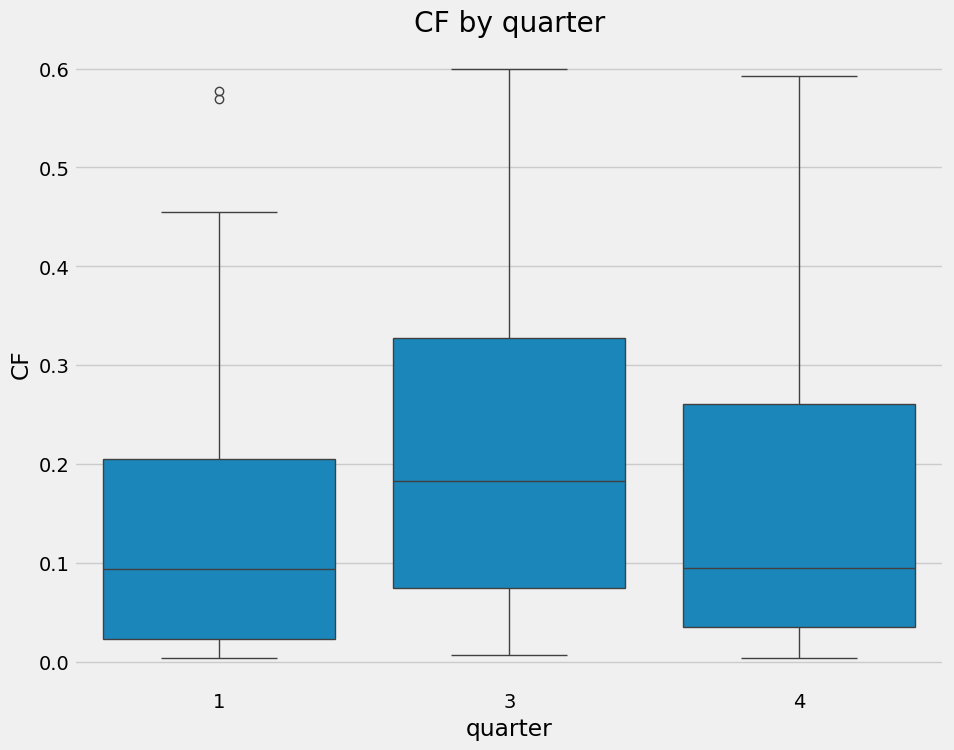

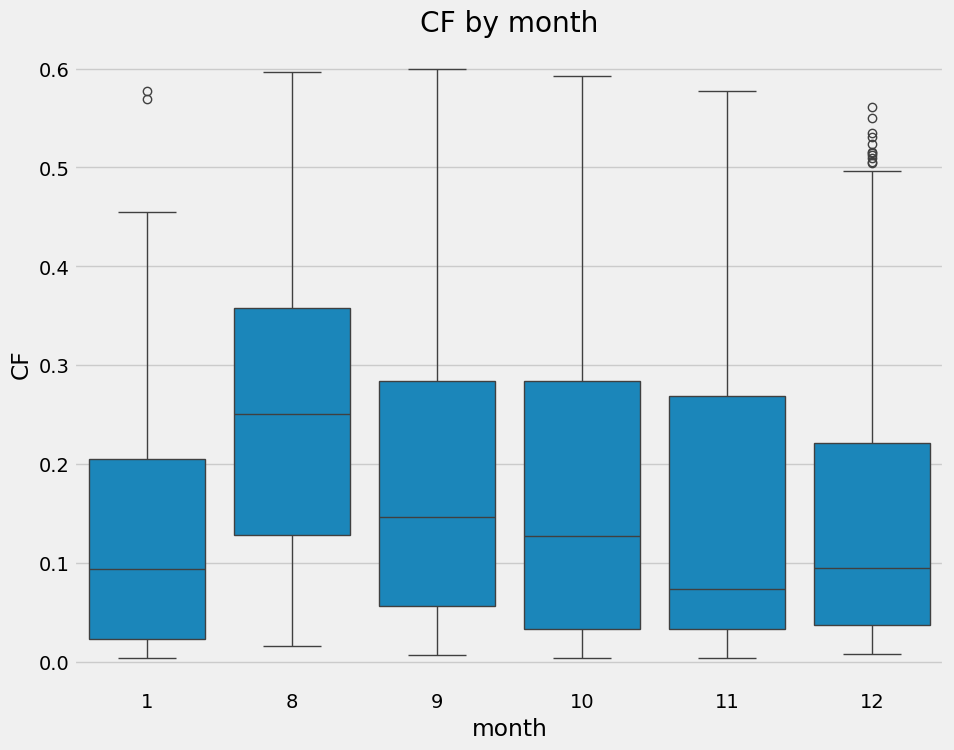

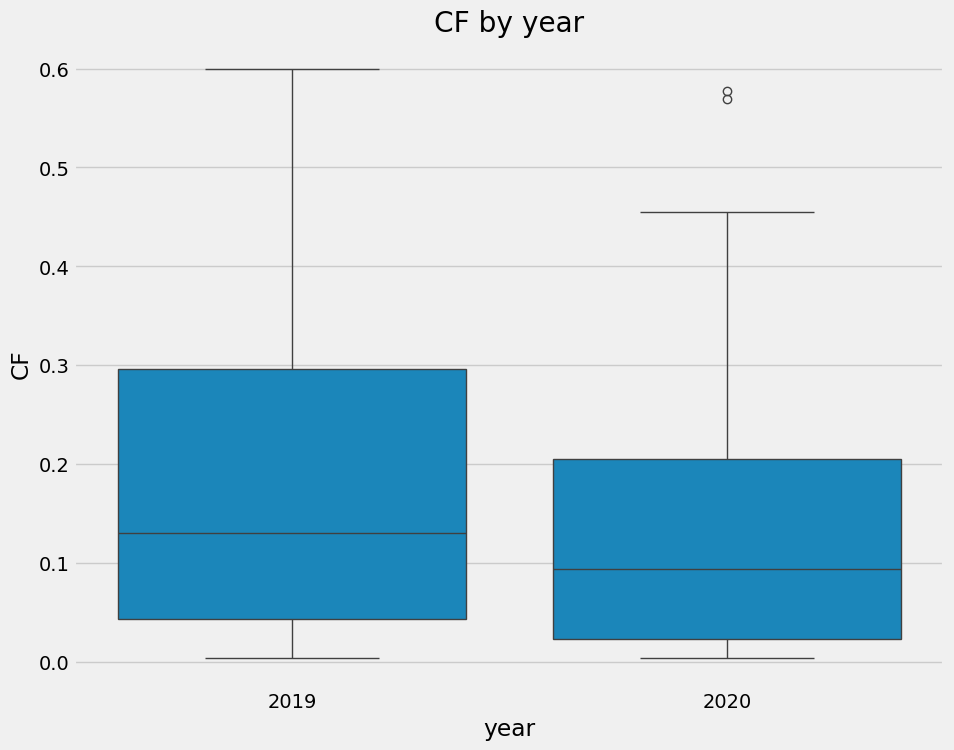

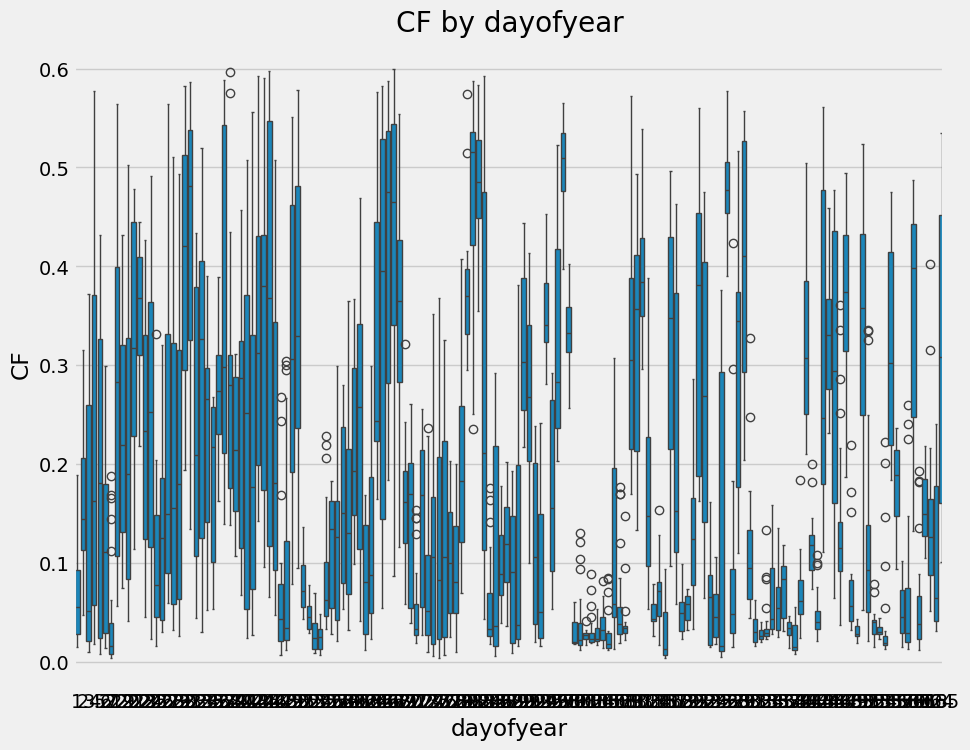

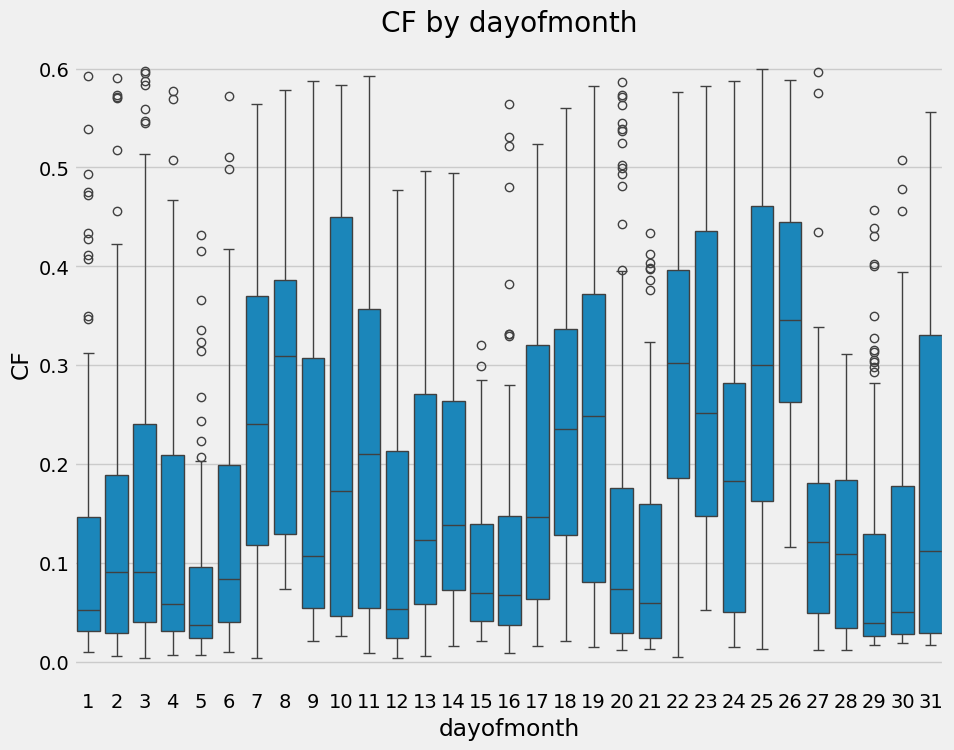

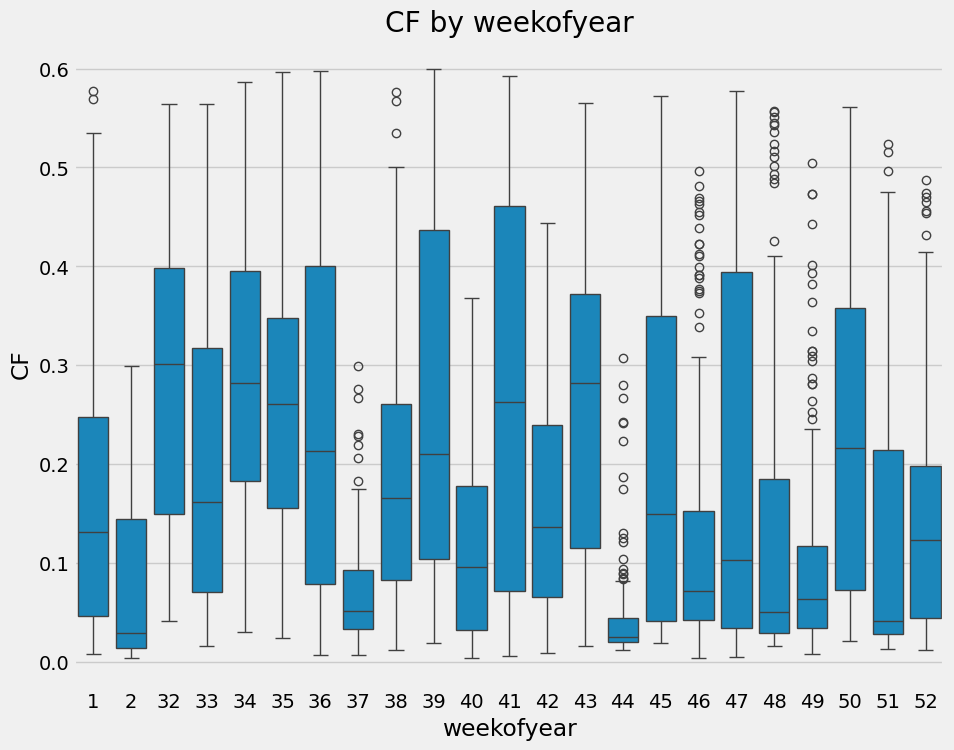

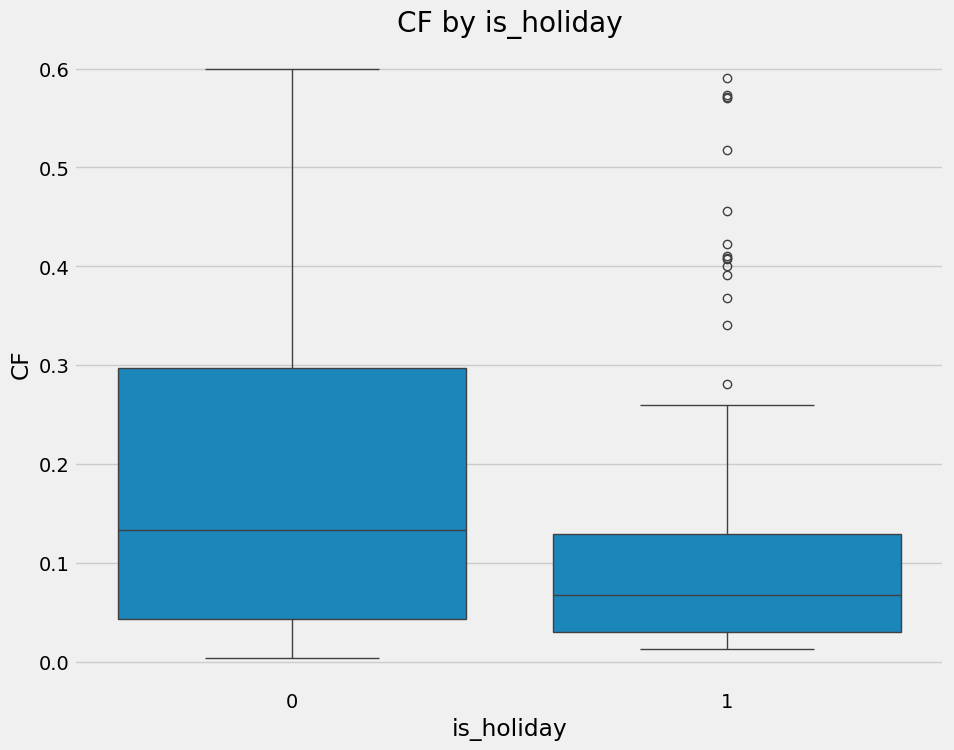

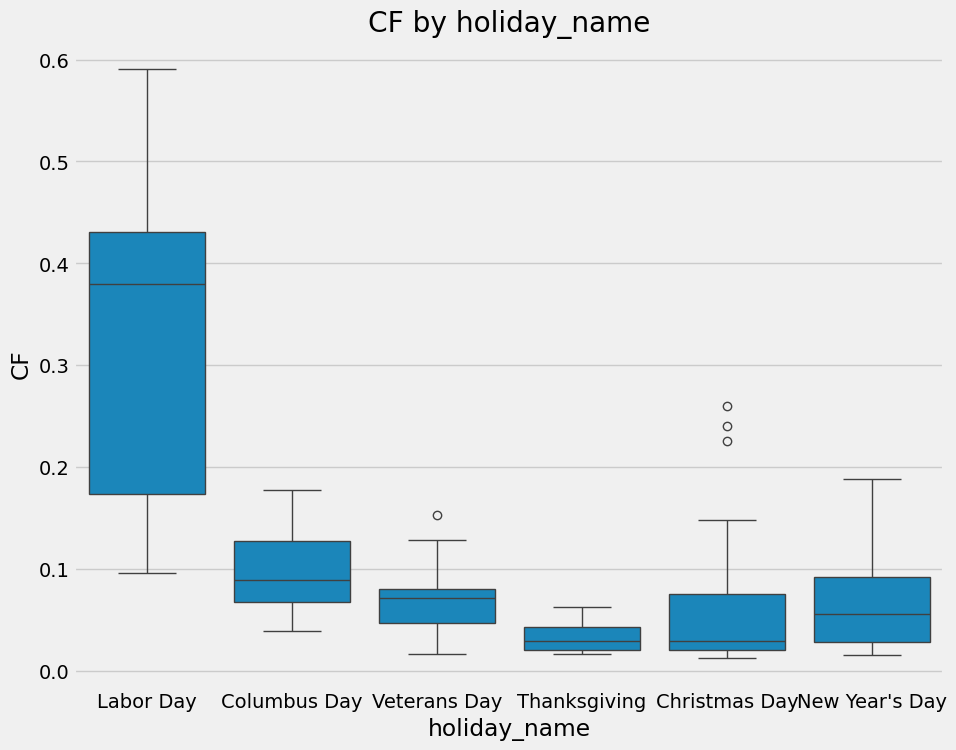

In [535]:
for column in df.columns:
    # if column not in [response_var, 'prediction_wind_decision_tree']:
    if column in list_date_predictors:
        predictor = column
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.boxplot(data=df, x=predictor, y=response_var)
        ax.set_title(f'{response_var} by {predictor}')
        plt.show()

Notable trends:
- prediction_wind_decision_tree: The wind farm decision tree does a pretty good job of mapping to the Average electricity output
- hour: Average electricity output appears to follow a trend where it is higher during the morning, dips during the afternoon, and increases again in the evening (this is intuitive with human behavior)
- quarter: Average electricity output appears to be higher in quarter 3 (unclear why)
- month: Average electricity output spikes in August
- year: Average electricity output is higher in 2019 (note: we just don't have much data on 2020 yet)
- dayofmonth: Average electricity output is quite erratic, I am also not sure if this is intuitive given that the day of the month shouldn't affect human behavior in the way that dayofweek may
- weekofyear: Similar story
- is_holiday: Average electricity output is noticeably lower on holidays
- holiday_name: Of the holiday's labor day bucks this trend with an extremely high Average electricity output

In [536]:
# get dummy variables for holiday
df = pd.get_dummies(df)
del df['is_holiday']

df.head()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
2019-08-07 02:00:00  0.564094        9.04        7.39        6.21        8.98   
2019-08-07 03:00:00  0.532721        8.78        7.49        6.43        8.84   
2019-08-07 04:00:00  0.495608        8.23        6.88        6.81        8.52   
2019-08-07 06:00:00  0.384439        6.97        5.65        7.22        7.39   
2019-08-07 07:00:00  0.322181        6.36        5.15        7.24        6.63   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
2019-08-07 02:00:00        7.78        1.98        2.62        0.92   
2019-08-07 03:00:00        7.82        1.33        2.43        0.68   
2019-08-07 04:00:00        6.65        1.64        2.45        0.59   
2019-08-07 06:00:00        6.06        1.76        1.87        0.45   
2019-08-07 07:00:00        5.49        1.56        1.61        0.41   

                     WS_1366338  ...  dayofyear  dayofmonth  weekofyear  \
2019-08-07 02:00:00        7.55  ...        219           7          32   
2019-08-07 03:00:00        7.53  ...        219           7          32   
2019-08-07 04:00:00        6.40  ...        219           7          32   
2019-08-07 06:00:00        6.30  ...        219           7          32   
2019-08-07 07:00:00        5.75  ...        219           7          32   

                     prediction_wind_decision_tree  \
2019-08-07 02:00:00                       0.539321   
2019-08-07 03:00:00                       0.539321   
2019-08-07 04:00:00                       0.457749   
2019-08-07 06:00:00                       0.360399   
2019-08-07 07:00:00                       0.278439   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2019-08-07 02:00:00                       False                      False   
2019-08-07 03:00:00                       False                      False   
2019-08-07 04:00:00                       False                      False   
2019-08-07 06:00:00                       False                      False   
2019-08-07 07:00:00                       False                      False   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2019-08-07 02:00:00                   False                        False   
2019-08-07 03:00:00                   False                        False   
2019-08-07 04:00:00                   False                        False   
2019-08-07 06:00:00                   False                        False   
2019-08-07 07:00:00                   False                        False   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2019-08-07 02:00:00                      False                      False  
2019-08-07 03:00:00                      False                      False  
2019-08-07 04:00:00                      False                      False  
2019-08-07 06:00:00                      False                      False  
2019-08-07 07:00:00                      False                      False  

[5 rows x 128 columns]

Before ML modeling, we need to make sure to have a true hourly dataset ie. a row of data at each hourly interval.

In [537]:
time_diffs = df.index.to_series().diff().unique()
print(time_diffs)

<TimedeltaArray>
[              NaT, '0 days 01:00:00', '0 days 02:00:00', '0 days 03:00:00',
 '0 days 07:00:00', '0 days 05:00:00', '0 days 12:00:00', '0 days 04:00:00',
 '0 days 22:00:00', '0 days 17:00:00']
Length: 10, dtype: timedelta64[ns]


The only differences between rows of data should be NA (beginning and end), and 1 hour (all data in between), so this is something we need to fix.

In [538]:
import pandas as pd

def ensure_hourly_frequency(df):
    """
    Reindexes a DataFrame to ensure it has an hourly frequency, filling any missing timestamps.

    This function calculates the minimum and maximum datetime indices of the DataFrame, 
    creates a new DateTimeIndex with hourly intervals within this range, and reindexes 
    the DataFrame using this hourly index. Missing data points are forward-filled to avoid data leakage.

    Parameters:
    df (pd.DataFrame): DataFrame with a DateTimeIndex that needs to be set to a regular hourly frequency.

    Returns:
    pd.DataFrame: The reindexed DataFrame with hourly frequency, where missing data points have been forward-filled.
    """
    # Calculate the start and end of the DataFrame's index
    start = df.index.min()
    end = df.index.max()
    print(start, end)

    # Create a full hourly DateTimeIndex from start to end
    full_index = pd.date_range(start=start, end=end, freq='H')

    # Reindex the DataFrame to this new index, forward filling missing values
    # df = df.reindex(full_index, method='ffill')
    df = df.reindex(full_index, method=None)

    return df

df = ensure_hourly_frequency(df=df)


2019-08-07 02:00:00 2020-01-07 23:00:00


In [539]:
time_diffs = df.index.to_series().diff().unique()
print(time_diffs)

<TimedeltaArray>
[NaT, '0 days 01:00:00']
Length: 2, dtype: timedelta64[ns]


We just introduced NA into our dataset. Because we do not have prediction data for wind model for every timestamp, we are going to have to forward fill the values from the wind prediction model and the response variable (`CF`).

As you have seen during the EDA section, the data follows a daily/weekly trends, so I will try out using the past day's information first.

In [540]:
df.index

DatetimeIndex(['2019-08-07 02:00:00', '2019-08-07 03:00:00',
               '2019-08-07 04:00:00', '2019-08-07 05:00:00',
               '2019-08-07 06:00:00', '2019-08-07 07:00:00',
               '2019-08-07 08:00:00', '2019-08-07 09:00:00',
               '2019-08-07 10:00:00', '2019-08-07 11:00:00',
               ...
               '2020-01-07 14:00:00', '2020-01-07 15:00:00',
               '2020-01-07 16:00:00', '2020-01-07 17:00:00',
               '2020-01-07 18:00:00', '2020-01-07 19:00:00',
               '2020-01-07 20:00:00', '2020-01-07 21:00:00',
               '2020-01-07 22:00:00', '2020-01-07 23:00:00'],
              dtype='datetime64[ns]', length=3694, freq='H')

In [541]:
print(f"number of NA values: {df['CF'].isna().sum()}")
# print(f"number of NA values: {df['prediction_wind_decision_tree'].isna().sum()}")

number of NA values: 102


In [542]:
# grabbing some indices to check how they were filled
indices_list = df[df['CF'].isna()].index
print(len(indices_list))

102


In [543]:
def custom_ffill(df, columns, hours_back):
    """
    Custom forward fill function that fills NaNs for multiple columns based on the value from 'hours_back' hours ago.
    Uses the datetime index directly.
    """
    time_delta = pd.Timedelta(hours=hours_back)
    
    for column in columns:
        # Apply a custom function to fill NaNs by looking 'hours_back'
        df[column] = df[column].combine_first(
            df.index.to_series().apply(lambda dt: df.at[dt - time_delta, column] if (dt - time_delta) in df.index else np.nan)
        )
    
    return df

# Forward fill based on the last day (24 hours back)
df = custom_ffill(df, list(df.columns), 24)


In [544]:
# Ensuring a value from before was filled with yesterday's value
idx = indices_list[25]
print(idx)

2019-08-29 06:00:00


In [545]:
time_delta = pd.Timedelta(hours=24)

idx_one_day_prior = idx - time_delta
print(idx_one_day_prior)

2019-08-28 06:00:00


In [546]:
# These should be the same data
df[df.index == idx]

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
2019-08-29 06:00:00  0.177012        7.44        6.48        7.04        6.48   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
2019-08-29 06:00:00        7.36        0.74        1.71        1.01   

                     WS_1366338  ...  dayofyear  dayofmonth  weekofyear  \
2019-08-29 06:00:00        7.92  ...      240.0        28.0          35   

                     prediction_wind_decision_tree  \
2019-08-29 06:00:00                       0.214242   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2019-08-29 06:00:00                       False                      False   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2019-08-29 06:00:00                   False                        False   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2019-08-29 06:00:00                      False                      False  

[1 rows x 128 columns]

In [547]:
# These should be the same data
df[df.index == idx_one_day_prior]

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
2019-08-28 06:00:00  0.177012        7.44        6.48        7.04        6.48   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
2019-08-28 06:00:00        7.36        0.74        1.71        1.01   

                     WS_1366338  ...  dayofyear  dayofmonth  weekofyear  \
2019-08-28 06:00:00        7.92  ...      240.0        28.0          35   

                     prediction_wind_decision_tree  \
2019-08-28 06:00:00                       0.214242   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2019-08-28 06:00:00                       False                      False   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2019-08-28 06:00:00                   False                        False   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2019-08-28 06:00:00                      False                      False  

[1 rows x 128 columns]

In [548]:
print(f"number of NA values: {df['CF'].isna().sum()}")
# print(f"number of NA values: {df['prediction_wind_decision_tree'].isna().sum()}")

number of NA values: 5


In [549]:
df[df['CF'].isna()]

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
2019-08-07 05:00:00 NaN         NaN         NaN         NaN         NaN   
2019-08-07 18:00:00 NaN         NaN         NaN         NaN         NaN   
2019-10-26 20:00:00 NaN         NaN         NaN         NaN         NaN   
2019-10-26 21:00:00 NaN         NaN         NaN         NaN         NaN   
2019-10-26 22:00:00 NaN         NaN         NaN         NaN         NaN   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
2019-08-07 05:00:00         NaN         NaN         NaN         NaN   
2019-08-07 18:00:00         NaN         NaN         NaN         NaN   
2019-10-26 20:00:00         NaN         NaN         NaN         NaN   
2019-10-26 21:00:00         NaN         NaN         NaN         NaN   
2019-10-26 22:00:00         NaN         NaN         NaN         NaN   

                     WS_1366338  ...  dayofyear  dayofmonth  weekofyear  \
2019-08-07 05:00:00         NaN  ...        NaN         NaN        <NA>   
2019-08-07 18:00:00         NaN  ...        NaN         NaN        <NA>   
2019-10-26 20:00:00         NaN  ...        NaN         NaN        <NA>   
2019-10-26 21:00:00         NaN  ...        NaN         NaN        <NA>   
2019-10-26 22:00:00         NaN  ...        NaN         NaN        <NA>   

                     prediction_wind_decision_tree  \
2019-08-07 05:00:00                            NaN   
2019-08-07 18:00:00                            NaN   
2019-10-26 20:00:00                            NaN   
2019-10-26 21:00:00                            NaN   
2019-10-26 22:00:00                            NaN   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2019-08-07 05:00:00                         NaN                        NaN   
2019-08-07 18:00:00                         NaN                        NaN   
2019-10-26 20:00:00                         NaN                        NaN   
2019-10-26 21:00:00                         NaN                        NaN   
2019-10-26 22:00:00                         NaN                        NaN   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2019-08-07 05:00:00                     NaN                          NaN   
2019-08-07 18:00:00                     NaN                          NaN   
2019-10-26 20:00:00                     NaN                          NaN   
2019-10-26 21:00:00                     NaN                          NaN   
2019-10-26 22:00:00                     NaN                          NaN   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2019-08-07 05:00:00                        NaN                        NaN  
2019-08-07 18:00:00                        NaN                        NaN  
2019-10-26 20:00:00                        NaN                        NaN  
2019-10-26 21:00:00                        NaN                        NaN  
2019-10-26 22:00:00                        NaN                        NaN  

[5 rows x 128 columns]

In [550]:
df.iloc[4:6]

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
2019-08-07 06:00:00  0.384439        6.97        5.65        7.22        7.39   
2019-08-07 07:00:00  0.322181        6.36        5.15        7.24        6.63   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
2019-08-07 06:00:00        6.06        1.76        1.87        0.45   
2019-08-07 07:00:00        5.49        1.56        1.61        0.41   

                     WS_1366338  ...  dayofyear  dayofmonth  weekofyear  \
2019-08-07 06:00:00        6.30  ...      219.0         7.0          32   
2019-08-07 07:00:00        5.75  ...      219.0         7.0          32   

                     prediction_wind_decision_tree  \
2019-08-07 06:00:00                       0.360399   
2019-08-07 07:00:00                       0.278439   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2019-08-07 06:00:00                       False                      False   
2019-08-07 07:00:00                       False                      False   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2019-08-07 06:00:00                   False                        False   
2019-08-07 07:00:00                   False                        False   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2019-08-07 06:00:00                      False                      False  
2019-08-07 07:00:00                      False                      False  

[2 rows x 128 columns]

In [551]:
# Fill with value from the hour beforehand if we don't have data from a week ago
# (ie. this value in the 7th row doesn't have anything to look back at, so we will use the previous hour's here)
if df['CF'].isna().sum() > 0:
    print(f"filled {df['CF'].isna().sum()} values via forward fill from last hour")
    df = df.fillna(method="ffill")

filled 5 values via forward fill from last hour


In [552]:
# 6th row was filled with info from row 5
df.iloc[4:6]

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
2019-08-07 06:00:00  0.384439        6.97        5.65        7.22        7.39   
2019-08-07 07:00:00  0.322181        6.36        5.15        7.24        6.63   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
2019-08-07 06:00:00        6.06        1.76        1.87        0.45   
2019-08-07 07:00:00        5.49        1.56        1.61        0.41   

                     WS_1366338  ...  dayofyear  dayofmonth  weekofyear  \
2019-08-07 06:00:00        6.30  ...      219.0         7.0          32   
2019-08-07 07:00:00        5.75  ...      219.0         7.0          32   

                     prediction_wind_decision_tree  \
2019-08-07 06:00:00                       0.360399   
2019-08-07 07:00:00                       0.278439   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2019-08-07 06:00:00                       False                      False   
2019-08-07 07:00:00                       False                      False   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2019-08-07 06:00:00                   False                        False   
2019-08-07 07:00:00                   False                        False   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2019-08-07 06:00:00                      False                      False  
2019-08-07 07:00:00                      False                      False  

[2 rows x 128 columns]

In [553]:
print(f"number of NA values: {df['CF'].isna().sum()}")
# print(f"number of NA values: {df['prediction_wind_decision_tree'].isna().sum()}")

number of NA values: 0


In [554]:
time_diffs = df.index.to_series().diff().unique()
print(time_diffs)

<TimedeltaArray>
[NaT, '0 days 01:00:00']
Length: 2, dtype: timedelta64[ns]


In [555]:
def prepare_data_for_sktime(df):
    """
    Converts numerical columns in the provided DataFrame to float64, 
    a format compatible with sktime forecasting models.

    This function iterates through each column in the DataFrame, checking the data type. 
    If the data type of a column is either UInt32 or Float64, it converts the column to float64.
    This ensures that all numerical data is in a consistent format expected by sktime models.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data to be prepared.

    Returns:
    pandas.DataFrame: The DataFrame with numerical columns converted to float64.
    
    Prints:
    The name of each column that is converted, along with its data type before and after conversion.
    """
    for column_name, column_dtype in zip(df.columns, df.dtypes):
        if column_dtype in ["UInt32", "Float64"]:
            print(column_name)
            print(f"before: {column_dtype}")
            df[column_name] = df[column_name].astype('float64')
            print(f"after: {df[column_name].dtype}")
    
    return df

def boolean_to_binary(dataframe):
    """
    Converts all boolean columns in a DataFrame to binary numeric format (0s and 1s).

    Args:
        dataframe (pd.DataFrame): The DataFrame containing boolean columns.

    Returns:
        pd.DataFrame: A DataFrame with boolean columns converted to binary numeric format.
    """
    # Copy the DataFrame to avoid altering the original data
    df = dataframe.copy()
    # Select boolean columns and convert them
    boolean_cols = df.select_dtypes(include=['bool']).columns
    df[boolean_cols] = df[boolean_cols].astype(int)
    return df

df = prepare_data_for_sktime(df)
df = boolean_to_binary(df)

print(df.dtypes)
df.head()

weekofyear
before: UInt32
after: float64
CF                             float64
WS_1133733                     float64
WS_1156770                     float64
WS_1156968                     float64
WS_1182195                     float64
                                ...   
holiday_name_Columbus Day        int32
holiday_name_Labor Day           int32
holiday_name_New Year's Day      int32
holiday_name_Thanksgiving        int32
holiday_name_Veterans Day        int32
Length: 128, dtype: object


CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
2019-08-07 02:00:00  0.564094        9.04        7.39        6.21        8.98   
2019-08-07 03:00:00  0.532721        8.78        7.49        6.43        8.84   
2019-08-07 04:00:00  0.495608        8.23        6.88        6.81        8.52   
2019-08-07 05:00:00  0.495608        8.23        6.88        6.81        8.52   
2019-08-07 06:00:00  0.384439        6.97        5.65        7.22        7.39   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
2019-08-07 02:00:00        7.78        1.98        2.62        0.92   
2019-08-07 03:00:00        7.82        1.33        2.43        0.68   
2019-08-07 04:00:00        6.65        1.64        2.45        0.59   
2019-08-07 05:00:00        6.65        1.64        2.45        0.59   
2019-08-07 06:00:00        6.06        1.76        1.87        0.45   

                     WS_1366338  ...  dayofyear  dayofmonth  weekofyear  \
2019-08-07 02:00:00        7.55  ...      219.0         7.0        32.0   
2019-08-07 03:00:00        7.53  ...      219.0         7.0        32.0   
2019-08-07 04:00:00        6.40  ...      219.0         7.0        32.0   
2019-08-07 05:00:00        6.40  ...      219.0         7.0        32.0   
2019-08-07 06:00:00        6.30  ...      219.0         7.0        32.0   

                     prediction_wind_decision_tree  \
2019-08-07 02:00:00                       0.539321   
2019-08-07 03:00:00                       0.539321   
2019-08-07 04:00:00                       0.457749   
2019-08-07 05:00:00                       0.457749   
2019-08-07 06:00:00                       0.360399   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2019-08-07 02:00:00                           0                          0   
2019-08-07 03:00:00                           0                          0   
2019-08-07 04:00:00                           0                          0   
2019-08-07 05:00:00                           0                          0   
2019-08-07 06:00:00                           0                          0   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2019-08-07 02:00:00                       0                            0   
2019-08-07 03:00:00                       0                            0   
2019-08-07 04:00:00                       0                            0   
2019-08-07 05:00:00                       0                            0   
2019-08-07 06:00:00                       0                            0   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2019-08-07 02:00:00                          0                          0  
2019-08-07 03:00:00                          0                          0  
2019-08-07 04:00:00                          0                          0  
2019-08-07 05:00:00                          0                          0  
2019-08-07 06:00:00                          0                          0  

[5 rows x 128 columns]

In [556]:
df.to_csv(os.path.join(INTER_DIR, "data_after_feature_engineering.csv"), index=True)


---

In [557]:
df = pd.read_csv(os.path.join(INTER_DIR, "data_after_feature_engineering.csv"), index_col=0)


In [558]:
print(df.index.dtype)
df.index = pd.to_datetime(df.index)
df.index.freq = 'H'
print(df.index.dtype)

object
datetime64[ns]


## Train / Test Split

The model that we measure MAE on and compare predictions with the test set will use a train/test split AND an expanding cross validation method.

The final model will be trained on all available seen data.

As for the expanding cross validation method, a visualization for this methodology will be plotted in this section right after the 80/20 train/test split.

Note: Could have used the sliding window approach, but because we don't have a ton of data, I will use the expanding window.

cutoff date: 2019-12-08 05:00:00


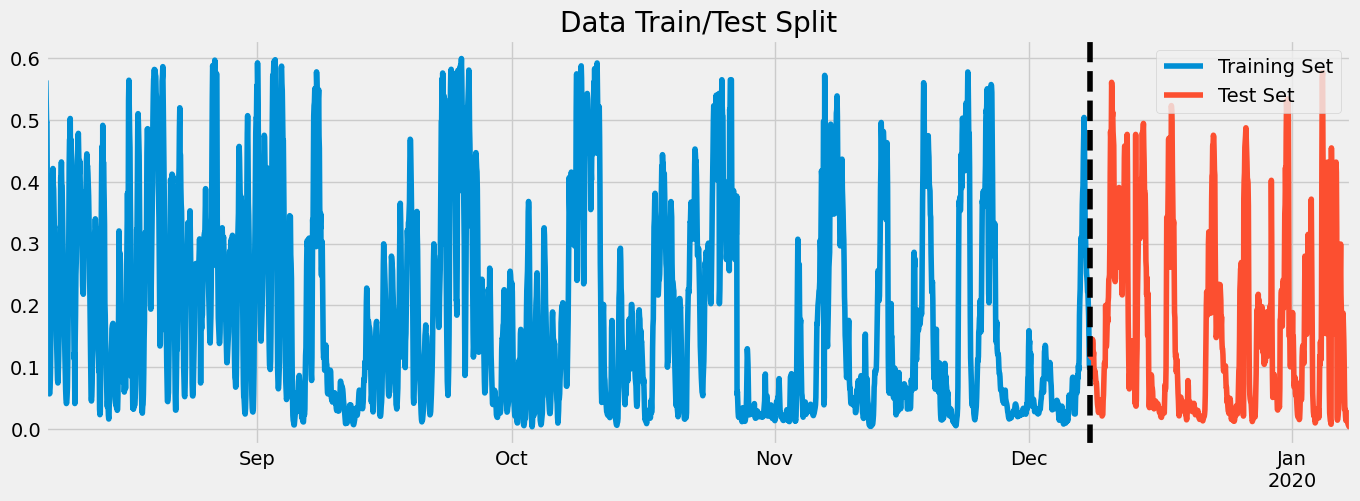

In [559]:
# 80/20 split
split_point = int(len(df) * 0.8)
cutoff_date_str = df.index[split_point]
print(f"cutoff date: {cutoff_date_str}")
train = df.loc[df.index < cutoff_date_str]
test = df.loc[df.index >= cutoff_date_str]

fig, ax = plt.subplots(figsize=(15, 5))
train[response_var].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test[response_var].plot(ax=ax, label='Test Set')
ax.axvline(cutoff_date_str, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9
fold: 10
fold: 11
fold: 12
fold: 13
fold: 14
fold: 15
fold: 16
fold: 17
fold: 18
fold: 19


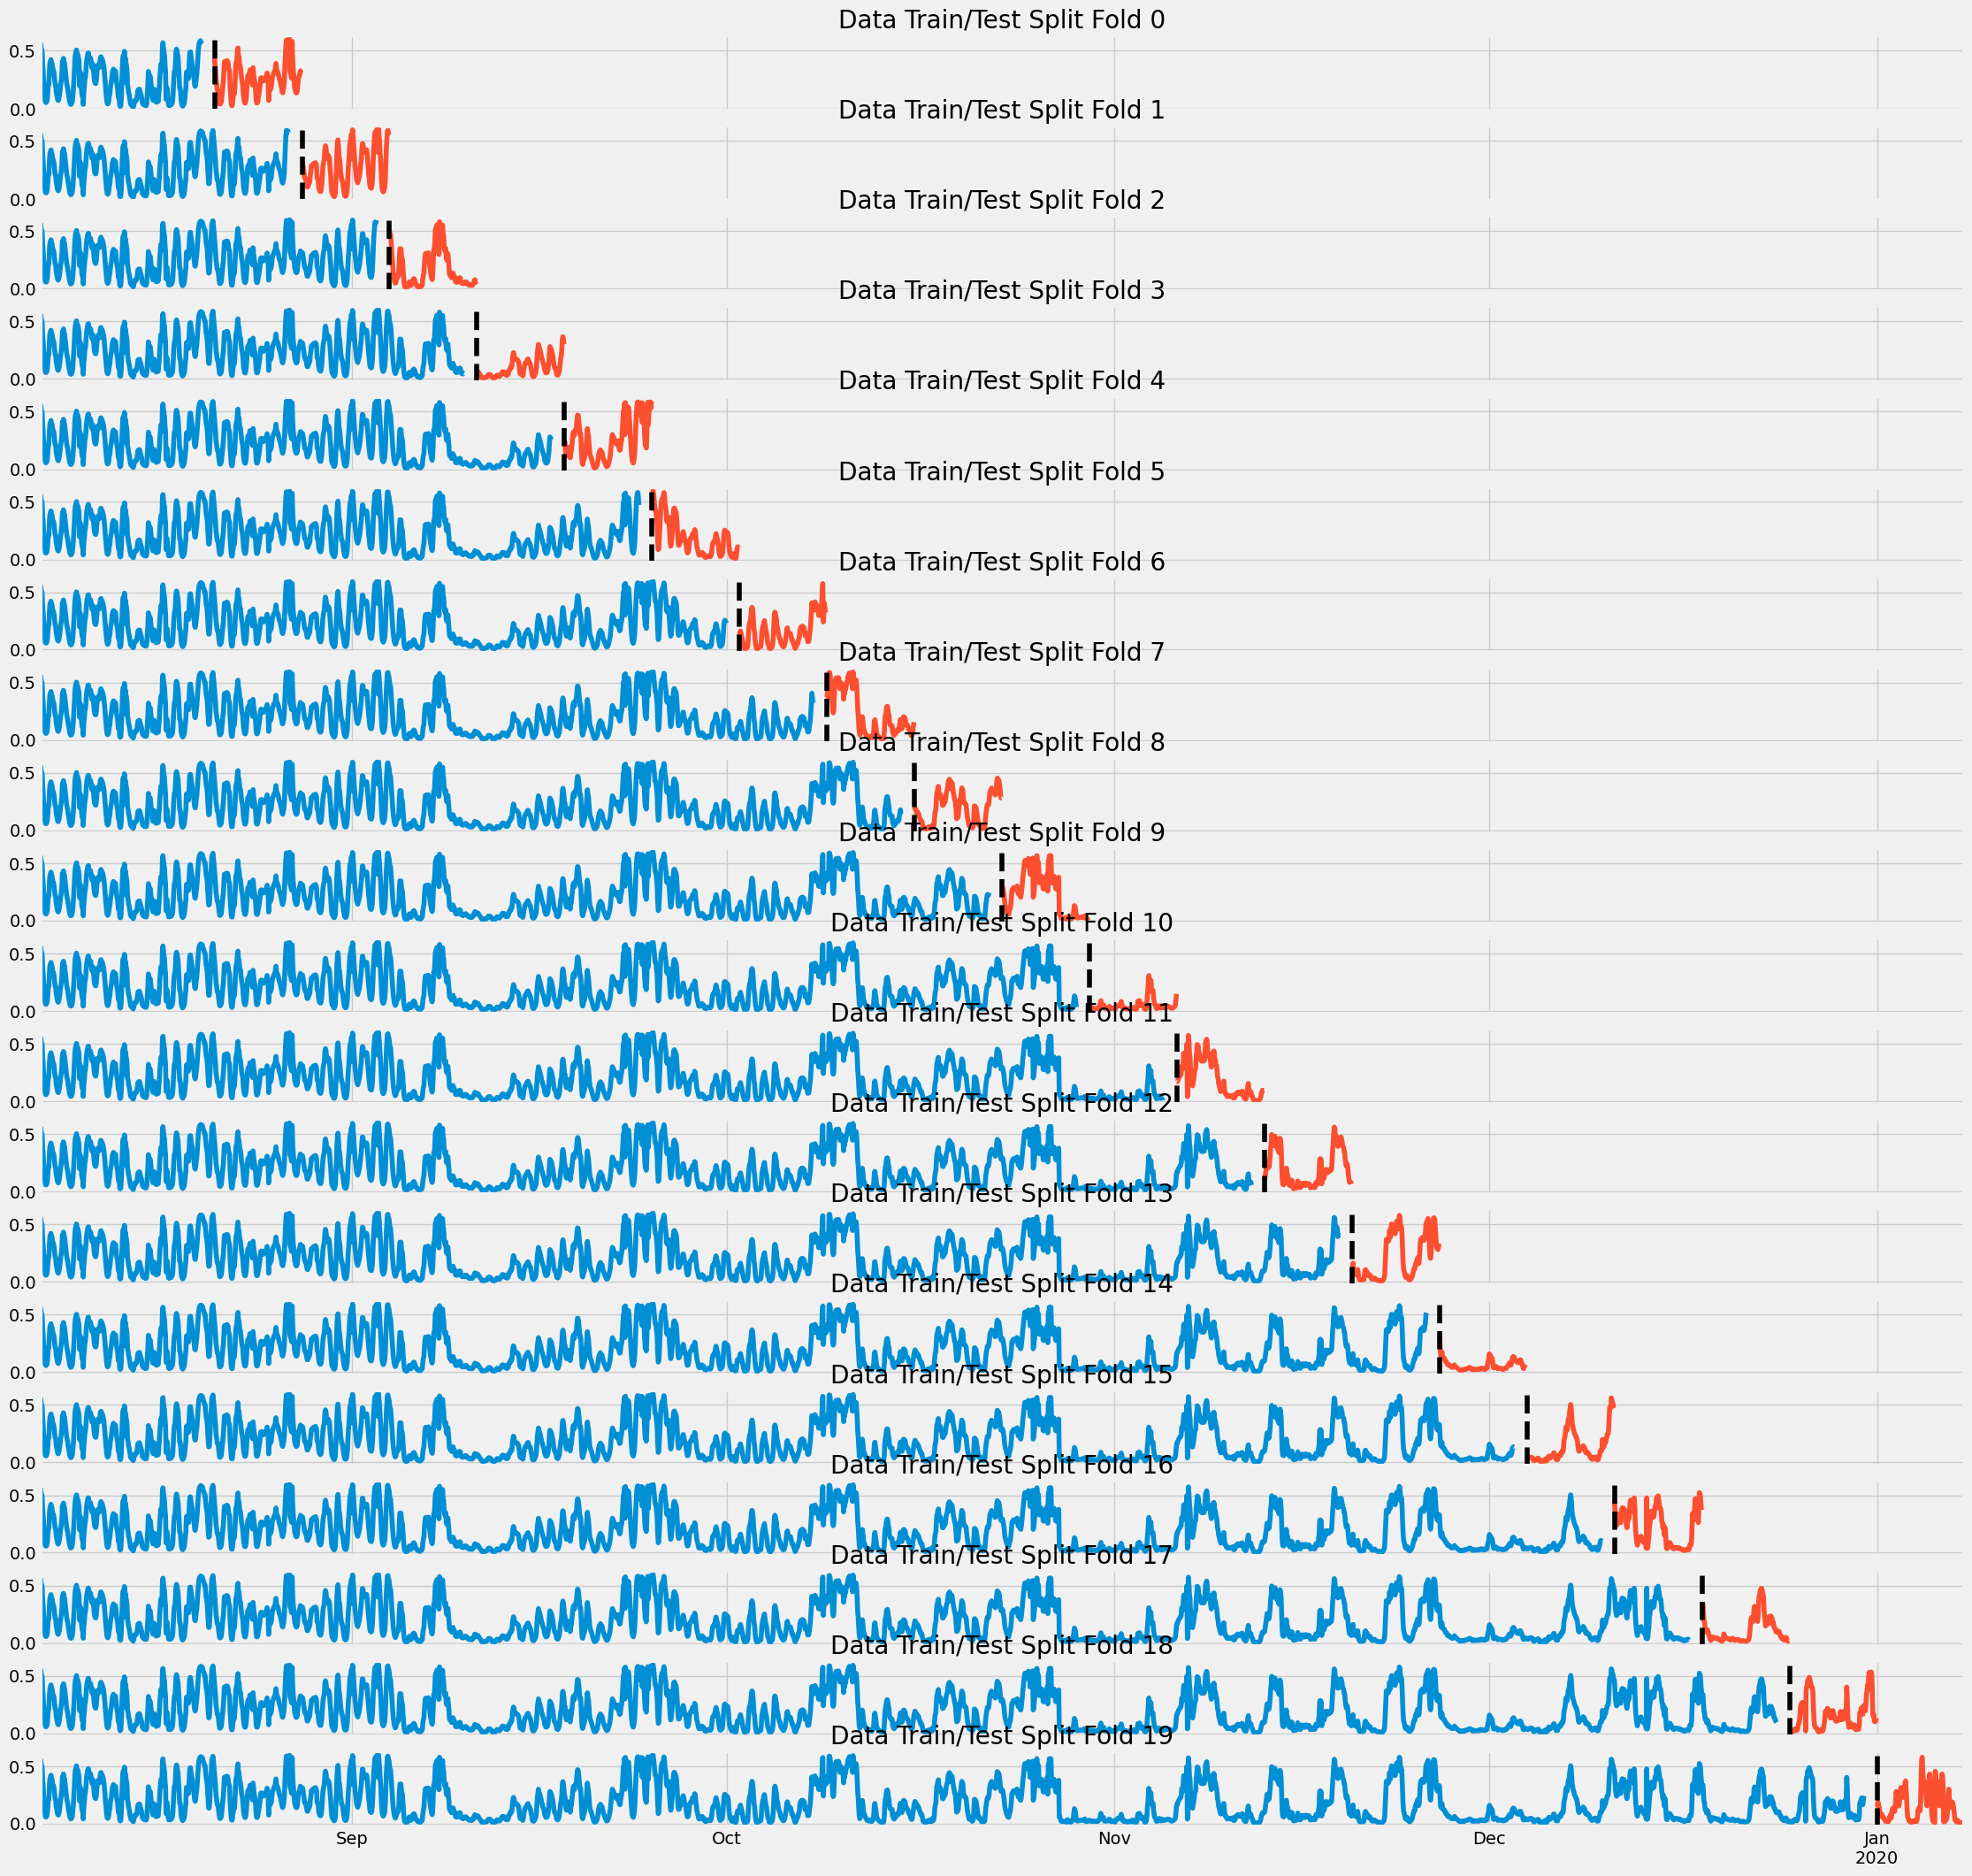

In [560]:
from sklearn.model_selection import TimeSeriesSplit

fig_size = 25
n_splits = 20

tss = TimeSeriesSplit(n_splits=n_splits, test_size=24*7, gap=24)
# n_splits: create 5 splits of data
# test_size: predict into the future 24*365 ie. hourly data for a week
# gap: leave 1 day between train/test(i assume for data leakage)
df = df.sort_index() # sort just in case

fig, axs = plt.subplots(n_splits, 1, figsize=(fig_size, fig_size), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df): # note: tss is a generator
    print(f"fold: {fold}")
    train = df.iloc[train_idx] # train_idx: list of indices
    test = df.iloc[val_idx] # val_idx: list of indices
    train[response_var].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test[response_var].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

See how the window (training data) expands in size as we move ahead in the folds of the data.

In [561]:
y = df[response_var].to_frame()
y = df[[response_var]]
y.head()

CF
2019-08-07 02:00:00  0.564094
2019-08-07 03:00:00  0.532721
2019-08-07 04:00:00  0.495608
2019-08-07 05:00:00  0.495608
2019-08-07 06:00:00  0.384439

In [562]:
X = df.drop(columns=[response_var], axis=1)
X.head()

WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
2019-08-07 02:00:00        9.04        7.39        6.21        8.98   
2019-08-07 03:00:00        8.78        7.49        6.43        8.84   
2019-08-07 04:00:00        8.23        6.88        6.81        8.52   
2019-08-07 05:00:00        8.23        6.88        6.81        8.52   
2019-08-07 06:00:00        6.97        5.65        7.22        7.39   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
2019-08-07 02:00:00        7.78        1.98        2.62        0.92   
2019-08-07 03:00:00        7.82        1.33        2.43        0.68   
2019-08-07 04:00:00        6.65        1.64        2.45        0.59   
2019-08-07 05:00:00        6.65        1.64        2.45        0.59   
2019-08-07 06:00:00        6.06        1.76        1.87        0.45   

                     WS_1366338  WS_1366351  ...  dayofyear  dayofmonth  \
2019-08-07 02:00:00        7.55        7.70  ...      219.0         7.0   
2019-08-07 03:00:00        7.53        7.77  ...      219.0         7.0   
2019-08-07 04:00:00        6.40        6.60  ...      219.0         7.0   
2019-08-07 05:00:00        6.40        6.60  ...      219.0         7.0   
2019-08-07 06:00:00        6.30        5.85  ...      219.0         7.0   

                     weekofyear  prediction_wind_decision_tree  \
2019-08-07 02:00:00        32.0                       0.539321   
2019-08-07 03:00:00        32.0                       0.539321   
2019-08-07 04:00:00        32.0                       0.457749   
2019-08-07 05:00:00        32.0                       0.457749   
2019-08-07 06:00:00        32.0                       0.360399   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2019-08-07 02:00:00                           0                          0   
2019-08-07 03:00:00                           0                          0   
2019-08-07 04:00:00                           0                          0   
2019-08-07 05:00:00                           0                          0   
2019-08-07 06:00:00                           0                          0   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2019-08-07 02:00:00                       0                            0   
2019-08-07 03:00:00                       0                            0   
2019-08-07 04:00:00                       0                            0   
2019-08-07 05:00:00                       0                            0   
2019-08-07 06:00:00                       0                            0   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2019-08-07 02:00:00                          0                          0  
2019-08-07 03:00:00                          0                          0  
2019-08-07 04:00:00                          0                          0  
2019-08-07 05:00:00                          0                          0  
2019-08-07 06:00:00                          0                          0  

[5 rows x 127 columns]

## Model Training and Testing

First, I want to look at a model that only used the wind data to make predictions. This can be our baseline model to compare newer/optimized versions with:


In [563]:
# Train/test performance
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
df = df.sort_index()

split_point = int(len(df) * 0.8)
cutoff_date_str = df.index[split_point]
print(f"cutoff date: {cutoff_date_str}")
train = df.loc[df.index < cutoff_date_str]
test = df.loc[df.index >= cutoff_date_str]


# Train model for wind variable predictions
decision_tree = DecisionTreeRegressor(
    random_state=42
)
X_train = train[list_wind_predictors]
y_train = train[[response_var]]
X_test = test[list_wind_predictors]
y_test = test[[response_var]]

decision_tree.fit(X_train, y_train)
y_train_pred_wind = decision_tree.predict(X_train)
y_test_pred_wind = decision_tree.predict(X_test)
# test_mse = mean_squared_error(y_test, y_test_pred_wind)
test_mae = mean_absolute_error(y_test, y_test_pred_wind)

# Train model to predict CF
X_train  = pd.Series(y_train_pred_wind, index=X_train.index)
X_test = pd.Series(y_test_pred_wind, index=X_test.index)


reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=1000,
                        early_stopping_rounds=50,
                        objective='reg:linear',
                        max_depth=3,
                        learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

y_pred = reg.predict(X_test)
# mse_train_test_split = np.sqrt(mean_squared_error(y_test, y_pred))
mae_train_test_split = mean_absolute_error(y_test, y_pred)

mae_train_test_split

cutoff date: 2019-12-08 05:00:00
[0]	validation_0-rmse:0.34609	validation_1-rmse:0.36341
[100]	validation_0-rmse:0.12743	validation_1-rmse:0.14979


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04699	validation_1-rmse:0.09140
[300]	validation_0-rmse:0.01738	validation_1-rmse:0.08219
[400]	validation_0-rmse:0.00650	validation_1-rmse:0.08160
[426]	validation_0-rmse:0.00505	validation_1-rmse:0.08164


0.055836536364917776

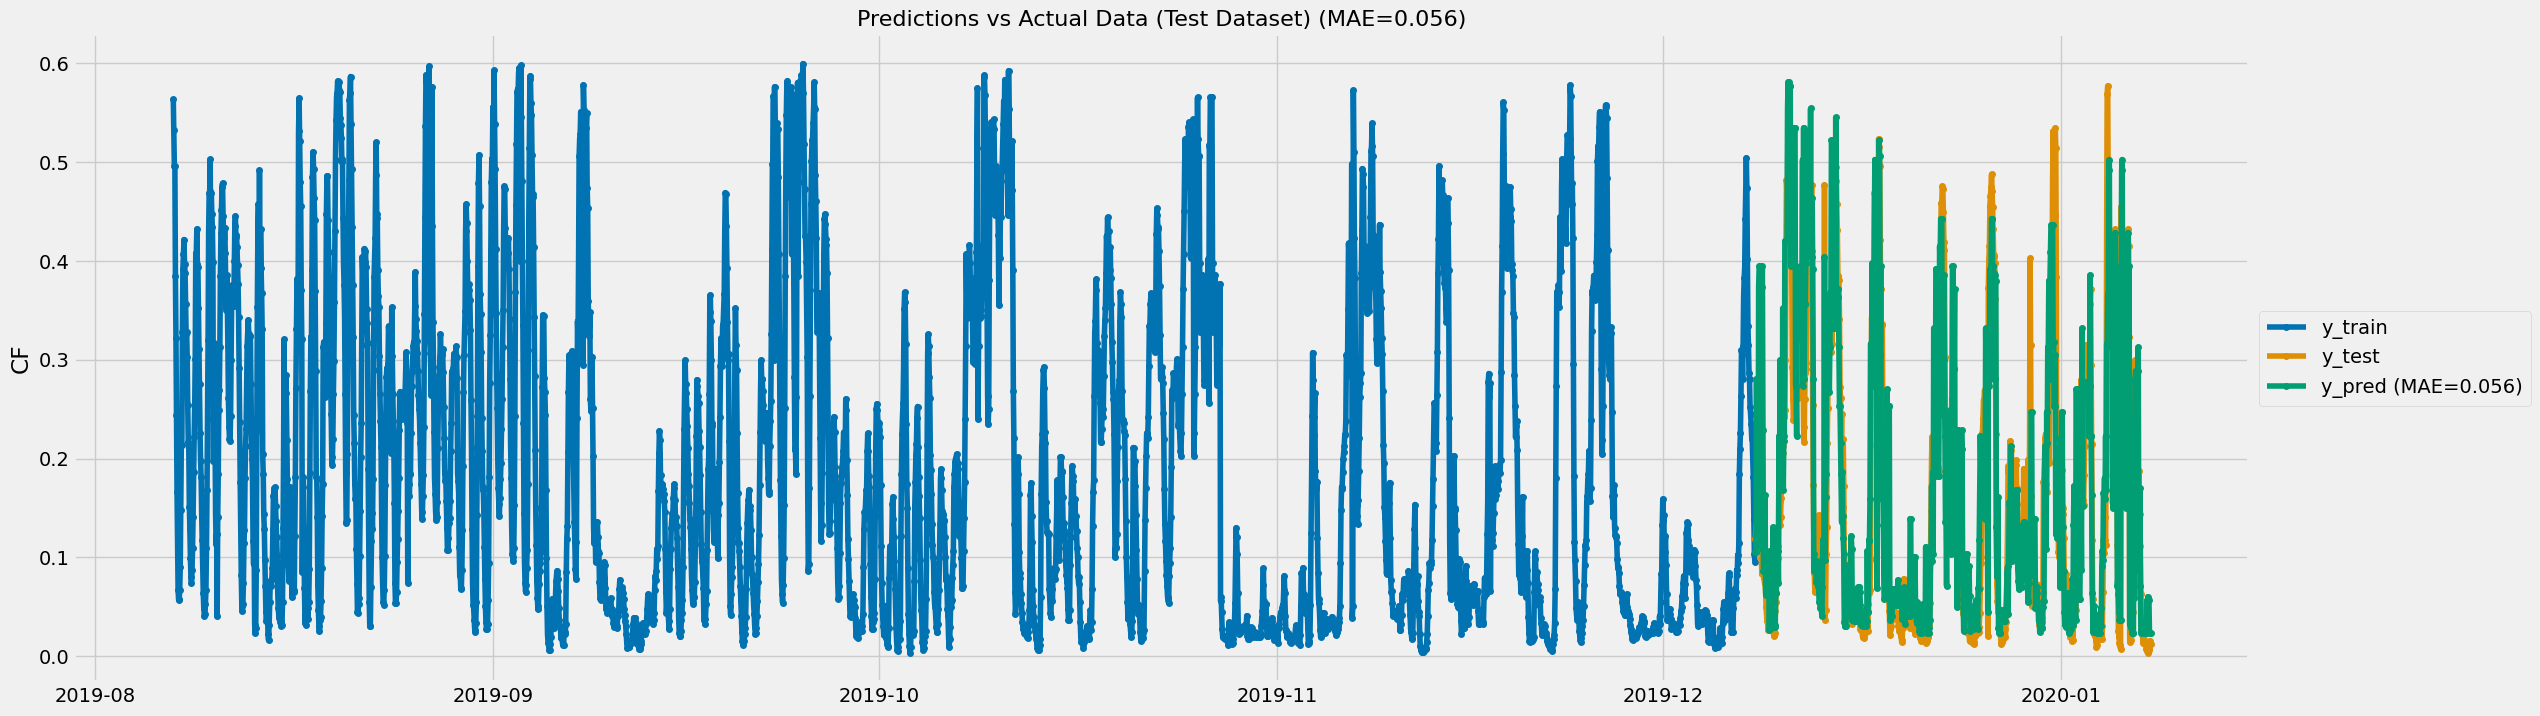

In [564]:
fig, ax = plot_series(y_train, y_test, pd.Series(y_pred, index=X_test.index), labels=['y_train', 'y_test', f'y_pred (MAE={mae_train_test_split:.3f})'])

fig.set_size_inches(25, 8)  # Change the figure size to 25 inches wide by 8 inches tall

ax.set_title(f'Predictions vs Actual Data (Test Dataset) (MAE={mae_train_test_split:.3f})', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  # Adjust the legend position
plt.show()

fold: 0
size of train set: (310, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.29617	validation_1-rmse:0.26996
[100]	validation_0-rmse:0.11117	validation_1-rmse:0.13379


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:37:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04192	validation_1-rmse:0.09885
[300]	validation_0-rmse:0.01596	validation_1-rmse:0.09208
[400]	validation_0-rmse:0.00625	validation_1-rmse:0.09086
[500]	validation_0-rmse:0.00271	validation_1-rmse:0.09060
[600]	validation_0-rmse:0.00156	validation_1-rmse:0.09051
[700]	validation_0-rmse:0.00127	validation_1-rmse:0.09049
[800]	validation_0-rmse:0.00120	validation_1-rmse:0.09049
[900]	validation_0-rmse:0.00119	validation_1-rmse:0.09048
[999]	validation_0-rmse:0.00119	validation_1-rmse:0.09048
fold: 1
size of train set: (478, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.28424	validation_1-rmse:0.27300
[100]	validation_0-rmse:0.10615	validation_1-rmse:0.12152


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:37:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.03979	validation_1-rmse:0.08789
[300]	validation_0-rmse:0.01502	validation_1-rmse:0.08501
[341]	validation_0-rmse:0.01011	validation_1-rmse:0.08522
fold: 2
size of train set: (646, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.28123	validation_1-rmse:0.36771
[100]	validation_0-rmse:0.10472	validation_1-rmse:0.19419


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:37:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.03911	validation_1-rmse:0.14334
[300]	validation_0-rmse:0.01470	validation_1-rmse:0.12990
[400]	validation_0-rmse:0.00564	validation_1-rmse:0.12602
[500]	validation_0-rmse:0.00236	validation_1-rmse:0.12475
[600]	validation_0-rmse:0.00131	validation_1-rmse:0.12432
[700]	validation_0-rmse:0.00107	validation_1-rmse:0.12416
[800]	validation_0-rmse:0.00103	validation_1-rmse:0.12410
[900]	validation_0-rmse:0.00102	validation_1-rmse:0.12408
[999]	validation_0-rmse:0.00102	validation_1-rmse:0.12407
fold: 3
size of train set: (814, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.29390	validation_1-rmse:0.40580
[100]	validation_0-rmse:0.10915	validation_1-rmse:0.17261


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04065	validation_1-rmse:0.09951
[300]	validation_0-rmse:0.01524	validation_1-rmse:0.08225
[400]	validation_0-rmse:0.00581	validation_1-rmse:0.07867
[500]	validation_0-rmse:0.00236	validation_1-rmse:0.07785
[600]	validation_0-rmse:0.00123	validation_1-rmse:0.07761
[700]	validation_0-rmse:0.00096	validation_1-rmse:0.07754
[800]	validation_0-rmse:0.00091	validation_1-rmse:0.07752
[900]	validation_0-rmse:0.00090	validation_1-rmse:0.07751
[999]	validation_0-rmse:0.00090	validation_1-rmse:0.07750
fold: 4
size of train set: (982, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.31872	validation_1-rmse:0.29613
[100]	validation_0-rmse:0.11801	validation_1-rmse:0.12854


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:37:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04379	validation_1-rmse:0.08709
[300]	validation_0-rmse:0.01632	validation_1-rmse:0.08146
[400]	validation_0-rmse:0.00616	validation_1-rmse:0.08133
[405]	validation_0-rmse:0.00588	validation_1-rmse:0.08134
fold: 5
size of train set: (1150, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.31904	validation_1-rmse:0.34218
[100]	validation_0-rmse:0.11800	validation_1-rmse:0.13678


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04374	validation_1-rmse:0.07964
[300]	validation_0-rmse:0.01629	validation_1-rmse:0.07138
[389]	validation_0-rmse:0.00683	validation_1-rmse:0.07134
fold: 6
size of train set: (1318, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.31753	validation_1-rmse:0.35824
[100]	validation_0-rmse:0.11736	validation_1-rmse:0.14580


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04347	validation_1-rmse:0.07917
[300]	validation_0-rmse:0.01617	validation_1-rmse:0.06415
[400]	validation_0-rmse:0.00609	validation_1-rmse:0.06156
[500]	validation_0-rmse:0.00244	validation_1-rmse:0.06110
[600]	validation_0-rmse:0.00124	validation_1-rmse:0.06101
[700]	validation_0-rmse:0.00096	validation_1-rmse:0.06099
[800]	validation_0-rmse:0.00091	validation_1-rmse:0.06099
[900]	validation_0-rmse:0.00090	validation_1-rmse:0.06098
[999]	validation_0-rmse:0.00090	validation_1-rmse:0.06098
fold: 7
size of train set: (1486, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.32624	validation_1-rmse:0.32796
[100]	validation_0-rmse:0.12046	validation_1-rmse:0.13615
[200]	validation_0-rmse:0.04456	validation_1-rmse:0.09923


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[283]	validation_0-rmse:0.01958	validation_1-rmse:0.09930
fold: 8
size of train set: (1654, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.32365	validation_1-rmse:0.33060
[100]	validation_0-rmse:0.11948	validation_1-rmse:0.13702


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04419	validation_1-rmse:0.09148
[300]	validation_0-rmse:0.01641	validation_1-rmse:0.08821
[323]	validation_0-rmse:0.01308	validation_1-rmse:0.08844
fold: 9
size of train set: (1822, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.32679	validation_1-rmse:0.32164
[100]	validation_0-rmse:0.12058	validation_1-rmse:0.12965


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04457	validation_1-rmse:0.07673
[300]	validation_0-rmse:0.01654	validation_1-rmse:0.06904
[391]	validation_0-rmse:0.00677	validation_1-rmse:0.06896
fold: 10
size of train set: (1990, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.32269	validation_1-rmse:0.45115
[100]	validation_0-rmse:0.11906	validation_1-rmse:0.17649


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:37:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04401	validation_1-rmse:0.07954
[300]	validation_0-rmse:0.01633	validation_1-rmse:0.05088
[400]	validation_0-rmse:0.00613	validation_1-rmse:0.04440
[500]	validation_0-rmse:0.00243	validation_1-rmse:0.04305
[600]	validation_0-rmse:0.00123	validation_1-rmse:0.04275
[700]	validation_0-rmse:0.00094	validation_1-rmse:0.04267
[800]	validation_0-rmse:0.00089	validation_1-rmse:0.04265
[900]	validation_0-rmse:0.00088	validation_1-rmse:0.04264
[999]	validation_0-rmse:0.00088	validation_1-rmse:0.04263
fold: 11
size of train set: (2158, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.33464	validation_1-rmse:0.34475
[100]	validation_0-rmse:0.12337	validation_1-rmse:0.13880
[200]	validation_0-rmse:0.04555	validation_1-rmse:0.08885


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[300]	validation_0-rmse:0.01688	validation_1-rmse:0.08470
[331]	validation_0-rmse:0.01243	validation_1-rmse:0.08508
fold: 12
size of train set: (2326, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.33527	validation_1-rmse:0.33496
[100]	validation_0-rmse:0.12357	validation_1-rmse:0.14069


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04561	validation_1-rmse:0.09510
[300]	validation_0-rmse:0.01690	validation_1-rmse:0.09027
[357]	validation_0-rmse:0.00963	validation_1-rmse:0.09045
fold: 13
size of train set: (2494, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.33735	validation_1-rmse:0.34186
[100]	validation_0-rmse:0.12431	validation_1-rmse:0.13452


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04587	validation_1-rmse:0.07992
[300]	validation_0-rmse:0.01699	validation_1-rmse:0.07350
[358]	validation_0-rmse:0.00959	validation_1-rmse:0.07373
fold: 14
size of train set: (2662, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.33824	validation_1-rmse:0.43915
[100]	validation_0-rmse:0.12461	validation_1-rmse:0.17158


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04598	validation_1-rmse:0.08096
[300]	validation_0-rmse:0.01702	validation_1-rmse:0.05605
[400]	validation_0-rmse:0.00637	validation_1-rmse:0.05059
[500]	validation_0-rmse:0.00252	validation_1-rmse:0.04936
[600]	validation_0-rmse:0.00126	validation_1-rmse:0.04903
[700]	validation_0-rmse:0.00096	validation_1-rmse:0.04893
[800]	validation_0-rmse:0.00091	validation_1-rmse:0.04889
[900]	validation_0-rmse:0.00090	validation_1-rmse:0.04888
[999]	validation_0-rmse:0.00090	validation_1-rmse:0.04887
fold: 15
size of train set: (2830, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.34315	validation_1-rmse:0.38982
[100]	validation_0-rmse:0.12637	validation_1-rmse:0.16856


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04661	validation_1-rmse:0.10262
[300]	validation_0-rmse:0.01725	validation_1-rmse:0.08780
[400]	validation_0-rmse:0.00646	validation_1-rmse:0.08468
[500]	validation_0-rmse:0.00256	validation_1-rmse:0.08392
[600]	validation_0-rmse:0.00129	validation_1-rmse:0.08371
[700]	validation_0-rmse:0.00099	validation_1-rmse:0.08364
[800]	validation_0-rmse:0.00095	validation_1-rmse:0.08362
[900]	validation_0-rmse:0.00094	validation_1-rmse:0.08361
[999]	validation_0-rmse:0.00094	validation_1-rmse:0.08361
fold: 16
size of train set: (2998, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.34731	validation_1-rmse:0.31656
[100]	validation_0-rmse:0.12787	validation_1-rmse:0.13409


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04714	validation_1-rmse:0.08749
[300]	validation_0-rmse:0.01744	validation_1-rmse:0.08093
[400]	validation_0-rmse:0.00652	validation_1-rmse:0.08066
[417]	validation_0-rmse:0.00553	validation_1-rmse:0.08069
fold: 17
size of train set: (3166, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.34578	validation_1-rmse:0.40072


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[100]	validation_0-rmse:0.12730	validation_1-rmse:0.15928
[200]	validation_0-rmse:0.04693	validation_1-rmse:0.08273
[300]	validation_0-rmse:0.01736	validation_1-rmse:0.06461
[400]	validation_0-rmse:0.00649	validation_1-rmse:0.06126
[500]	validation_0-rmse:0.00256	validation_1-rmse:0.06062
[600]	validation_0-rmse:0.00128	validation_1-rmse:0.06047
[700]	validation_0-rmse:0.00098	validation_1-rmse:0.06042
[800]	validation_0-rmse:0.00093	validation_1-rmse:0.06041
[900]	validation_0-rmse:0.00092	validation_1-rmse:0.06040
[999]	validation_0-rmse:0.00092	validation_1-rmse:0.06040
fold: 18
size of train set: (3334, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.34726	validation_1-rmse:0.35807
[100]	validation_0-rmse:0.12782	validation_1-rmse:0.15437


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04712	validation_1-rmse:0.09816
[300]	validation_0-rmse:0.01742	validation_1-rmse:0.08791
[400]	validation_0-rmse:0.00651	validation_1-rmse:0.08642
[500]	validation_0-rmse:0.00257	validation_1-rmse:0.08619
[600]	validation_0-rmse:0.00129	validation_1-rmse:0.08616
[700]	validation_0-rmse:0.00099	validation_1-rmse:0.08615
[800]	validation_0-rmse:0.00094	validation_1-rmse:0.08615
[900]	validation_0-rmse:0.00093	validation_1-rmse:0.08615
[932]	validation_0-rmse:0.00093	validation_1-rmse:0.08615
fold: 19
size of train set: (3502, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.34911	validation_1-rmse:0.37172
[100]	validation_0-rmse:0.12848	validation_1-rmse:0.14915


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.04735	validation_1-rmse:0.08417
[300]	validation_0-rmse:0.01751	validation_1-rmse:0.07247
[400]	validation_0-rmse:0.00655	validation_1-rmse:0.07131
[465]	validation_0-rmse:0.00353	validation_1-rmse:0.07134
MAE (Test Set): 0.055836536364917776
Average MAE (From the Cross Validation Folds): 0.05672475541895602


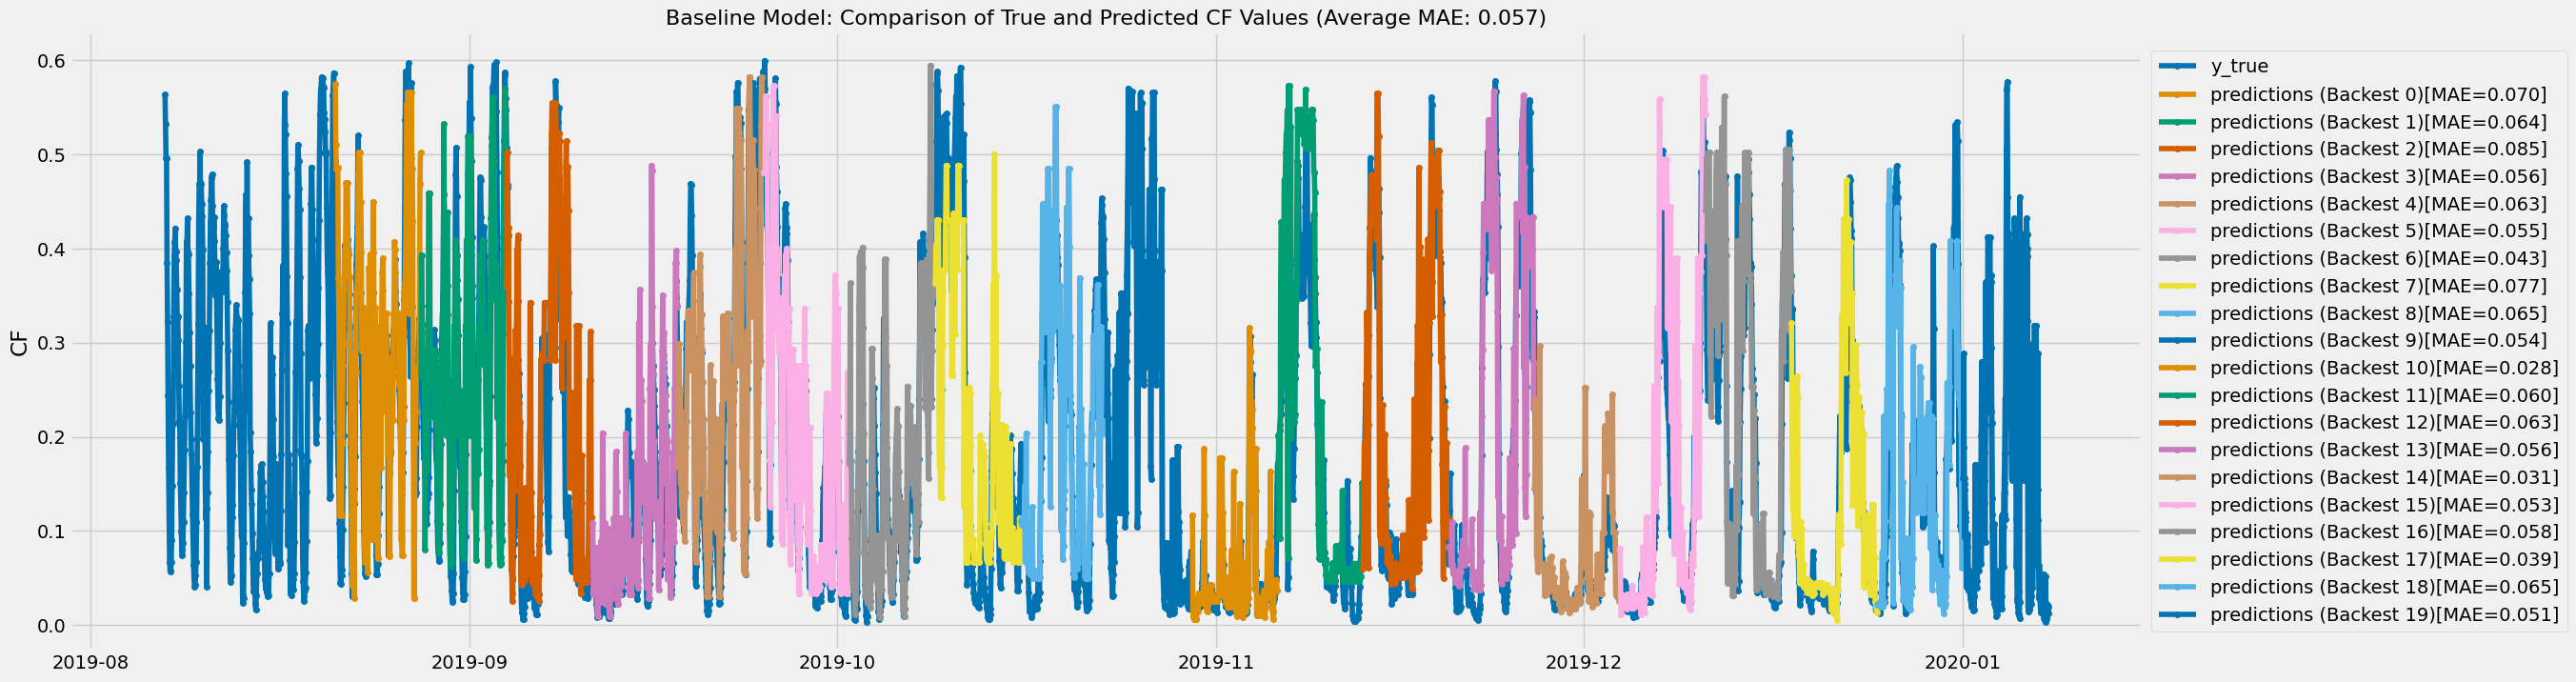

In [565]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

fig_size = 25
n_splits = 20

tss = TimeSeriesSplit(n_splits=n_splits, test_size=24*7, gap=24)
df = df.sort_index()

fold = 0
fold_results_dict = {}
for train_idx, val_idx in tss.split(df): # note: tss is a generator
    print(f"fold: {fold}")
    train = df.iloc[train_idx] # train_idx: list of indices
    test = df.iloc[val_idx] # val_idx: list of indices
    print(f"size of train set: {train.shape}")
    print(f"size of test set: {test.shape}")
    
    # Train model for wind variable predictions
    decision_tree = DecisionTreeRegressor(
        random_state=42
    )
    X_train = train[list_wind_predictors]
    y_train = train[[response_var]]
    X_test = test[list_wind_predictors]
    y_test = test[[response_var]]
    
    decision_tree.fit(X_train, y_train)
    y_train_pred_wind = decision_tree.predict(X_train)
    y_test_pred_wind = decision_tree.predict(X_test)
    # test_mse = mean_squared_error(y_test, y_test_pred_wind)
    test_mae = mean_absolute_error(y_test, y_test_pred_wind)
    
    
    # Train model to predict CF
    X_train = pd.Series(y_train_pred_wind, index=X_train.index)
    X_test = pd.Series(y_test_pred_wind, index=X_test.index)
    # X_train = X_train.drop(columns=list_wind_predictors, axis=1)
    # X_test = X_test.drop(columns=list_wind_predictors, axis=1)
    # print(X_train.columns)
    # print(X_test.columns)
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    # score_mse = np.sqrt(mean_squared_error(y_test, y_pred))
    score_mae = mean_absolute_error(y_test, y_pred)
    
    fold_results_dict[fold] = {
        'predictions_via_wind_data': pd.Series(y_test_pred_wind, index=X_test.index),
        'predictions': pd.Series(y_pred, index=X_test.index),
        # 'mse_wind_tree': test_mse,
        'mae_wind_tree': test_mae,
        'decision_tree_wind_tree': decision_tree,
        'xgb_regressor_cf': reg,
        # 'mse_cf': score_mse,
        'mae_score': score_mae,
        
    }
    fold += 1
# plt.show()

print("MAE (Test Set):", mae_train_test_split)

list_cv_mae_scores = []
for key, value in fold_results_dict.items():
    # print(key, value)
    list_cv_mae_scores.append(fold_results_dict[key]['mae_score'])
print("Average MAE (From the Cross Validation Folds):", np.mean(list_cv_mae_scores))

fig, ax = plot_series(
    y,
    fold_results_dict[0]['predictions'],
    fold_results_dict[1]['predictions'],
    fold_results_dict[2]['predictions'],
    fold_results_dict[3]['predictions'],
    fold_results_dict[4]['predictions'],
    fold_results_dict[5]['predictions'],
    fold_results_dict[6]['predictions'],
    fold_results_dict[7]['predictions'],
    fold_results_dict[8]['predictions'],
    fold_results_dict[9]['predictions'],
    fold_results_dict[10]['predictions'],
    fold_results_dict[11]['predictions'],
    fold_results_dict[12]['predictions'],
    fold_results_dict[13]['predictions'],
    fold_results_dict[14]['predictions'],
    fold_results_dict[15]['predictions'],
    fold_results_dict[16]['predictions'],
    fold_results_dict[17]['predictions'],
    fold_results_dict[18]['predictions'],
    fold_results_dict[19]['predictions'],
    
    # fold_results_dict['predictions'].iloc[20],
    
    
    labels=["y_true"] + ["predictions (Backest " + str(x) + ")" + f"[MAE={fold_results_dict[x]['mae_score']:.3f}]" for x in range(0, (20))]# ["predictions (Backest " + str(x) + ")" for x in range(1 + 5)]
    
)
fig.set_size_inches(25, 8)  # Change the figure size to 15 inches wide by 8 inches tall

ax.set_title(f'Baseline Model: Comparison of True and Predicted CF Values (Average MAE: {np.mean(list_cv_mae_scores):.3f})', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  # Adjust the legend position
plt.show()  # Display the plot

Next, let's look at the more advanced ensemble model that I plan on using:

Create Graphical Pipeline Instance

![Diagram of Graphical Pipeline](../img/graphical_pipeline_diagram.png)

Note: We can use `sktime` for Graphical Pipelines, but I found it easier to iterate through the folds and use `sklearn` API

In [566]:
# Train/test performance
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
df = df.sort_index()

split_point = int(len(df) * 0.8)
cutoff_date_str = df.index[split_point]
print(f"cutoff date: {cutoff_date_str}")
train = df.loc[df.index < cutoff_date_str]
test = df.loc[df.index >= cutoff_date_str]


# Train model for wind variable predictions
decision_tree = DecisionTreeRegressor(
    random_state=42
)
X_train = train[list_wind_predictors]
y_train = train[[response_var]]
X_test = test[list_wind_predictors]
y_test = test[[response_var]]

decision_tree.fit(X_train, y_train)
y_train_pred_wind = decision_tree.predict(X_train)
y_test_pred_wind = decision_tree.predict(X_test)
# test_mse = mean_squared_error(y_test, y_test_pred_wind)
test_mae = mean_absolute_error(y_test, y_test_pred_wind)

# Train model to predict CF
X_train.loc[:, 'prediction_wind_decision_tree'] = pd.Series(y_train_pred_wind, index=X_train.index)
X_test.loc[:, 'prediction_wind_decision_tree'] = pd.Series(y_test_pred_wind, index=X_test.index)

X_train = train.drop(columns=list_wind_predictors, axis=1)
X_test = test.drop(columns=list_wind_predictors, axis=1)
X_train = X_train.drop(columns=[response_var], axis=1)
X_test = X_test.drop(columns=[response_var], axis=1)

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=1000,
                        early_stopping_rounds=50,
                        objective='reg:linear',
                        max_depth=3,
                        learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

y_pred_train_test_split = reg.predict(X_test)
# mse_train_test_split = np.sqrt(mean_squared_error(y_test, y_pred_train_test_split))
mae_train_test_split = mean_absolute_error(y_test, y_pred_train_test_split)

mae_train_test_split

cutoff date: 2019-12-08 05:00:00
[0]	validation_0-rmse:0.34613	validation_1-rmse:0.36334


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[100]	validation_0-rmse:0.13277	validation_1-rmse:0.13976
[200]	validation_0-rmse:0.06139	validation_1-rmse:0.06891
[300]	validation_0-rmse:0.04274	validation_1-rmse:0.05367
[400]	validation_0-rmse:0.03879	validation_1-rmse:0.05150
[484]	validation_0-rmse:0.03777	validation_1-rmse:0.05210


0.034821404590407404

Next, train/test the model using the expanding window cross validation method:

In [567]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

fig_size = 25
n_splits = 20

tss = TimeSeriesSplit(n_splits=n_splits, test_size=24*7, gap=24)
df = df.sort_index()

fold = 0
fold_results_dict = {}
for train_idx, val_idx in tss.split(df): # note: tss is a generator
    print(f"fold: {fold}")
    train = df.iloc[train_idx] # train_idx: list of indices
    test = df.iloc[val_idx] # val_idx: list of indices
    print(f"size of train set: {train.shape}")
    print(f"size of test set: {test.shape}")
    
    # Train model for wind variable predictions
    decision_tree = DecisionTreeRegressor(
        random_state=42
    )
    X_train = train[list_wind_predictors]
    y_train = train[[response_var]]
    X_test = test[list_wind_predictors]
    y_test = test[[response_var]]
    
    decision_tree.fit(X_train, y_train)
    y_train_pred_wind = decision_tree.predict(X_train)
    y_test_pred_wind = decision_tree.predict(X_test)
    # test_mse = mean_squared_error(y_test, y_test_pred_wind)
    test_mae = mean_absolute_error(y_test, y_test_pred_wind)
    
    
    # Train model to predict CF
    X_train.loc[:, 'prediction_wind_decision_tree'] = pd.Series(y_train_pred_wind, index=X_train.index)
    X_test.loc[:, 'prediction_wind_decision_tree'] = pd.Series(y_test_pred_wind, index=X_test.index)
    
    X_train = train.drop(columns=list_wind_predictors, axis=1)
    X_test = test.drop(columns=list_wind_predictors, axis=1)
    X_train = X_train.drop(columns=[response_var], axis=1)
    X_test = X_test.drop(columns=[response_var], axis=1)
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    # score_mse = np.sqrt(mean_squared_error(y_test, y_pred))
    score_mae = mean_absolute_error(y_test, y_pred)
    
    fold_results_dict[fold] = {
        'predictions_via_wind_data': pd.Series(y_test_pred_wind, index=X_test.index),
        'predictions': pd.Series(y_pred, index=X_test.index),
        # 'mse_wind_tree': test_mse,
        'mae_wind_tree': test_mae,
        'decision_tree_wind_tree': decision_tree,
        'xgb_regressor_cf': reg,
        # 'mse_cf': score_mse,
        'mae_score': score_mae,
        
    }
    fold += 1
# plt.show()

fold: 0
size of train set: (310, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.29623	validation_1-rmse:0.26961
[100]	validation_0-rmse:0.11807	validation_1-rmse:0.10991


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.05900	validation_1-rmse:0.06001
[300]	validation_0-rmse:0.04274	validation_1-rmse:0.04808
[400]	validation_0-rmse:0.03824	validation_1-rmse:0.04658
[500]	validation_0-rmse:0.03650	validation_1-rmse:0.04633
[513]	validation_0-rmse:0.03617	validation_1-rmse:0.04637
fold: 1
size of train set: (478, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.28431	validation_1-rmse:0.27295
[100]	validation_0-rmse:0.11333	validation_1-rmse:0.10948


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.05728	validation_1-rmse:0.06157
[300]	validation_0-rmse:0.04292	validation_1-rmse:0.05325
[400]	validation_0-rmse:0.03918	validation_1-rmse:0.05271
[419]	validation_0-rmse:0.03887	validation_1-rmse:0.05269
fold: 2
size of train set: (646, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.28130	validation_1-rmse:0.36723
[100]	validation_0-rmse:0.11245	validation_1-rmse:0.15833


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.05754	validation_1-rmse:0.09881
[300]	validation_0-rmse:0.04355	validation_1-rmse:0.08047
[400]	validation_0-rmse:0.03989	validation_1-rmse:0.07588
[500]	validation_0-rmse:0.03830	validation_1-rmse:0.07539
[547]	validation_0-rmse:0.03770	validation_1-rmse:0.07572
fold: 3
size of train set: (814, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.29397	validation_1-rmse:0.40567
[100]	validation_0-rmse:0.11680	validation_1-rmse:0.15968


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.05896	validation_1-rmse:0.06914
[300]	validation_0-rmse:0.04408	validation_1-rmse:0.04124
[400]	validation_0-rmse:0.04027	validation_1-rmse:0.03604
[500]	validation_0-rmse:0.03843	validation_1-rmse:0.03497
[581]	validation_0-rmse:0.03752	validation_1-rmse:0.03488
fold: 4
size of train set: (982, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.31878	validation_1-rmse:0.29605
[100]	validation_0-rmse:0.12454	validation_1-rmse:0.11760


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.05993	validation_1-rmse:0.06013
[300]	validation_0-rmse:0.04286	validation_1-rmse:0.04991
[400]	validation_0-rmse:0.03864	validation_1-rmse:0.04926
[401]	validation_0-rmse:0.03861	validation_1-rmse:0.04928
fold: 5
size of train set: (1150, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.31909	validation_1-rmse:0.34217
[100]	validation_0-rmse:0.12441	validation_1-rmse:0.13268


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.05982	validation_1-rmse:0.06403
[300]	validation_0-rmse:0.04284	validation_1-rmse:0.05004
[400]	validation_0-rmse:0.03882	validation_1-rmse:0.04738
[500]	validation_0-rmse:0.03718	validation_1-rmse:0.04670
[524]	validation_0-rmse:0.03694	validation_1-rmse:0.04700
fold: 6
size of train set: (1318, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.31759	validation_1-rmse:0.35823
[100]	validation_0-rmse:0.12387	validation_1-rmse:0.14295


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.05997	validation_1-rmse:0.06846
[300]	validation_0-rmse:0.04338	validation_1-rmse:0.04559
[400]	validation_0-rmse:0.03961	validation_1-rmse:0.03884
[500]	validation_0-rmse:0.03822	validation_1-rmse:0.03695
[594]	validation_0-rmse:0.03742	validation_1-rmse:0.03718
fold: 7
size of train set: (1486, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.32629	validation_1-rmse:0.32805
[100]	validation_0-rmse:0.12647	validation_1-rmse:0.12579


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.06011	validation_1-rmse:0.05837
[300]	validation_0-rmse:0.04272	validation_1-rmse:0.04313
[400]	validation_0-rmse:0.03882	validation_1-rmse:0.04275
[422]	validation_0-rmse:0.03833	validation_1-rmse:0.04335
fold: 8
size of train set: (1654, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.32370	validation_1-rmse:0.33068
[100]	validation_0-rmse:0.12541	validation_1-rmse:0.13152


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.05965	validation_1-rmse:0.06936
[300]	validation_0-rmse:0.04259	validation_1-rmse:0.05682
[400]	validation_0-rmse:0.03889	validation_1-rmse:0.05317
[500]	validation_0-rmse:0.03749	validation_1-rmse:0.05250
[539]	validation_0-rmse:0.03711	validation_1-rmse:0.05283
fold: 9
size of train set: (1822, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.32684	validation_1-rmse:0.32160
[100]	validation_0-rmse:0.12654	validation_1-rmse:0.12108


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.06004	validation_1-rmse:0.05468
[300]	validation_0-rmse:0.04275	validation_1-rmse:0.04390
[371]	validation_0-rmse:0.03961	validation_1-rmse:0.04450
fold: 10
size of train set: (1990, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.32274	validation_1-rmse:0.45113
[100]	validation_0-rmse:0.12523	validation_1-rmse:0.17227


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.05995	validation_1-rmse:0.07132
[300]	validation_0-rmse:0.04316	validation_1-rmse:0.03648
[400]	validation_0-rmse:0.03946	validation_1-rmse:0.02630
[500]	validation_0-rmse:0.03811	validation_1-rmse:0.02342
[600]	validation_0-rmse:0.03735	validation_1-rmse:0.02287
[641]	validation_0-rmse:0.03717	validation_1-rmse:0.02316
fold: 11
size of train set: (2158, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.33469	validation_1-rmse:0.34467
[100]	validation_0-rmse:0.12896	validation_1-rmse:0.12893


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.06037	validation_1-rmse:0.05906
[300]	validation_0-rmse:0.04234	validation_1-rmse:0.04327
[400]	validation_0-rmse:0.03836	validation_1-rmse:0.04233
[415]	validation_0-rmse:0.03808	validation_1-rmse:0.04246
fold: 12
size of train set: (2326, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.33532	validation_1-rmse:0.33482
[100]	validation_0-rmse:0.12923	validation_1-rmse:0.12787


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.06059	validation_1-rmse:0.06578
[300]	validation_0-rmse:0.04264	validation_1-rmse:0.05632
[400]	validation_0-rmse:0.03868	validation_1-rmse:0.05512
[459]	validation_0-rmse:0.03779	validation_1-rmse:0.05529
fold: 13
size of train set: (2494, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.33740	validation_1-rmse:0.34189
[100]	validation_0-rmse:0.13008	validation_1-rmse:0.12989


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.06118	validation_1-rmse:0.06031
[300]	validation_0-rmse:0.04331	validation_1-rmse:0.04540
[399]	validation_0-rmse:0.03943	validation_1-rmse:0.04490
fold: 14
size of train set: (2662, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.33829	validation_1-rmse:0.43904
[100]	validation_0-rmse:0.13034	validation_1-rmse:0.16217


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.06125	validation_1-rmse:0.06174
[300]	validation_0-rmse:0.04341	validation_1-rmse:0.02932
[400]	validation_0-rmse:0.03954	validation_1-rmse:0.02156
[500]	validation_0-rmse:0.03840	validation_1-rmse:0.01932
[600]	validation_0-rmse:0.03784	validation_1-rmse:0.01860
[644]	validation_0-rmse:0.03770	validation_1-rmse:0.01869
fold: 15
size of train set: (2830, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.34319	validation_1-rmse:0.38959
[100]	validation_0-rmse:0.13183	validation_1-rmse:0.14781


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.06128	validation_1-rmse:0.06419
[300]	validation_0-rmse:0.04292	validation_1-rmse:0.04209
[400]	validation_0-rmse:0.03897	validation_1-rmse:0.03782
[500]	validation_0-rmse:0.03776	validation_1-rmse:0.03741
[524]	validation_0-rmse:0.03757	validation_1-rmse:0.03744
fold: 16
size of train set: (2998, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.34736	validation_1-rmse:0.31647
[100]	validation_0-rmse:0.13314	validation_1-rmse:0.12239


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.06139	validation_1-rmse:0.06040
[300]	validation_0-rmse:0.04261	validation_1-rmse:0.04635
[400]	validation_0-rmse:0.03864	validation_1-rmse:0.04444
[500]	validation_0-rmse:0.03744	validation_1-rmse:0.04383
[540]	validation_0-rmse:0.03716	validation_1-rmse:0.04387
fold: 17
size of train set: (3166, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.34583	validation_1-rmse:0.40064


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[100]	validation_0-rmse:0.13265	validation_1-rmse:0.15044
[200]	validation_0-rmse:0.06139	validation_1-rmse:0.06398
[300]	validation_0-rmse:0.04285	validation_1-rmse:0.03958
[400]	validation_0-rmse:0.03898	validation_1-rmse:0.03527
[483]	validation_0-rmse:0.03797	validation_1-rmse:0.03502
fold: 18
size of train set: (3334, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.34730	validation_1-rmse:0.35790


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[100]	validation_0-rmse:0.13312	validation_1-rmse:0.14101
[200]	validation_0-rmse:0.06145	validation_1-rmse:0.07867
[300]	validation_0-rmse:0.04279	validation_1-rmse:0.06762
[400]	validation_0-rmse:0.03895	validation_1-rmse:0.06523
[500]	validation_0-rmse:0.03791	validation_1-rmse:0.06477
[600]	validation_0-rmse:0.03747	validation_1-rmse:0.06477
[601]	validation_0-rmse:0.03747	validation_1-rmse:0.06477
fold: 19
size of train set: (3502, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.34915	validation_1-rmse:0.37168
[100]	validation_0-rmse:0.13386	validation_1-rmse:0.14370


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[200]	validation_0-rmse:0.06190	validation_1-rmse:0.07404
[300]	validation_0-rmse:0.04327	validation_1-rmse:0.06181
[400]	validation_0-rmse:0.03941	validation_1-rmse:0.06073
[500]	validation_0-rmse:0.03843	validation_1-rmse:0.06051
[600]	validation_0-rmse:0.03798	validation_1-rmse:0.06056
[606]	validation_0-rmse:0.03796	validation_1-rmse:0.06059


In [568]:
X_test.head()

hour  dayofweek  quarter  month    year  dayofyear  \
2020-01-01 00:00:00   0.0        2.0      1.0    1.0  2020.0        1.0   
2020-01-01 01:00:00   1.0        2.0      1.0    1.0  2020.0        1.0   
2020-01-01 02:00:00   2.0        2.0      1.0    1.0  2020.0        1.0   
2020-01-01 03:00:00   3.0        2.0      1.0    1.0  2020.0        1.0   
2020-01-01 04:00:00   4.0        2.0      1.0    1.0  2020.0        1.0   

                     dayofmonth  weekofyear  prediction_wind_decision_tree  \
2020-01-01 00:00:00         1.0         1.0                       0.126510   
2020-01-01 01:00:00         1.0         1.0                       0.201944   
2020-01-01 02:00:00         1.0         1.0                       0.201944   
2020-01-01 03:00:00         1.0         1.0                       0.113767   
2020-01-01 04:00:00         1.0         1.0                       0.113767   

                     holiday_name_Christmas Day  holiday_name_Columbus Day  \
2020-01-01 00:00:00                           0                          0   
2020-01-01 01:00:00                           0                          0   
2020-01-01 02:00:00                           0                          0   
2020-01-01 03:00:00                           0                          0   
2020-01-01 04:00:00                           0                          0   

                     holiday_name_Labor Day  holiday_name_New Year's Day  \
2020-01-01 00:00:00                       0                            1   
2020-01-01 01:00:00                       0                            1   
2020-01-01 02:00:00                       0                            1   
2020-01-01 03:00:00                       0                            1   
2020-01-01 04:00:00                       0                            1   

                     holiday_name_Thanksgiving  holiday_name_Veterans Day  
2020-01-01 00:00:00                          0                          0  
2020-01-01 01:00:00                          0                          0  
2020-01-01 02:00:00                          0                          0  
2020-01-01 03:00:00                          0                          0  
2020-01-01 04:00:00                          0                          0

This model appears to perform pretty well. Let's see if we can improve by cross validating with other models and optimizing hyperparameters of said models.

Optimizing XGBoost Regressor:

In [569]:
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import xgboost as xgb

xgb_model = xgb.XGBRegressor()

param_space = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'colsample_bytree': Real(0.3, 1.0),
    'subsample': Real(0.5, 1.0),
    'gamma': Real(0, 5)
}

# Setup the TimeSeriesSplit cross-validator
# tscv = TimeSeriesSplit(n_splits=5)
n_splits = 20
tss = TimeSeriesSplit(n_splits=n_splits, test_size=24*7, gap=24)


# Setup the Bayesian search with time series cross-validation
bayes_search = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_space,
    n_iter=32,
    # cv=tscv,
    cv=tss,
    n_jobs=-1,
    return_train_score=True,
    random_state=42
)

bayes_search.fit(X_train, y_train)

print("Best parameters:", bayes_search.best_params_)
print("Best score:", bayes_search.best_score_)

Best parameters: OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.0), ('learning_rate', 0.01), ('max_depth', 3), ('n_estimators', 500), ('subsample', 0.7802949780421149)])
Best score: 0.880356993996805


In [570]:
bayes_search.best_params_

OrderedDict([('colsample_bytree', 1.0),
             ('gamma', 0.0),
             ('learning_rate', 0.01),
             ('max_depth', 3),
             ('n_estimators', 500),
             ('subsample', 0.7802949780421149)])

In [571]:
bayes_search.best_score_

0.880356993996805

In [572]:
optimized_model = bayes_search.best_estimator_
optimized_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Looking at other versions of models (ie. Linear Regression, Random Forest, LightGBM, KNN):

In [573]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define a dictionary with the models and their hyperparameters
models_and_parameters = {
    'random_forest_regressor': (RandomForestRegressor(),
                                {'regressor__n_estimators': [50, 100, 200],
                                 'regressor__max_features': ['auto', 'sqrt', 'log2']}),
    'xgb_regressor': (xgb.XGBRegressor(),
                      {'regressor__n_estimators': [50, 100, 200],
                       'regressor__max_depth': [3, 5, 7],
                       'regressor__learning_rate': [0.01, 0.1, 0.2]}),
    'knn_regressor': (KNeighborsRegressor(),
                      {'regressor__n_neighbors': [3, 5, 7],
                       'regressor__weights': ['uniform', 'distance']}),
    'lgbm_regressor': (lgb.LGBMRegressor(),
                       {'regressor__n_estimators': [50, 100, 200],
                        'regressor__learning_rate': [0.01, 0.1, 0.2],
                        'regressor__num_leaves': [31, 62, 124]}),
    'linear_regression': (LinearRegression(),
                          {'regressor__fit_intercept': [True, False]})
}


In [574]:
from sklearn.metrics import make_scorer, mean_absolute_error

# Define a dictionary with the models and their hyperparameters
models_and_parameters = {
    'random_forest_regressor': (RandomForestRegressor(),
                                {'regressor__n_estimators': [50, 100, 200],
                                 'regressor__max_features': [None, 'sqrt', 'log2']}),
    'xgb_regressor': (xgb.XGBRegressor(),
                      {'regressor__n_estimators': [50, 100, 200],
                       'regressor__max_depth': [3, 5, 7],
                       'regressor__learning_rate': [0.01, 0.1, 0.2]}),
    'knn_regressor': (KNeighborsRegressor(),
                      {'regressor__n_neighbors': [3, 5, 7],
                       'regressor__weights': ['uniform', 'distance']}),
    'lgbm_regressor': (lgb.LGBMRegressor(),
                       {'regressor__n_estimators': [50, 100, 200],
                        'regressor__learning_rate': [0.01, 0.1, 0.2],
                        'regressor__num_leaves': [31, 62, 124]}),
    # 'linear_regression': (LinearRegression(),
    #                       {'regressor__fit_intercept': [True, False]})
}

results = []

for model_name, (model, param_grid) in models_and_parameters.items():
    # Create a pipeline with the model
    pipeline = Pipeline([
        ('regressor', model)
    ])
    # Set up GridSearchCV to tune the hyperparameters
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
    # Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)
    # Store the results
    results.append((model_name, grid_search.best_score_, grid_search.best_params_))

# Print the results for each model
for result in results:
    print(f"Model: {result[0]}, Best Score (Neg MAE): {result[1]}, Best Params: {result[2]}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 449
[LightGBM] [Info] Number of data points in the train set: 3502, number of used features: 13
[LightGBM] [Info] Start training from score 0.185814
Model: random_forest_regressor, Best Score (Neg MAE): -0.03380087208765205, Best Params: {'regressor__max_features': None, 'regressor__n_estimators': 100}
Model: xgb_regressor, Best Score (Neg MAE): -0.03128640457844266, Best Params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}
Model: knn_regressor, Best Score (Neg MAE): -0.1336230690011256, Best 

In [575]:
results

[('random_forest_regressor',
  -0.03380087208765205,
  {'regressor__max_features': None, 'regressor__n_estimators': 100}),
 ('xgb_regressor',
  -0.03128640457844266,
  {'regressor__learning_rate': 0.1,
   'regressor__max_depth': 3,
   'regressor__n_estimators': 50}),
 ('knn_regressor',
  -0.1336230690011256,
  {'regressor__n_neighbors': 7, 'regressor__weights': 'uniform'}),
 ('lgbm_regressor',
  -0.03270345838372628,
  {'regressor__learning_rate': 0.1,
   'regressor__n_estimators': 50,
   'regressor__num_leaves': 31})]

The models more or less performed similarly, with the XGBoost regressor taking the cake in terms of MAE.

The gradient boosting framework of building an ensemble of weak learners typically leads to a robust model with very competitive accuracy, while also avoiding overfitting due to l1/l2 regularization. These facts contribute to why this model may be performing best with this set of data.

In [576]:
# Final fitting of model (with best parameters)

# Train/test performance
df = df.sort_index()

split_point = int(len(df) * 0.8)
cutoff_date_str = df.index[split_point]
print(f"cutoff date: {cutoff_date_str}")
train = df.loc[df.index < cutoff_date_str]
test = df.loc[df.index >= cutoff_date_str]


# Train model for wind variable predictions
decision_tree = DecisionTreeRegressor(
    random_state=42
)
X_train = train[list_wind_predictors]
y_train = train[[response_var]]
X_test = test[list_wind_predictors]
y_test = test[[response_var]]

decision_tree.fit(X_train, y_train)
y_train_pred_wind = decision_tree.predict(X_train)
y_test_pred_wind = decision_tree.predict(X_test)
# test_mse = mean_squared_error(y_test, y_test_pred_wind)
test_mae = mean_absolute_error(y_test, y_test_pred_wind)

# Train model to predict CF
X_train.loc[:, 'prediction_wind_decision_tree'] = pd.Series(y_train_pred_wind, index=X_train.index)
X_test.loc[:, 'prediction_wind_decision_tree'] = pd.Series(y_test_pred_wind, index=X_test.index)

X_train = train.drop(columns=list_wind_predictors, axis=1)
X_test = test.drop(columns=list_wind_predictors, axis=1)
X_train = X_train.drop(columns=[response_var], axis=1)
X_test = X_test.drop(columns=[response_var], axis=1)

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=50,
                        # early_stopping_rounds=50,
                        objective='reg:linear',
                        max_depth=3,
                        learning_rate=0.1)
# reg = LinearRegression()
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)
# reg.fit(X_train, y_train)

y_pred_train_test_split = reg.predict(X_test)
mae_train_test_split = mean_absolute_error(y_test, y_pred_train_test_split)

mae_train_test_split




cutoff date: 2019-12-08 05:00:00
[0]	validation_0-rmse:0.31526	validation_1-rmse:0.33078
[49]	validation_0-rmse:0.03746	validation_1-rmse:0.05377


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



0.037908217030259574

In [577]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

fig_size = 25
n_splits = 20

tss = TimeSeriesSplit(n_splits=n_splits, test_size=24*7, gap=24)
df = df.sort_index()

fold = 0
fold_results_dict = {}
for train_idx, val_idx in tss.split(df): # note: tss is a generator
    print(f"fold: {fold}")
    train = df.iloc[train_idx] # train_idx: list of indices
    test = df.iloc[val_idx] # val_idx: list of indices
    print(f"size of train set: {train.shape}")
    print(f"size of test set: {test.shape}")
    
    # Train model for wind variable predictions
    decision_tree = DecisionTreeRegressor(
        random_state=42
    )
    X_train = train[list_wind_predictors]
    y_train = train[[response_var]]
    X_test = test[list_wind_predictors]
    y_test = test[[response_var]]
    
    decision_tree.fit(X_train, y_train)
    y_train_pred_wind = decision_tree.predict(X_train)
    y_test_pred_wind = decision_tree.predict(X_test)
    # test_mse = mean_squared_error(y_test, y_test_pred_wind)
    test_mae = mean_absolute_error(y_test, y_test_pred_wind)
    
    
    # Train model to predict CF
    X_train.loc[:, 'prediction_wind_decision_tree'] = pd.Series(y_train_pred_wind, index=X_train.index)
    X_test.loc[:, 'prediction_wind_decision_tree'] = pd.Series(y_test_pred_wind, index=X_test.index)
    
    X_train = train.drop(columns=list_wind_predictors, axis=1)
    X_test = test.drop(columns=list_wind_predictors, axis=1)
    X_train = X_train.drop(columns=[response_var], axis=1)
    X_test = X_test.drop(columns=[response_var], axis=1)
    
    # print(X_train.columns)
    # print(X_test.columns)
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                            n_estimators=50,
                            # early_stopping_rounds=50,
                            objective='reg:linear',
                            max_depth=3,
                            learning_rate=0.1)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    # score_mse = np.sqrt(mean_squared_error(y_test, y_pred))
    score_mae = mean_absolute_error(y_test, y_pred)
    
    fold_results_dict[fold] = {
        'predictions_via_wind_data': pd.Series(y_test_pred_wind, index=X_test.index),
        'predictions': pd.Series(y_pred, index=X_test.index),
        # 'mse_wind_tree': test_mse,
        'mae_wind_tree': test_mae,
        'decision_tree_wind_tree': decision_tree,
        'xgb_regressor_cf': reg,
        # 'mse_cf': score_mse,
        'mae_score': score_mae,
        
    }
    fold += 1

fold: 0
size of train set: (310, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.27046	validation_1-rmse:0.24548
[49]	validation_0-rmse:0.03598	validation_1-rmse:0.04627


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 1
size of train set: (478, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.25954	validation_1-rmse:0.24888
[49]	validation_0-rmse:0.03723	validation_1-rmse:0.05237


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 2
size of train set: (646, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.25679	validation_1-rmse:0.33703
[49]	validation_0-rmse:0.03816	validation_1-rmse:0.07610


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 3
size of train set: (814, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.26824	validation_1-rmse:0.37031
[49]	validation_0-rmse:0.03832	validation_1-rmse:0.03464


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 4
size of train set: (982, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.29063	validation_1-rmse:0.27021
[49]	validation_0-rmse:0.03683	validation_1-rmse:0.04958


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 5
size of train set: (1150, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.29088	validation_1-rmse:0.31199
[49]	validation_0-rmse:0.03714	validation_1-rmse:0.04806


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 6
size of train set: (1318, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.28950	validation_1-rmse:0.32741
[49]	validation_0-rmse:0.03791	validation_1-rmse:0.03686


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 7
size of train set: (1486, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.29735	validation_1-rmse:0.29898
[49]	validation_0-rmse:0.03705	validation_1-rmse:0.04668


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 8
size of train set: (1654, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.29499	validation_1-rmse:0.30188
[49]	validation_0-rmse:0.03723	validation_1-rmse:0.05280


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 9
size of train set: (1822, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.29783	validation_1-rmse:0.29260
[49]	validation_0-rmse:0.03753	validation_1-rmse:0.04706


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 10
size of train set: (1990, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.29412	validation_1-rmse:0.41142
[49]	validation_0-rmse:0.03787	validation_1-rmse:0.02267


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 11
size of train set: (2158, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.30492	validation_1-rmse:0.31312
[49]	validation_0-rmse:0.03707	validation_1-rmse:0.04362


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 12
size of train set: (2326, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.30548	validation_1-rmse:0.30422
[49]	validation_0-rmse:0.03730	validation_1-rmse:0.05588


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 13
size of train set: (2494, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.30738	validation_1-rmse:0.31116
[49]	validation_0-rmse:0.03797	validation_1-rmse:0.04405


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 14
size of train set: (2662, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.30818	validation_1-rmse:0.39944
[49]	validation_0-rmse:0.03820	validation_1-rmse:0.01937


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 15
size of train set: (2830, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.31260	validation_1-rmse:0.35469
[49]	validation_0-rmse:0.03754	validation_1-rmse:0.03783


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 16
size of train set: (2998, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.31637	validation_1-rmse:0.28811
[49]	validation_0-rmse:0.03720	validation_1-rmse:0.04439


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 17
size of train set: (3166, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.31498	validation_1-rmse:0.36457
[49]	validation_0-rmse:0.03774	validation_1-rmse:0.03502


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 18
size of train set: (3334, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.31631	validation_1-rmse:0.32605
[49]	validation_0-rmse:0.03777	validation_1-rmse:0.06480


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



fold: 19
size of train set: (3502, 128)
size of test set: (168, 128)
[0]	validation_0-rmse:0.31800	validation_1-rmse:0.33844
[49]	validation_0-rmse:0.03830	validation_1-rmse:0.06064


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



## Output: MAE (Test Set)


In [578]:
# mae_train_test_split = mean_absolute_error(y_test, y_pred)
print("MAE (Test Set):", mae_train_test_split)

list_cv_mae_scores = []
for key, value in fold_results_dict.items():
    # print(key, value)
    list_cv_mae_scores.append(fold_results_dict[key]['mae_score'])
print("Average MAE (From the Cross Validation Folds):", np.mean(list_cv_mae_scores))



MAE (Test Set): 0.037908217030259574
Average MAE (From the Cross Validation Folds): 0.034868081841153


In [579]:
mae_train_test_split

0.037908217030259574

In [580]:
np.mean(list_cv_mae_scores)

0.034868081841153

## Plot: Predictions vs. Actuals (Test Set)

For this visualization, I will first look at the train/test split.



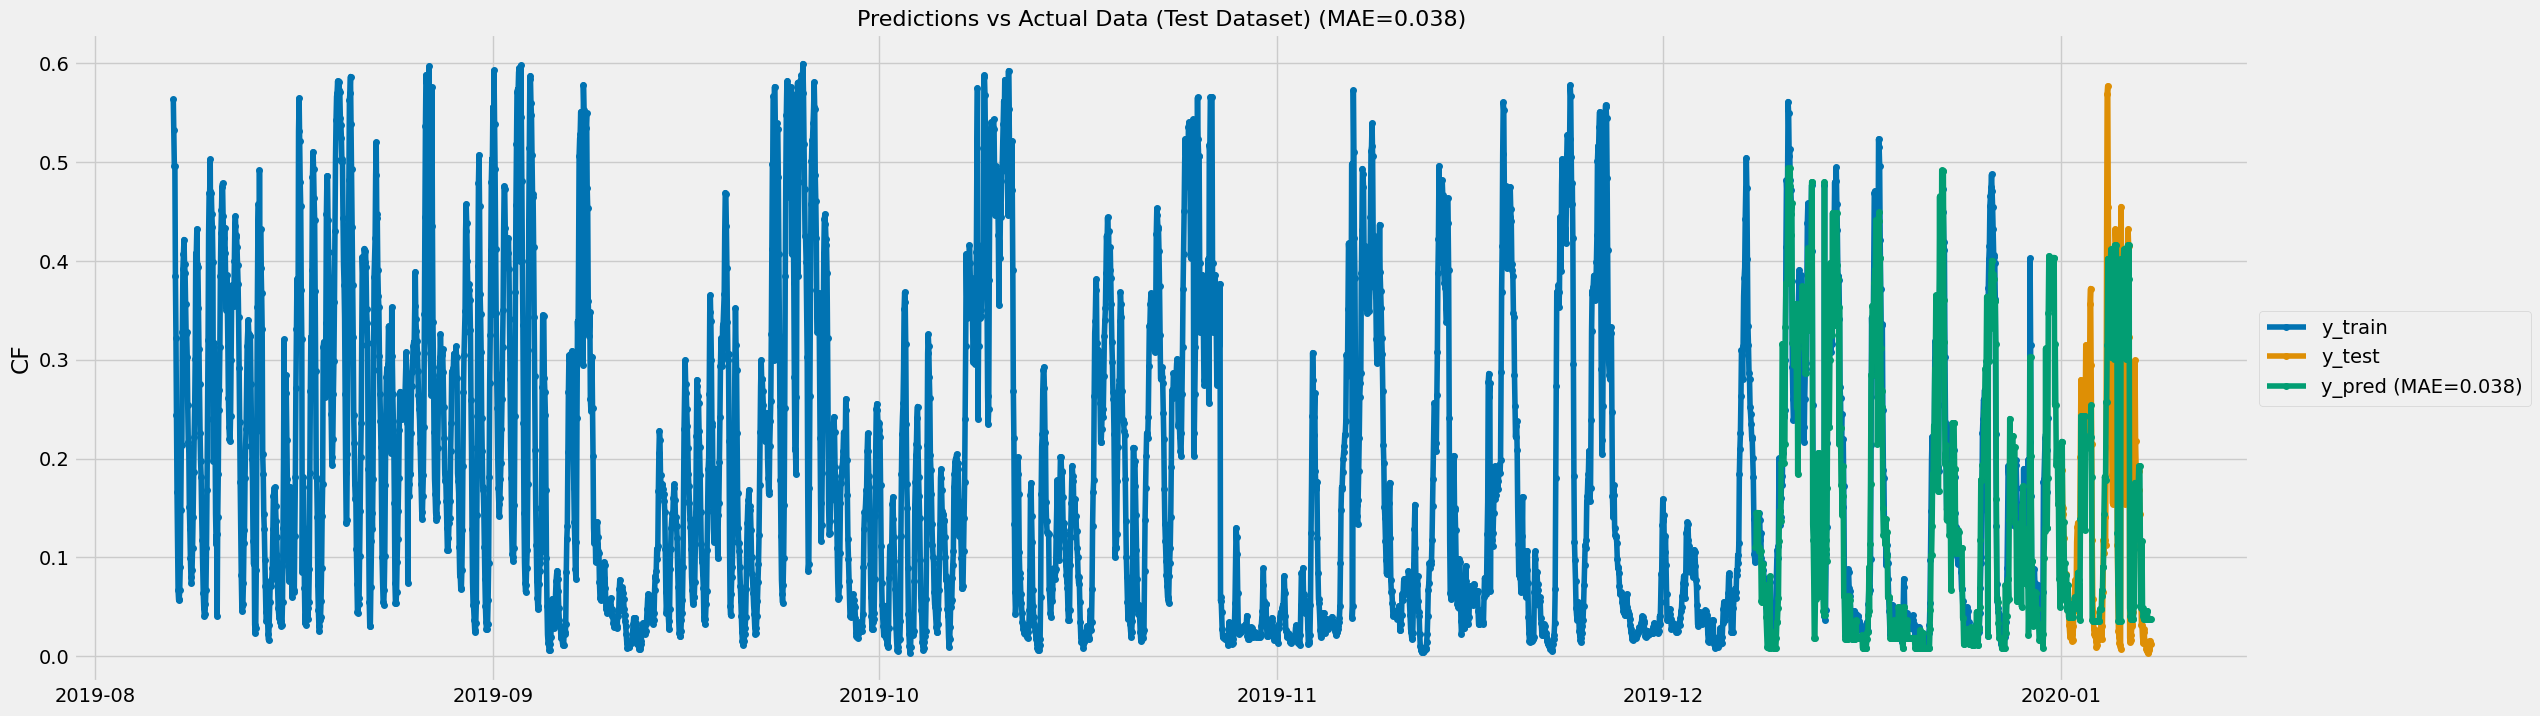

In [581]:
fig, ax = plot_series(y_train, y_test, pd.Series(y_pred_train_test_split, index=df.loc[df.index >= cutoff_date_str].index), labels=['y_train', 'y_test', f'y_pred (MAE={mae_train_test_split:.3f})'])

fig.set_size_inches(25, 8)  # Change the figure size to 25 inches wide by 8 inches tall

ax.set_title(f'Predictions vs Actual Data (Test Dataset) (MAE={mae_train_test_split:.3f})', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  # Adjust the legend position
plt.show()

Model performance during cross-validation:

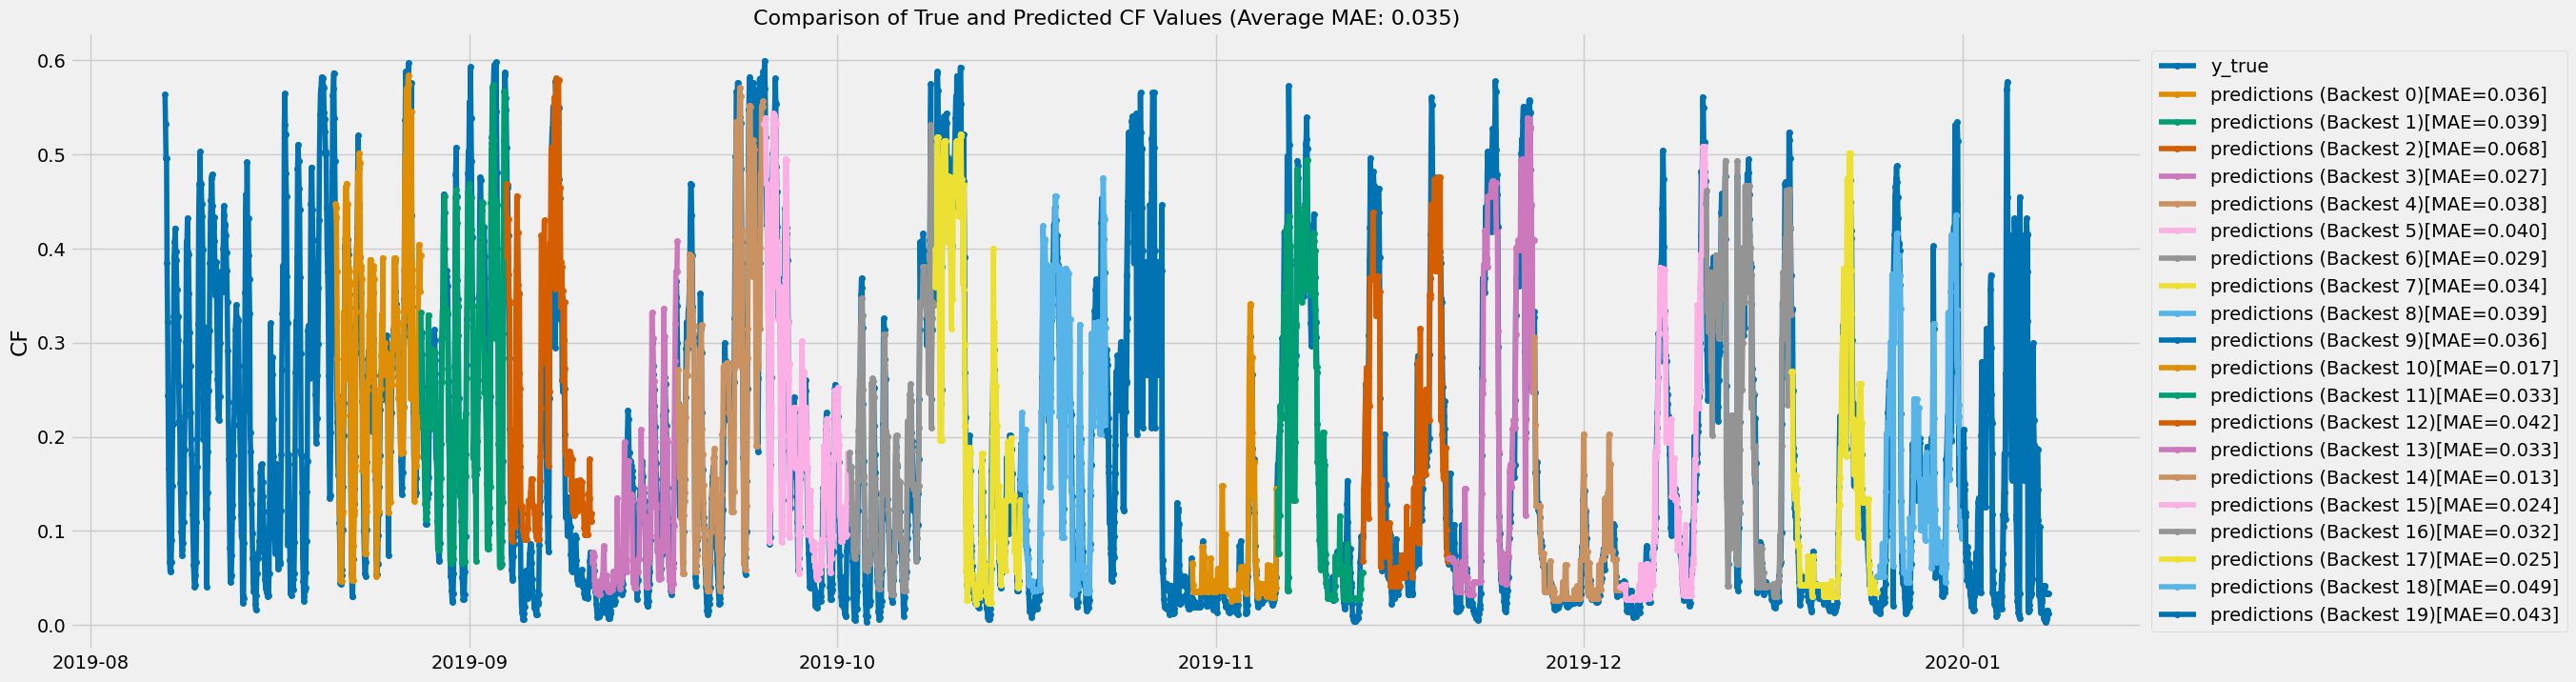

In [582]:
fig, ax = plot_series(
    y,
    fold_results_dict[0]['predictions'],
    fold_results_dict[1]['predictions'],
    fold_results_dict[2]['predictions'],
    fold_results_dict[3]['predictions'],
    fold_results_dict[4]['predictions'],
    fold_results_dict[5]['predictions'],
    fold_results_dict[6]['predictions'],
    fold_results_dict[7]['predictions'],
    fold_results_dict[8]['predictions'],
    fold_results_dict[9]['predictions'],
    fold_results_dict[10]['predictions'],
    fold_results_dict[11]['predictions'],
    fold_results_dict[12]['predictions'],
    fold_results_dict[13]['predictions'],
    fold_results_dict[14]['predictions'],
    fold_results_dict[15]['predictions'],
    fold_results_dict[16]['predictions'],
    fold_results_dict[17]['predictions'],
    fold_results_dict[18]['predictions'],
    fold_results_dict[19]['predictions'],
    
    # fold_results_dict['predictions'].iloc[20],
    
    
    labels=["y_true"] + ["predictions (Backest " + str(x) + ")" + f"[MAE={fold_results_dict[x]['mae_score']:.3f}]" for x in range(0, (20))]# ["predictions (Backest " + str(x) + ")" for x in range(1 + 5)]
    
)
fig.set_size_inches(25, 8)  # Change the figure size to 15 inches wide by 8 inches tall

ax.set_title(f'Comparison of True and Predicted CF Values (Average MAE: {np.mean(list_cv_mae_scores):.3f})', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  # Adjust the legend position
plt.show()  # Display the plot

Results for Ensemble (Wnd Data Decision Tree + XGB Regressor with Dates Information):

- Test MAE: 0.0379
    - The MAE score of for train/test split MAE of 0.0379 is lower than the earlier model that was solely the hyperparameter optimized decision tree (MAE=0.047)
- CV MAE (mean): 0.0348
    - The Average of 20 cross validations MAE is a marked improvement over the Average MAE with the hyperparameter optimized decision tree (AVG MAE=0.055)

Now, each approach (Test MAE, CV Mean of Test MAE) provides different aspects of model performance and overfitting, but I will value the CV Average MAE more than the train/test split MAE.
- This method helps to ensure that the model’s performance is tested across all data points in multiple scenarios, and it give a more robust estimate of model performance on unseen data

In the end, with either metric, the ensemble model outperforms the baseline model(s).

I will proceed with the ensemble model.

## Making Predictions (on 'Predict' Sheet from input Excel file)

Now that we are making prediction on new/unseen data that we cannot compare the results with (since it is in the future), I will re-train the model using ALL data I have available to me, and then make the predictions!

In [583]:
df_test = test_data.copy()
print(df_test.shape)
df_test = ensure_hourly_frequency(df=df_test)

df_test.head()


(93, 113)
2020-01-09 00:00:00 2020-01-12 20:00:00


CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
2020-01-09 00:00:00 NaN        1.69        1.88        3.15        0.92   
2020-01-09 01:00:00 NaN        1.60        2.02        3.91        0.44   
2020-01-09 02:00:00 NaN        1.79        2.14        4.20        0.65   
2020-01-09 03:00:00 NaN        2.01        2.32        5.17        0.51   
2020-01-09 04:00:00 NaN        2.12        2.54        4.19        0.77   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
2020-01-09 00:00:00        2.27        1.14        1.24        2.98   
2020-01-09 01:00:00        2.36        1.15        1.63        2.83   
2020-01-09 02:00:00        2.06        1.28        2.36        3.07   
2020-01-09 03:00:00        2.31        0.83        3.39        3.38   
2020-01-09 04:00:00        4.52        0.97        2.89        3.79   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
2020-01-09 00:00:00        2.53  ...      1.40       1.27       1.27   
2020-01-09 01:00:00        2.84  ...      1.02       1.11       1.43   
2020-01-09 02:00:00        2.34  ...      1.39       1.42       1.42   
2020-01-09 03:00:00        2.53  ...      1.55       2.01       1.26   
2020-01-09 04:00:00        4.21  ...      1.64       2.40       1.69   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
2020-01-09 00:00:00       1.43       1.28       1.91       1.12       1.15   
2020-01-09 01:00:00       2.04       1.60       1.57       1.03       1.28   
2020-01-09 02:00:00       2.91       1.81       1.85       1.10       1.56   
2020-01-09 03:00:00       2.49       2.09       2.09       1.06       2.12   
2020-01-09 04:00:00       1.36       2.08       2.06       1.08       2.33   

                     WS_920775  WS_921049  
2020-01-09 00:00:00       1.35       1.46  
2020-01-09 01:00:00       1.49       1.29  
2020-01-09 02:00:00       1.54       1.56  
2020-01-09 03:00:00       1.66       2.18  
2020-01-09 04:00:00       2.17       2.60  

[5 rows x 113 columns]

In [584]:
df_test.tail()

CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
2020-01-12 16:00:00 NaN        3.12        2.62        4.04        6.08   
2020-01-12 17:00:00 NaN        2.79        2.31        4.25        5.95   
2020-01-12 18:00:00 NaN        2.86        2.44        3.95        6.13   
2020-01-12 19:00:00 NaN        2.81        2.20        4.32        6.07   
2020-01-12 20:00:00 NaN        2.35        1.71        4.12        5.90   

                     WS_1193865  WS_1321569  WS_1324653  WS_1358699  \
2020-01-12 16:00:00        1.07        2.42        2.00        6.50   
2020-01-12 17:00:00        1.59        3.96        1.73        7.42   
2020-01-12 18:00:00        2.58        2.58        1.56        7.36   
2020-01-12 19:00:00        1.93        2.02        1.61        6.72   
2020-01-12 20:00:00        2.10        1.99        1.70        6.36   

                     WS_1366338  ...  WS_78208  WS_811655  WS_839753  \
2020-01-12 16:00:00        1.18  ...      3.93       5.69       5.19   
2020-01-12 17:00:00        1.73  ...      3.58       4.90       4.59   
2020-01-12 18:00:00        2.40  ...      3.62       4.63       4.14   
2020-01-12 19:00:00        1.64  ...      3.95       6.02       4.20   
2020-01-12 20:00:00        1.74  ...      3.72       5.99       4.03   

                     WS_875373  WS_883683  WS_883699  WS_914573  WS_918665  \
2020-01-12 16:00:00       1.80       3.23       3.48       5.16       3.36   
2020-01-12 17:00:00       2.05       2.68       3.04       4.59       2.72   
2020-01-12 18:00:00       2.21       2.41       3.34       4.77       2.54   
2020-01-12 19:00:00       1.37       2.01       3.58       5.06       2.44   
2020-01-12 20:00:00       1.54       1.95       3.23       5.26       2.63   

                     WS_920775  WS_921049  
2020-01-12 16:00:00       5.30       4.55  
2020-01-12 17:00:00       4.63       3.81  
2020-01-12 18:00:00       4.27       3.42  
2020-01-12 19:00:00       4.46       4.33  
2020-01-12 20:00:00       4.35       4.42  

[5 rows x 113 columns]

In [585]:
df_test.shape

(93, 113)

In [586]:
X_predict_wind = df_test.drop(response_var, axis=1)
print(X_predict_wind.shape)
X_predict_wind.index.freq = 'H'
print(X_predict_wind.index.dtype)

(93, 112)
datetime64[ns]


There is a gap of 1 day between the training set and the predict set. Because XGBoost does not inherently use its previous predictions to make future forecasts, this is not an issue.

In [587]:
# Further pre-processing
df_test = create_features(df_test)
df_test = pd.get_dummies(df_test)
del df_test['is_holiday']

holidays_list = [
    'holiday_name_Christmas Day',
    'holiday_name_Columbus Day',
    'holiday_name_Labor Day',
    "holiday_name_New Year's Day",
    "holiday_name_Thanksgiving",
    "holiday_name_Veterans Day",
]
for holiday in holidays_list:
    if holiday not in set(df_test.columns):
        df_test[holiday] = 0

df_test = prepare_data_for_sktime(df_test)



weekofyear
before: UInt32
after: float64


In [588]:
# del df['prediction_wind_decision_tree']

In [589]:
# del df_test[response_var]

In [590]:
df.shape

(3694, 128)

In [591]:
df_test.shape

(93, 127)

Now that the data has been feature engineered like the training set, we train the model and make predictions.

In [592]:
# train = df.loc[df.index < cutoff_date_str]
# test = df.loc[df.index >= cutoff_date_str]
train = df.copy()
test = df_test.copy()



# Train model for wind variable predictions
decision_tree = DecisionTreeRegressor(
    random_state=42
)
X_train = train[list_wind_predictors]
y_train = train[[response_var]]
X_test = test[list_wind_predictors]
# y_test = test[[response_var]]
y_test=None # we don't have this data

decision_tree.fit(X_train, y_train)
y_train_pred_wind = decision_tree.predict(X_train)
y_test_pred_wind = decision_tree.predict(X_test)
# test_mse = mean_squared_error(y_test, y_test_pred_wind)
# test_mae = mean_absolute_error(y_test, y_test_pred_wind)

# Train model to predict CF
if 'prediction_wind_decision_tree' in train.columns:
    del train['prediction_wind_decision_tree']
X_train = train.drop(columns=list_wind_predictors, axis=1).drop(columns=[response_var], axis=1)
X_test = test.drop(columns=list_wind_predictors, axis=1).drop(columns=[response_var], axis=1)
X_train.loc[:, 'prediction_wind_decision_tree'] = pd.Series(y_train_pred_wind, index=X_train.index)
X_test.loc[:, 'prediction_wind_decision_tree'] = pd.Series(y_test_pred_wind, index=X_test.index)

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=50,
                        # early_stopping_rounds=50,
                        objective='reg:linear',
                        max_depth=3,
                        learning_rate=0.1)
reg.fit(X_train, y_train,
        # eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_set=[(X_train, y_train),],
        verbose=100)

y_pred_train_test_split = reg.predict(X=X_test)




[0]	validation_0-rmse:0.31797
[49]	validation_0-rmse:0.00232


c:\Users\Myles\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning:

[09:42:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



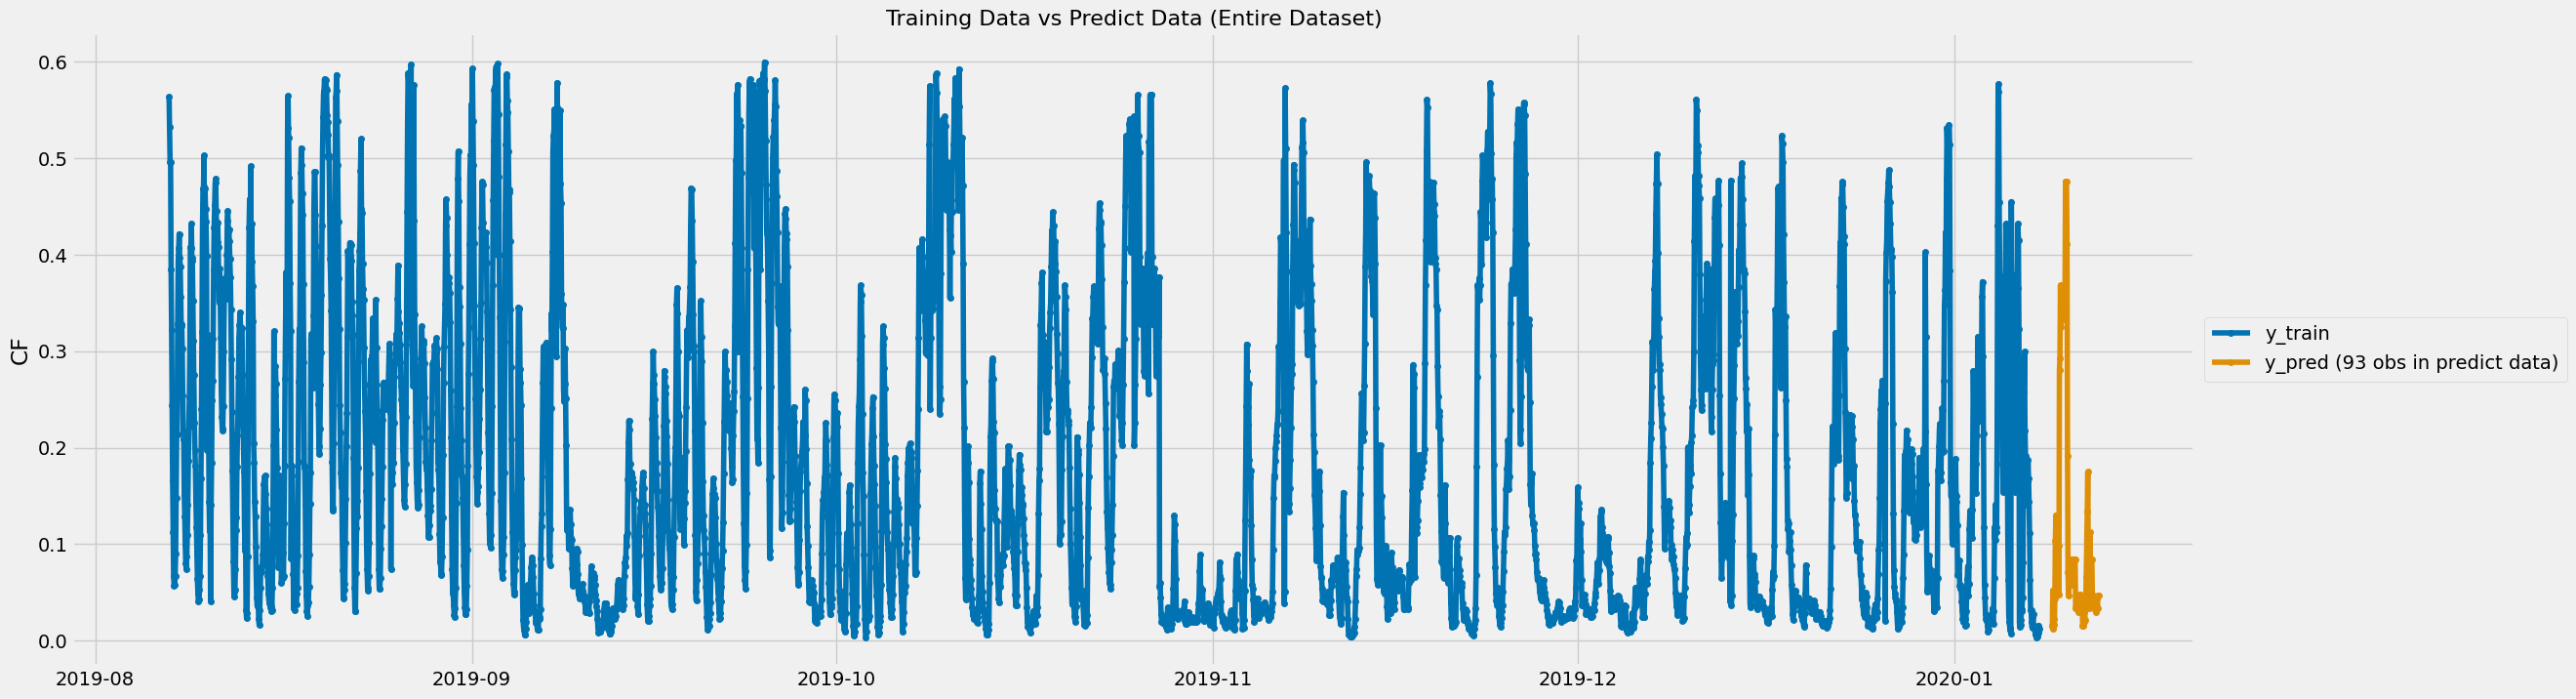

In [593]:
fig, ax = plot_series(
    y_train,
    # y_pred.head(24),
    pd.Series(y_pred_train_test_split, index=X_test.index),
    labels=[
        'y_train',
        # 'y_pred (24 obs from gap day)',
        'y_pred (93 obs in predict data)',
    ]
    )

fig.set_size_inches(25, 8)  # Change the figure size to 25 inches wide by 8 inches tall

ax.set_title('Training Data vs Predict Data (Entire Dataset)', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));  # Adjust the legend position
plt.show()

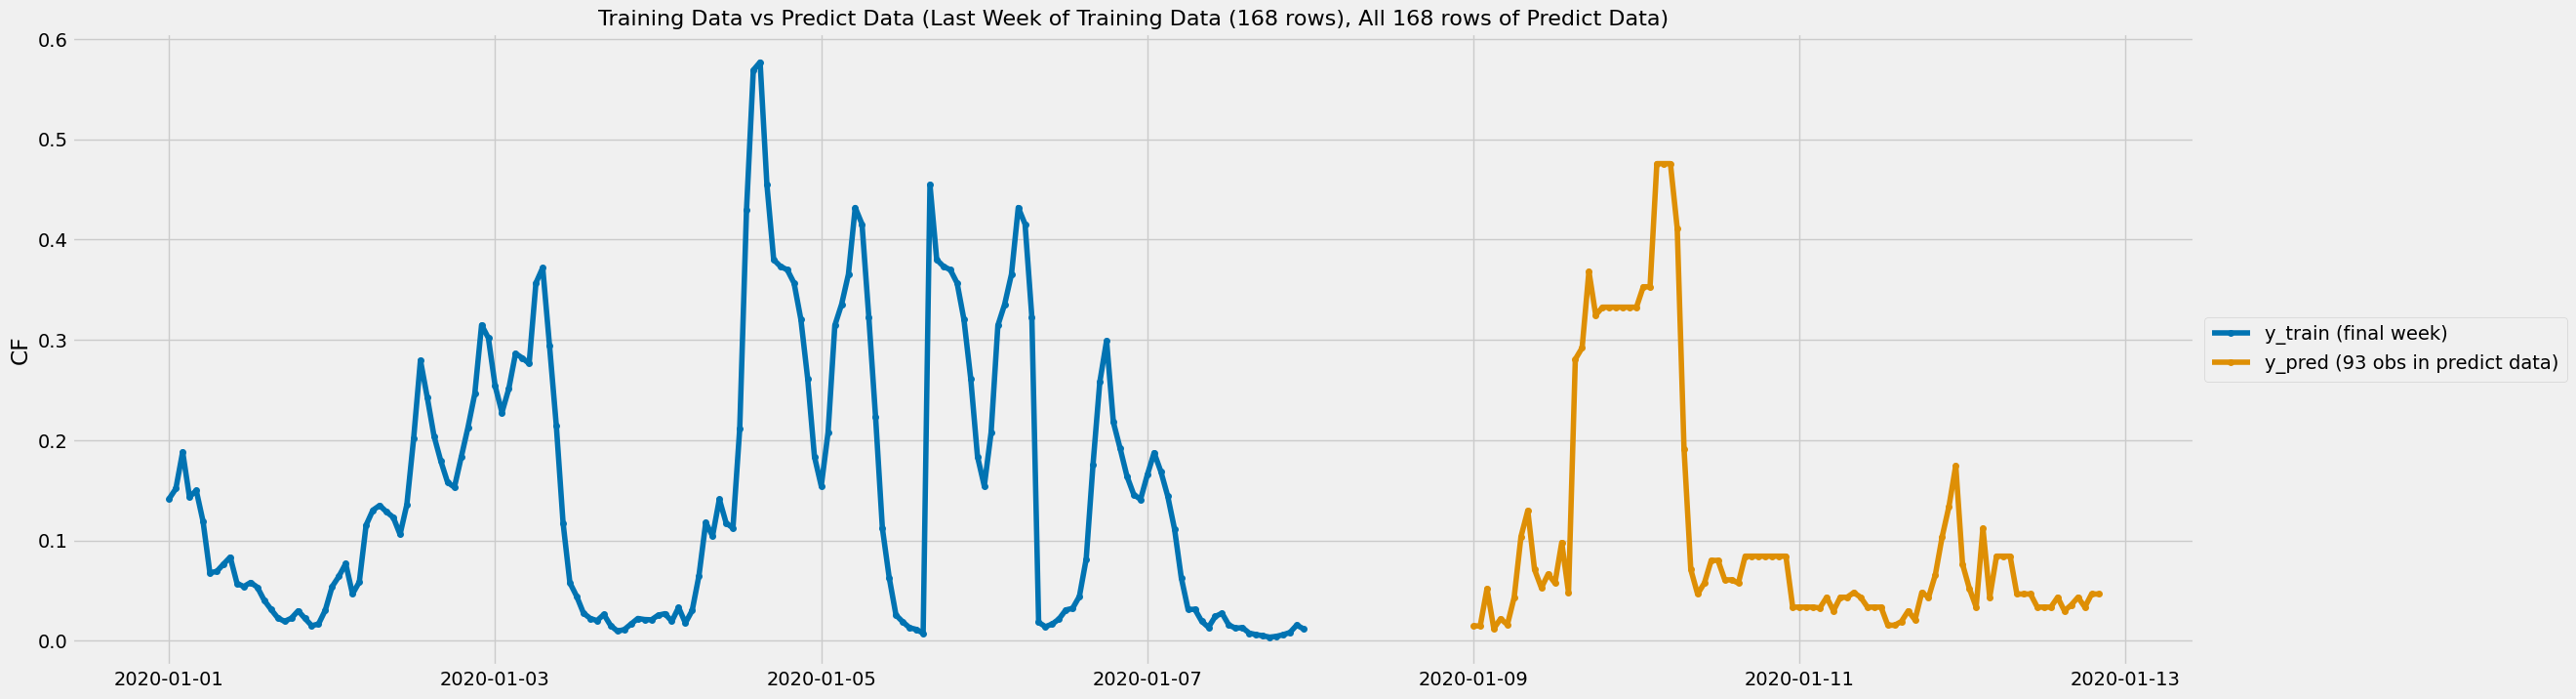

In [594]:
fig, ax = plot_series(
    y_train.tail(24*7),
    # y_pred.head(24),
    pd.Series(y_pred_train_test_split, index=X_test.index),
    labels=[
        'y_train (final week)',
        # 'y_pred (24 obs from gap day)',
        'y_pred (93 obs in predict data)',
    ]
    )

fig.set_size_inches(25, 8)

ax.set_title(f'Training Data vs Predict Data (Last Week of Training Data (168 rows), All {len(y_pred)} rows of Predict Data)', fontsize=16)  # Set the title and font size
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [595]:
last_week_df = pd.concat(objs=[
    y_train.tail(24*7),
    pd.DataFrame({"prediction_label": reg.predict(X=X_train.tail(24*7))}, index=X_train.tail(24*7).index)
], axis=1)

last_week_df

plotly_df = pd.concat(
    objs=[
        last_week_df,
        pd.DataFrame({"prediction_label": y_pred_train_test_split}, index=X_test.index)
        ],
    axis=0
)

plotly_df['Date'] = plotly_df.index

import plotly.express as px
fig = px.line(plotly_df, x='Date', y=[
    response_var,
    "prediction_label"
    ], template = 'plotly_dark')

# add a vertical rectange for test-set separation**
fig.add_vrect(x0=test.index.min(), x1=test.index.max(), fillcolor="grey", opacity=0.25, line_width=0)
fig.update_layout(
    title='Model Predictions vs Actuals (Predict Set Highlighted)',
    xaxis_title='Date',
    yaxis_title=response_var
)
fig.show()

In [596]:
df_predict = pd.DataFrame(
    {response_var: y_pred_train_test_split},
    index=X_test.index
)
df_predict.head()

CF
2020-01-09 00:00:00  0.014903
2020-01-09 01:00:00  0.014903
2020-01-09 02:00:00  0.052065
2020-01-09 03:00:00  0.012260
2020-01-09 04:00:00  0.022019

In [597]:
df_predict.shape

(93, 1)

In [598]:
df_predict.tail(93).to_csv(os.path.join(OUTPUT_DIR, "Predict_CF.csv"))

# The End

---